In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm

Focus on K=100, L=28 (2 dim), M=2

## Network

In [172]:
class FCN(nn.Module):
    def __init__(self, d=28):
        super().__init__()
        #W
        self.lin1 = nn.Linear(28*28,100)
        #V fix it to 1/100
        self.lin2 = nn.Linear(1,100)
        self.lin2.weight.data=torch.ones(1,100)/100
        self.lin2.bias.data = torch.zeros(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.lin1(x)
        x = F.sigmoid(x)
        x = self.lin2(x)
        return x

In [173]:
fc = FCN()

In [4]:
W=fc.lin1.weight.data

In [144]:
def visualize_fields(W):
    """
    W - K x (NxN) matrix
        K number of linear units
        NxN shape of the image
    """
    K,N_squared = W.shape
    N = int(np.sqrt(N_squared))
    for i in range(K):
        plt.imshow(W[i].reshape((N,N)))
        plt.show()

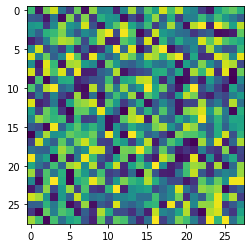

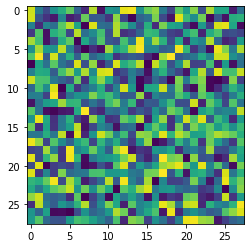

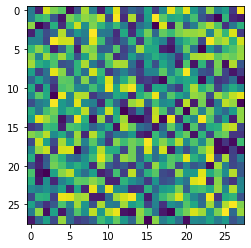

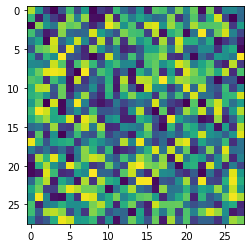

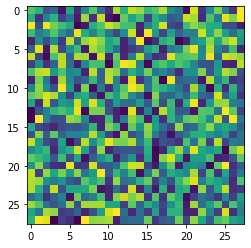

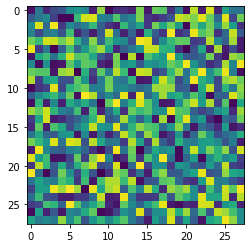

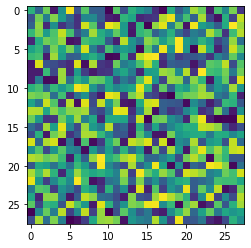

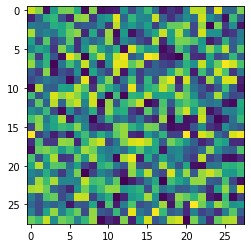

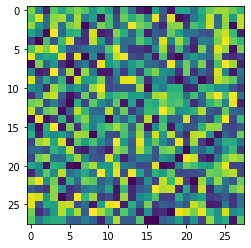

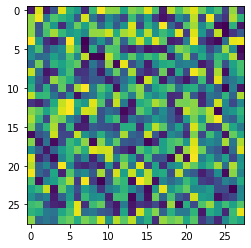

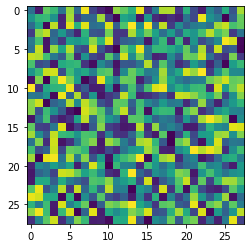

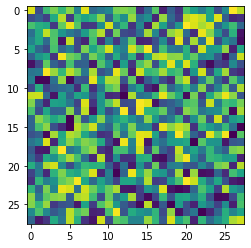

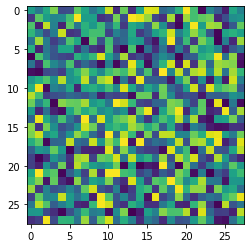

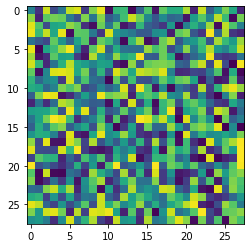

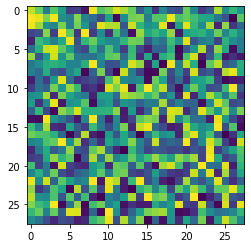

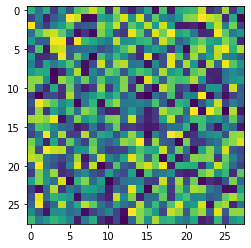

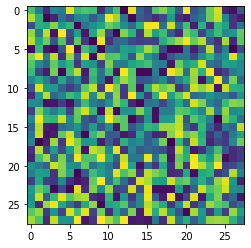

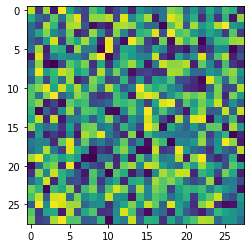

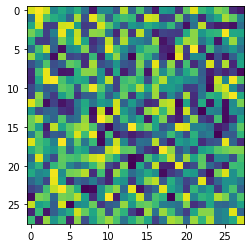

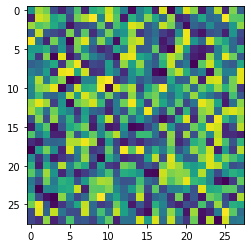

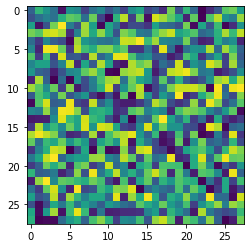

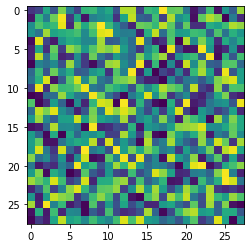

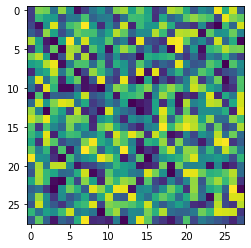

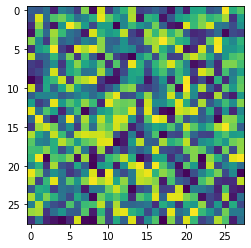

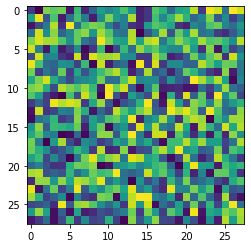

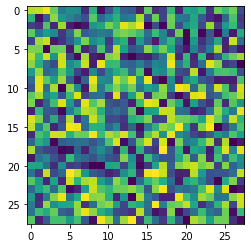

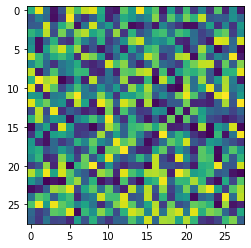

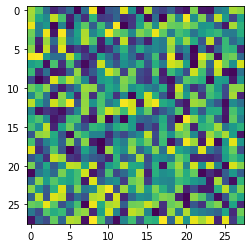

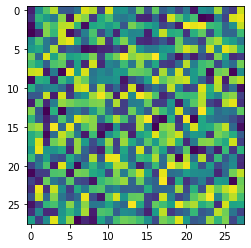

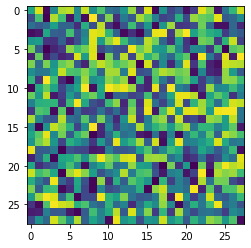

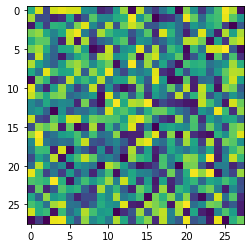

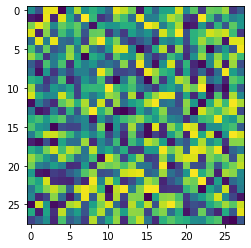

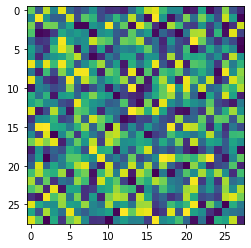

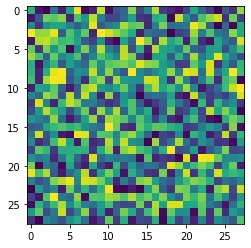

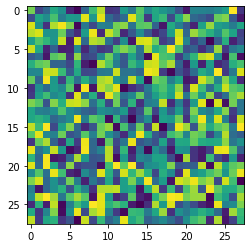

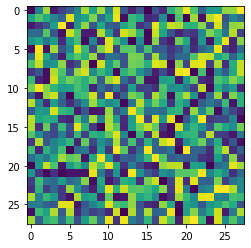

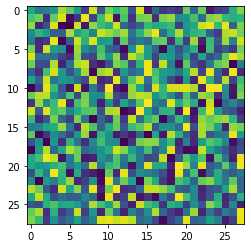

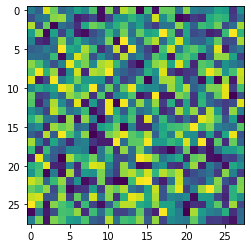

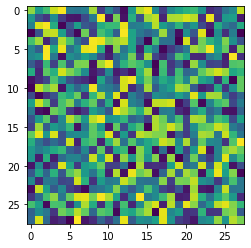

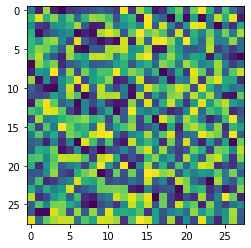

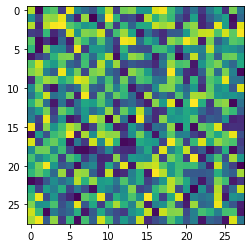

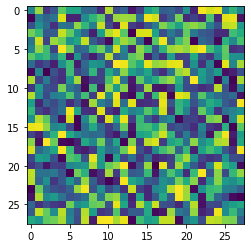

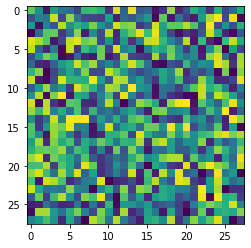

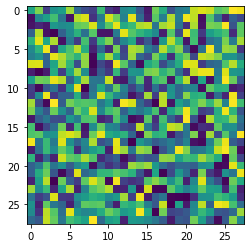

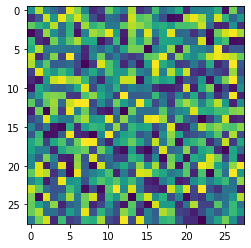

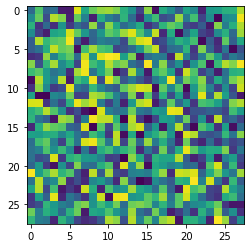

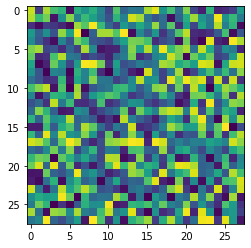

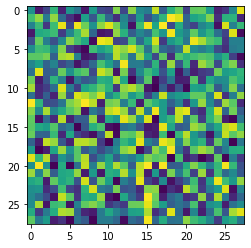

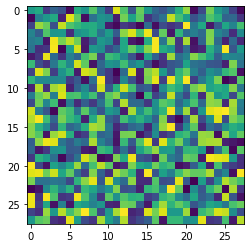

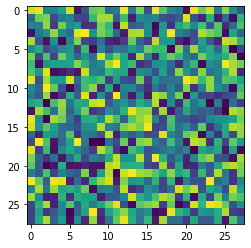

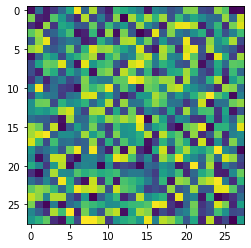

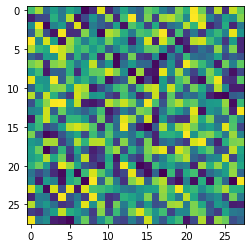

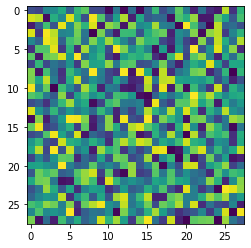

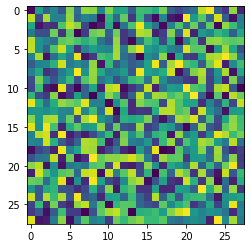

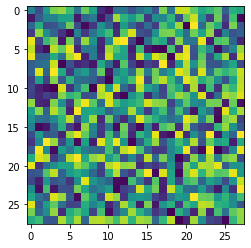

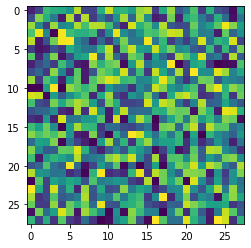

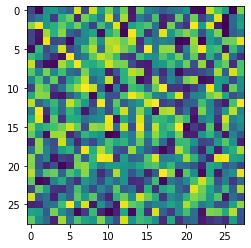

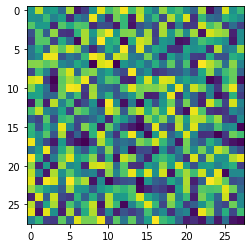

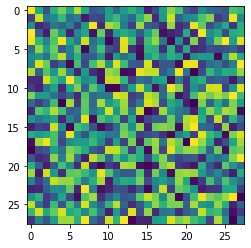

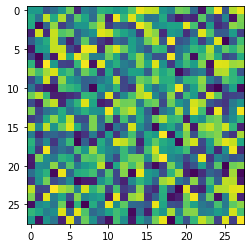

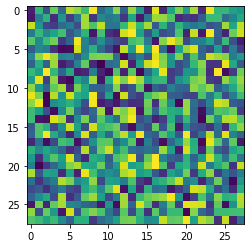

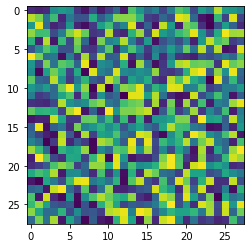

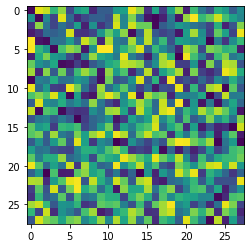

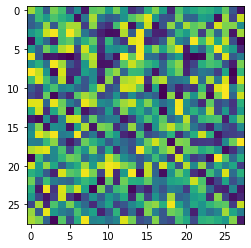

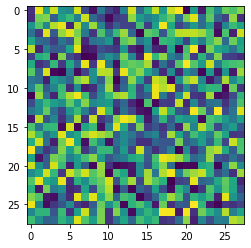

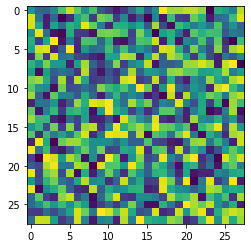

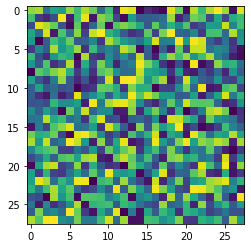

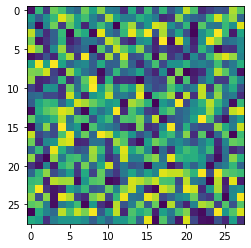

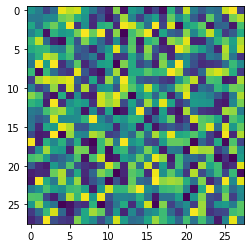

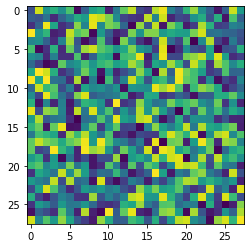

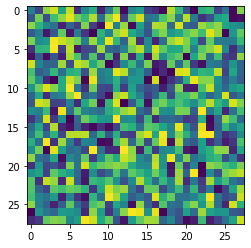

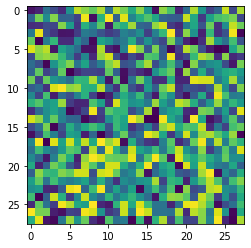

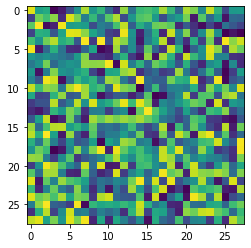

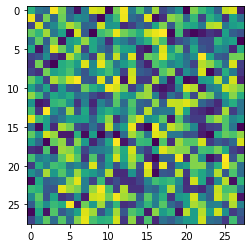

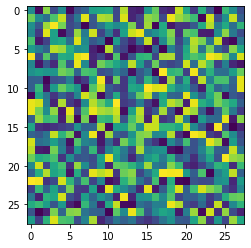

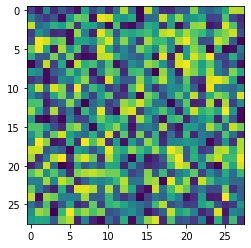

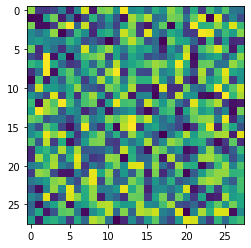

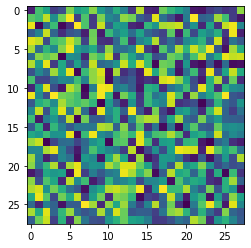

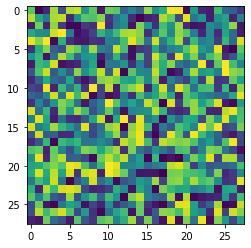

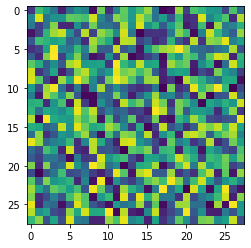

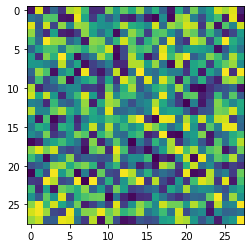

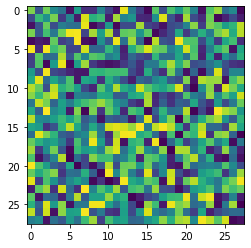

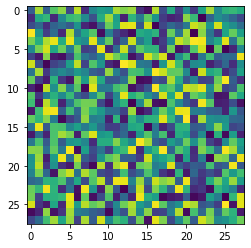

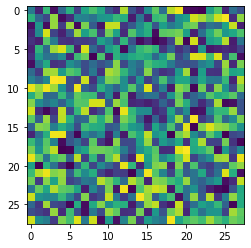

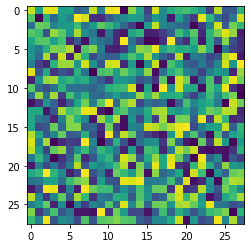

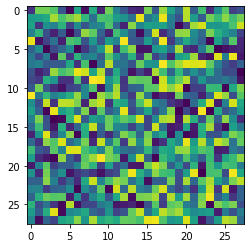

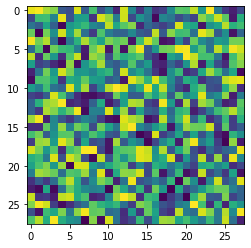

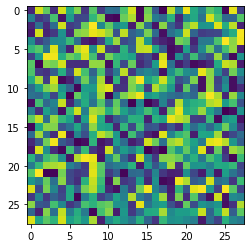

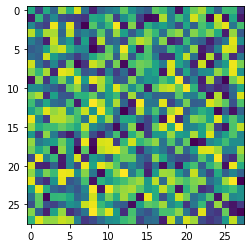

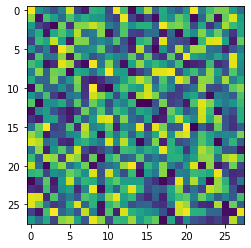

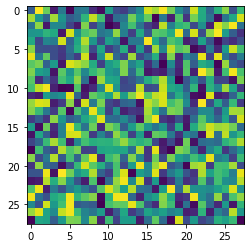

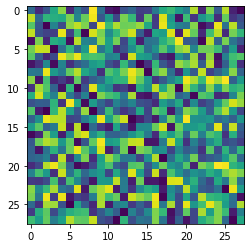

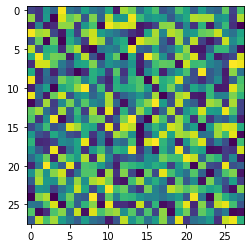

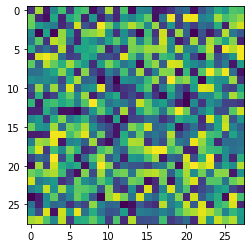

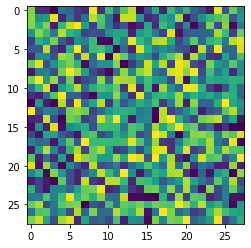

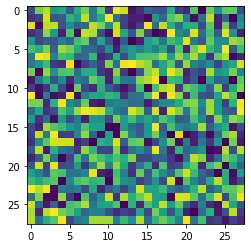

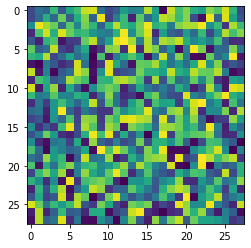

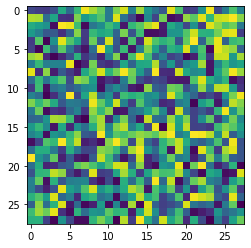

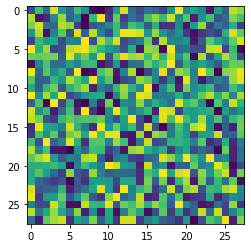

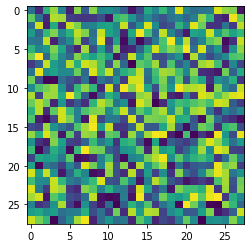

In [49]:
W=fc.lin1.weight.data
visualize_fields(W)

For binary discrimination tasks, we used {−1, +1} output for the two classes. 

## DATA
non-Gaussian, higher-order local structure
of the inputs,


math.erf(x)


$\epsilon^{-}=2.8$


$\epsilon^{+}=5.6$

In [178]:
import numpy as np
# define functions
vec_erf = np.vectorize(math.erf)
psi = lambda z: vec_erf(z/(np.sqrt(2)))

gain_factor=5
normalizer = np.sqrt(2/np.pi * np.arcsin(gain_factor**2/(1+gain_factor**2)))
epsilon_plus=5.6
epsilon_minus=1
mean_vector = np.zeros(28)
positive_cov_matrix = np.ones((28,28))
negative_cov_matrix = np.ones((28,28))

# Generate a random vector
#random_vector = np.random.multivariate_normal(mean_vector, cov_matrix)

In [179]:
for i in range(28):
    for j in range(28):
        positive_cov_matrix[i,j] = np.exp(- ( np.abs(i-j) / epsilon_plus)**2 )
positive_cov_matrix=np.kron(positive_cov_matrix,positive_cov_matrix)

In [180]:
for i in range(28):
    for j in range(28):
        negative_cov_matrix[i,j] = np.exp(- ( np.abs(i-j) / epsilon_minus)**2 )
negative_cov_matrix=np.kron(negative_cov_matrix,negative_cov_matrix)

In [181]:
def get_positive_example():
    z_mu = np.random.multivariate_normal(np.ones(784), positive_cov_matrix,10000)
    nlgp_z = psi(gain_factor * z_mu)/normalizer
    return nlgp_z

In [182]:
def get_negative_example():
    z_mu = np.random.multivariate_normal(np.ones(784), negative_cov_matrix,10000)
    nlgp_z = psi(gain_factor * z_mu)/normalizer
    return nlgp_z

In [183]:
negative_dataset = get_negative_example()
positive_dataset = get_positive_example()

In [184]:
dataset = torch.from_numpy(np.vstack([negative_dataset, positive_dataset]).astype(np.float32))

In [185]:
dataset_labels = torch.from_numpy(np.array([-1]*10000 + [1]*10000).astype('float32'))

In [186]:
def batch_sample(n):
    rand_ids = torch.randint(0, dataset.shape[0], (n,))
    inputs = dataset[rand_ids]
    labs = dataset_labels[rand_ids]
    return inputs,labs

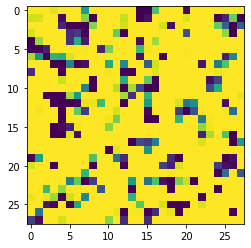

In [187]:
plt.imshow(dataset[0].reshape(28, 28))

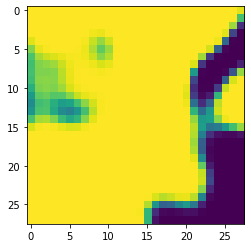

In [188]:
plt.imshow(dataset[15000].reshape(28, 28))

## Train the net: 

In [189]:
fc = FCN()

In [190]:
mse = torch.nn.MSELoss()
optimizer = torch.optim.SGD(fc.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(fc.parameters(), lr=0.001)
num_epochs = 10000

In [191]:
for epoch in tqdm(range(num_epochs)):
    
    inputs, labels = batch_sample(1000)
    out = fc(inputs)
    loss = mse(out.squeeze(), labels)
    
    ## Backwards pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'MSE is {loss}\n')
print('Finished Training')








  0%|                                                                                                                                          | 0/10000 [00:00<?, ?it/s]






  0%|▎                                                                                                                               | 20/10000 [00:00<00:52, 189.70it/s]

MSE is 1.2446144819259644

MSE is 1.071117877960205

MSE is 1.0179493427276611

MSE is 1.1162916421890259

MSE is 1.2478086948394775

MSE is 1.0812952518463135

MSE is 1.003495216369629

MSE is 1.0871084928512573

MSE is 1.1525143384933472

MSE is 1.1091892719268799

MSE is 1.0013865232467651

MSE is 1.0287271738052368

MSE is 1.1432386636734009

MSE is 1.0756975412368774

MSE is 1.0104504823684692

MSE is 1.0014287233352661

MSE is 1.027793288230896

MSE is 1.0773658752441406

MSE is 1.0213630199432373

MSE is 1.0027225017547607

MSE is 0.9999679923057556

MSE is 1.0148545503616333

MSE is 1.0170061588287354

MSE is 1.0222671031951904

MSE is 1.0048084259033203

MSE is 0.9993844628334045

MSE is 0.9977529048919678

MSE is 1.0133988857269287

MSE is 1.0242805480957031

MSE is 1.0107080936431885

MSE is 0.9995778799057007

MSE is 0.9994267225265503

MSE is 0.9942803382873535

MSE is 1.024106740951538

MSE is 1.0095945596694946










  0%|▌                                                                                                                               | 41/10000 [00:00<00:51, 192.82it/s]






  1%|▊                                                                                                                               | 65/10000 [00:00<00:48, 203.69it/s]

MSE is 0.9990866184234619

MSE is 0.9987050890922546

MSE is 1.0007926225662231

MSE is 1.0008670091629028

MSE is 0.9994992613792419

MSE is 0.9979420900344849

MSE is 1.0080147981643677

MSE is 1.0125572681427002

MSE is 1.0062974691390991

MSE is 0.9973179697990417

MSE is 1.0092018842697144

MSE is 1.0153555870056152

MSE is 1.0165209770202637

MSE is 1.0002180337905884

MSE is 1.000282883644104

MSE is 0.9991440773010254

MSE is 1.0024042129516602

MSE is 1.0051974058151245

MSE is 1.0048383474349976

MSE is 1.0000027418136597

MSE is 0.9986283183097839

MSE is 1.0008372068405151

MSE is 1.001011610031128

MSE is 1.004624366760254

MSE is 1.0028598308563232

MSE is 0.9972655177116394

MSE is 0.997180163860321

MSE is 0.9981979131698608

MSE is 1.0010539293289185

MSE is 0.9982625842094421

MSE is 0.9988806843757629

MSE is 0.9955416321754456

MSE is 0.9962130784988403

MSE is 0.9949671626091003

MSE is 1.0023428201675415

MSE is 1.0071139335632324

MSE is 0.9991729259490967

MSE i








  1%|█                                                                                                                               | 86/10000 [00:00<00:48, 203.47it/s]






  1%|█▍                                                                                                                             | 109/10000 [00:00<00:47, 209.69it/s]

MSE is 1.001286268234253

MSE is 0.9933251738548279

MSE is 0.9959263205528259

MSE is 0.995197057723999

MSE is 0.9994614124298096

MSE is 1.0018750429153442

MSE is 0.9943627715110779

MSE is 0.9946917295455933

MSE is 0.9955843687057495

MSE is 0.9966568350791931

MSE is 0.9994652271270752

MSE is 0.9932558536529541

MSE is 0.991897702217102

MSE is 0.9926363229751587

MSE is 0.9963580369949341

MSE is 0.9962827563285828

MSE is 0.9956555962562561

MSE is 0.9948394894599915

MSE is 0.9890944957733154

MSE is 0.9948567152023315

MSE is 0.9983558058738708

MSE is 0.9938735961914062

MSE is 0.9933034181594849

MSE is 0.9939413070678711

MSE is 0.9945115447044373

MSE is 0.9922671914100647

MSE is 0.9926698803901672

MSE is 0.9912691116333008

MSE is 0.9903852343559265

MSE is 0.9940630197525024

MSE is 0.9916616678237915

MSE is 0.9928417801856995

MSE is 0.9899041652679443

MSE is 0.9902501702308655

MSE is 0.9929473996162415

MSE is 0.9881628155708313

MSE is 0.9919772148132324

MSE 








  1%|█▋                                                                                                                             | 131/10000 [00:00<00:46, 211.01it/s]






  2%|█▉                                                                                                                             | 155/10000 [00:00<00:45, 217.70it/s]

MSE is 0.9998002052307129

MSE is 0.9877389073371887

MSE is 0.9878979325294495

MSE is 0.987214982509613

MSE is 0.9924927949905396

MSE is 0.9904671311378479

MSE is 0.99269700050354

MSE is 0.9852834343910217

MSE is 0.9822606444358826

MSE is 0.987616777420044

MSE is 0.9903383851051331

MSE is 0.9844592213630676

MSE is 0.9850811958312988

MSE is 0.9841996431350708

MSE is 0.9873813986778259

MSE is 0.9817603230476379

MSE is 0.985946774482727

MSE is 0.9823259115219116

MSE is 0.9844443202018738

MSE is 0.9765949845314026

MSE is 0.9836254119873047

MSE is 0.9825668931007385

MSE is 0.9835251569747925

MSE is 0.9785935282707214

MSE is 0.976452648639679

MSE is 0.976984977722168

MSE is 0.9845023155212402

MSE is 0.9725932478904724

MSE is 0.9768200516700745

MSE is 0.977649986743927

MSE is 0.9669398069381714

MSE is 0.9707152247428894

MSE is 0.9665877819061279

MSE is 0.9710685014724731

MSE is 0.9781175255775452

MSE is 0.9740639328956604

MSE is 0.9634574055671692

MSE is 0.








  2%|██▎                                                                                                                            | 179/10000 [00:00<00:44, 221.51it/s]








MSE is 0.9603758454322815

MSE is 0.9558925628662109

MSE is 0.9582040905952454

MSE is 0.9621073007583618

MSE is 0.9576478600502014

MSE is 0.9572823643684387

MSE is 0.9542245864868164

MSE is 0.9567010998725891

MSE is 0.9480517506599426

MSE is 0.9524494409561157

MSE is 0.9497267603874207

MSE is 0.9385801553726196

MSE is 0.9493080973625183

MSE is 0.9293007254600525

MSE is 0.948318600654602

MSE is 0.9439995288848877

MSE is 0.9435681104660034

MSE is 0.9301340579986572

MSE is 0.933332622051239

MSE is 0.9246777296066284

MSE is 0.9326280355453491

MSE is 0.9300772547721863

MSE is 0.9270824790000916

MSE is 0.9370276927947998

MSE is 0.92481529712677

MSE is 0.9158726930618286

MSE is 0.919209361076355

MSE is 0.9265041947364807

MSE is 0.917916476726532

MSE is 0.9071521759033203

MSE is 0.9090728759765625

MSE is 0.8955656290054321

MSE is 0.8930809497833252

MSE is 0.9139948487281799

MSE is 0.8988679051399231

MSE is 0.8991528749465942

MSE is 0.8893876075744629

MSE is 

  2%|██▌                                                                                                                            | 204/10000 [00:00<00:43, 227.06it/s]






  2%|██▉                                                                                                                            | 229/10000 [00:01<00:42, 230.71it/s]

MSE is 0.8884751796722412

MSE is 0.8732255697250366

MSE is 0.8602406978607178

MSE is 0.8749063611030579

MSE is 0.8560178875923157

MSE is 0.8487401604652405

MSE is 0.8660157918930054

MSE is 0.8586530089378357

MSE is 0.8536418080329895

MSE is 0.8355135321617126

MSE is 0.8421998620033264

MSE is 0.8375479578971863

MSE is 0.8437075018882751

MSE is 0.8339996337890625

MSE is 0.8205183744430542

MSE is 0.8157728910446167

MSE is 0.8214564919471741

MSE is 0.8079256415367126

MSE is 0.8157128691673279

MSE is 0.806035578250885

MSE is 0.7961293458938599

MSE is 0.7938908934593201

MSE is 0.7844035029411316

MSE is 0.7780545949935913

MSE is 0.7875021696090698

MSE is 0.7879022359848022

MSE is 0.7614641785621643

MSE is 0.7703326344490051

MSE is 0.7756205201148987

MSE is 0.7629100680351257

MSE is 0.7608198523521423

MSE is 0.7500509023666382

MSE is 0.7464752197265625

MSE is 0.7452296018600464

MSE is 0.735435426235199

MSE is 0.7297604084014893

MSE is 0.7343775033950806

MSE








  3%|███▏                                                                                                                           | 253/10000 [00:01<00:42, 230.38it/s]






  3%|███▌                                                                                                                           | 276/10000 [00:01<00:42, 229.68it/s]

MSE is 0.6690157055854797

MSE is 0.6800965666770935

MSE is 0.6620686650276184

MSE is 0.658136248588562

MSE is 0.6479233503341675

MSE is 0.6521950364112854

MSE is 0.6550650000572205

MSE is 0.6352456212043762

MSE is 0.6325126886367798

MSE is 0.6412094235420227

MSE is 0.6236843466758728

MSE is 0.6183591485023499

MSE is 0.609571099281311

MSE is 0.6086937189102173

MSE is 0.5906594395637512

MSE is 0.598034679889679

MSE is 0.5861794948577881

MSE is 0.6030436158180237

MSE is 0.5714735388755798

MSE is 0.5795283913612366

MSE is 0.5713832378387451

MSE is 0.5693988800048828

MSE is 0.5481145977973938

MSE is 0.5549037456512451

MSE is 0.5711246132850647

MSE is 0.5058757066726685

MSE is 0.5341412425041199

MSE is 0.5368468761444092

MSE is 0.5315621495246887

MSE is 0.5173429250717163

MSE is 0.5032583475112915

MSE is 0.5089995861053467

MSE is 0.5011464357376099

MSE is 0.4995255768299103

MSE is 0.5022444128990173

MSE is 0.49331170320510864

MSE is 0.494471937417984

MSE 








  3%|███▊                                                                                                                           | 299/10000 [00:01<00:42, 226.89it/s]






  3%|████                                                                                                                           | 322/10000 [00:01<00:42, 225.25it/s]

MSE is 0.44703054428100586

MSE is 0.43192094564437866

MSE is 0.4477507770061493

MSE is 0.44143861532211304

MSE is 0.4524845778942108

MSE is 0.4287686049938202

MSE is 0.45065444707870483

MSE is 0.42918217182159424

MSE is 0.44564148783683777

MSE is 0.42108336091041565

MSE is 0.42346879839897156

MSE is 0.3876124322414398

MSE is 0.41844817996025085

MSE is 0.40163686871528625

MSE is 0.3945750296115875

MSE is 0.4111027121543884

MSE is 0.3939031958580017

MSE is 0.37120944261550903

MSE is 0.37647193670272827

MSE is 0.37131550908088684

MSE is 0.38437655568122864

MSE is 0.39276617765426636

MSE is 0.35043254494667053

MSE is 0.38018402457237244

MSE is 0.3586884140968323

MSE is 0.3595210313796997

MSE is 0.3575073182582855

MSE is 0.3471093475818634

MSE is 0.3594258725643158

MSE is 0.34558162093162537

MSE is 0.35209450125694275

MSE is 0.34857991337776184

MSE is 0.3324686586856842

MSE is 0.3463424742221832

MSE is 0.32859665155410767

MSE is 0.341834157705307

MSE is 0








  3%|████▍                                                                                                                          | 346/10000 [00:01<00:42, 227.62it/s]






  4%|████▋                                                                                                                          | 370/10000 [00:01<00:41, 230.03it/s]

MSE is 0.31826868653297424

MSE is 0.308834046125412

MSE is 0.3127376437187195

MSE is 0.30571117997169495

MSE is 0.32282719016075134

MSE is 0.2946826219558716

MSE is 0.3057232201099396

MSE is 0.3220495581626892

MSE is 0.3128564953804016

MSE is 0.28785240650177

MSE is 0.31744977831840515

MSE is 0.3030499517917633

MSE is 0.3063803017139435

MSE is 0.3058730959892273

MSE is 0.3093213737010956

MSE is 0.29445692896842957

MSE is 0.2914360463619232

MSE is 0.29400280117988586

MSE is 0.2860887348651886

MSE is 0.28240257501602173

MSE is 0.2998168170452118

MSE is 0.27217409014701843

MSE is 0.2840989828109741

MSE is 0.27026864886283875

MSE is 0.2794560194015503

MSE is 0.27058008313179016

MSE is 0.2838556170463562

MSE is 0.2786261737346649

MSE is 0.27933260798454285

MSE is 0.2759353220462799

MSE is 0.26172757148742676

MSE is 0.266726016998291

MSE is 0.2656724154949188

MSE is 0.27045395970344543

MSE is 0.2543010115623474

MSE is 0.27739930152893066

MSE is 0.275451838








  4%|████▉                                                                                                                          | 393/10000 [00:01<00:42, 227.28it/s]






  4%|█████▎                                                                                                                         | 417/10000 [00:01<00:41, 229.72it/s]

MSE is 0.2660149335861206

MSE is 0.25535184144973755

MSE is 0.25143077969551086

MSE is 0.22528035938739777

MSE is 0.24798987805843353

MSE is 0.2580280900001526

MSE is 0.24348801374435425

MSE is 0.2624211311340332

MSE is 0.26319971680641174

MSE is 0.24854472279548645

MSE is 0.2555657625198364

MSE is 0.2399601936340332

MSE is 0.247539684176445

MSE is 0.24219490587711334

MSE is 0.25456854701042175

MSE is 0.2376587837934494

MSE is 0.2549862861633301

MSE is 0.23015525937080383

MSE is 0.2366948127746582

MSE is 0.24462459981441498

MSE is 0.2536787688732147

MSE is 0.22026142477989197

MSE is 0.25017958879470825

MSE is 0.23011043667793274

MSE is 0.23244743049144745

MSE is 0.23470944166183472

MSE is 0.2341894805431366

MSE is 0.22173196077346802

MSE is 0.2313942313194275

MSE is 0.23024392127990723

MSE is 0.23055775463581085

MSE is 0.21079152822494507

MSE is 0.22441338002681732

MSE is 0.26230522990226746

MSE is 0.2145647257566452

MSE is 0.2368490844964981

MSE is 








  4%|█████▌                                                                                                                         | 441/10000 [00:01<00:41, 231.43it/s]

MSE is 0.22869336605072021

MSE is 0.2201784998178482

MSE is 0.22954055666923523

MSE is 0.2082722932100296

MSE is 0.22946684062480927

MSE is 0.21510618925094604

MSE is 0.2309270054101944

MSE is 0.21737168729305267

MSE is 0.20816202461719513

MSE is 0.22235751152038574

MSE is 0.19878220558166504

MSE is 0.21724273264408112

MSE is 0.23135632276535034

MSE is 0.20336219668388367

MSE is 0.2180163860321045

MSE is 0.20892849564552307

MSE is 0.19686147570610046

MSE is 0.2126598060131073

MSE is 0.21974433958530426

MSE is 0.2061399221420288

MSE is 0.19880492985248566

MSE is 0.21178412437438965

MSE is 0.20328019559383392

MSE is 0.20952589809894562

MSE is 0.20528241991996765

MSE is 0.2064252644777298

MSE is 0.190766841173172

MSE is 0.20462383329868317

MSE is 0.21066108345985413

MSE is 0.19822295010089874

MSE is 0.19540731608867645

MSE is 0.21211645007133484

MSE is 0.2039034515619278

MSE is 0.20383810997009277

MSE is 0.2025628685951233

MSE is 0.20624785125255585

MSE








  5%|█████▉                                                                                                                         | 466/10000 [00:02<00:40, 233.87it/s]






  5%|██████▏                                                                                                                        | 490/10000 [00:02<00:41, 231.18it/s]

MSE is 0.2053324580192566

MSE is 0.1989826261997223

MSE is 0.19028951227664948

MSE is 0.20508889853954315

MSE is 0.1915152370929718

MSE is 0.21024130284786224

MSE is 0.203128382563591

MSE is 0.2036321610212326

MSE is 0.17715898156166077

MSE is 0.1862296760082245

MSE is 0.1911826729774475

MSE is 0.19441506266593933

MSE is 0.19565880298614502

MSE is 0.19215497374534607

MSE is 0.18614742159843445

MSE is 0.19328206777572632

MSE is 0.17855499684810638

MSE is 0.19462428987026215

MSE is 0.1989189237356186

MSE is 0.19576776027679443

MSE is 0.18301087617874146

MSE is 0.1853940784931183

MSE is 0.1959398090839386

MSE is 0.19344905018806458

MSE is 0.18865038454532623

MSE is 0.17653071880340576

MSE is 0.1856786459684372

MSE is 0.19190725684165955

MSE is 0.17914459109306335

MSE is 0.16245245933532715

MSE is 0.18487174808979034

MSE is 0.17158706486225128

MSE is 0.20095789432525635

MSE is 0.1828533560037613

MSE is 0.18449187278747559

MSE is 0.16816696524620056

MSE i








  5%|██████▌                                                                                                                        | 514/10000 [00:02<00:40, 231.46it/s]






  5%|██████▊                                                                                                                        | 538/10000 [00:02<00:41, 230.40it/s]

MSE is 0.1822366863489151

MSE is 0.16974703967571259

MSE is 0.1768818497657776

MSE is 0.16703058779239655

MSE is 0.1717367023229599

MSE is 0.16822151839733124

MSE is 0.16971254348754883

MSE is 0.1765238493680954

MSE is 0.17953790724277496

MSE is 0.1815193146467209

MSE is 0.18417516350746155

MSE is 0.17189522087574005

MSE is 0.1678682267665863

MSE is 0.1605980545282364

MSE is 0.1723281592130661

MSE is 0.1657528430223465

MSE is 0.1799333393573761

MSE is 0.16668175160884857

MSE is 0.1620865911245346

MSE is 0.1675441563129425

MSE is 0.1795361489057541

MSE is 0.1701117753982544

MSE is 0.1459304690361023

MSE is 0.15876032412052155

MSE is 0.1729644238948822

MSE is 0.16511444747447968

MSE is 0.16600750386714935

MSE is 0.16846726834774017

MSE is 0.16301444172859192

MSE is 0.17201699316501617

MSE is 0.17050829529762268

MSE is 0.15757586061954498

MSE is 0.16712194681167603

MSE is 0.1638920158147812

MSE is 0.1789684146642685

MSE is 0.17993338406085968

MSE is 0.1








  6%|███████▏                                                                                                                       | 562/10000 [00:02<00:41, 229.09it/s]






  6%|███████▍                                                                                                                       | 587/10000 [00:02<00:40, 233.16it/s]

MSE is 0.155446857213974

MSE is 0.1560211181640625

MSE is 0.1588256061077118

MSE is 0.15533773601055145

MSE is 0.1496124267578125

MSE is 0.16271287202835083

MSE is 0.1514272540807724

MSE is 0.1534281224012375

MSE is 0.1648104041814804

MSE is 0.16007311642169952

MSE is 0.15569771826267242

MSE is 0.1607956439256668

MSE is 0.15455079078674316

MSE is 0.161623015999794

MSE is 0.14844173192977905

MSE is 0.15258508920669556

MSE is 0.14095820486545563

MSE is 0.15989723801612854

MSE is 0.15894480049610138

MSE is 0.16566194593906403

MSE is 0.1513357013463974

MSE is 0.16219985485076904

MSE is 0.16000328958034515

MSE is 0.15679660439491272

MSE is 0.14419826865196228

MSE is 0.16019825637340546

MSE is 0.15978410840034485

MSE is 0.15408118069171906

MSE is 0.14582805335521698

MSE is 0.15769264101982117

MSE is 0.17072543501853943

MSE is 0.14629626274108887

MSE is 0.15733829140663147

MSE is 0.14452572166919708

MSE is 0.15185806155204773

MSE is 0.14095640182495117

MSE 








  6%|███████▊                                                                                                                       | 611/10000 [00:02<00:41, 228.90it/s]








MSE is 0.14277346432209015

MSE is 0.15093107521533966

MSE is 0.1580885350704193

MSE is 0.15095621347427368

MSE is 0.14361992478370667

MSE is 0.13533064723014832

MSE is 0.13098666071891785

MSE is 0.15771804749965668

MSE is 0.1411575973033905

MSE is 0.13850748538970947

MSE is 0.14753873646259308

MSE is 0.1558663547039032

MSE is 0.14295774698257446

MSE is 0.13335905969142914

MSE is 0.14938680827617645

MSE is 0.14267951250076294

MSE is 0.14567409455776215

MSE is 0.15003927052021027

MSE is 0.13179315626621246

MSE is 0.13760416209697723

MSE is 0.14118711650371552

MSE is 0.14346186816692352

MSE is 0.1434781402349472

MSE is 0.1511468142271042

MSE is 0.13423122465610504

MSE is 0.15261279046535492

MSE is 0.142389714717865

MSE is 0.15813586115837097

MSE is 0.16162629425525665

MSE is 0.13288924098014832

MSE is 0.1520199328660965

MSE is 0.14028416574001312

MSE is 0.1425011157989502

MSE is 0.14978891611099243

MSE is 0.1362558752298355

MSE is 0.14065337181091309

MS

  6%|████████                                                                                                                       | 636/10000 [00:02<00:40, 232.03it/s]






  7%|████████▍                                                                                                                      | 660/10000 [00:02<00:40, 231.17it/s]

MSE is 0.14995506405830383

MSE is 0.13954700529575348

MSE is 0.13033032417297363

MSE is 0.14469505846500397

MSE is 0.14539581537246704

MSE is 0.13985727727413177

MSE is 0.14006753265857697

MSE is 0.1428079456090927

MSE is 0.1309983730316162

MSE is 0.13082018494606018

MSE is 0.14757868647575378

MSE is 0.1376727670431137

MSE is 0.1346445530653

MSE is 0.1378518044948578

MSE is 0.1267949491739273

MSE is 0.1457768678665161

MSE is 0.12876959145069122

MSE is 0.1342269480228424

MSE is 0.14010365307331085

MSE is 0.12478920072317123

MSE is 0.13697560131549835

MSE is 0.13405372202396393

MSE is 0.13215084373950958

MSE is 0.12902797758579254

MSE is 0.13753966987133026

MSE is 0.12477777153253555

MSE is 0.14397604763507843

MSE is 0.13659542798995972

MSE is 0.13692046701908112

MSE is 0.1344752311706543

MSE is 0.13255834579467773

MSE is 0.12779588997364044

MSE is 0.13737045228481293

MSE is 0.14161524176597595

MSE is 0.1313600242137909

MSE is 0.1344500035047531

MSE is








  7%|████████▋                                                                                                                      | 684/10000 [00:03<00:39, 233.20it/s]






  7%|████████▉                                                                                                                      | 708/10000 [00:03<00:40, 231.93it/s]

MSE is 0.13339143991470337

MSE is 0.13216891884803772

MSE is 0.13301031291484833

MSE is 0.1283697485923767

MSE is 0.13047002255916595

MSE is 0.12414250522851944

MSE is 0.1238376721739769

MSE is 0.1216268464922905

MSE is 0.1269408017396927

MSE is 0.13297590613365173

MSE is 0.1327899545431137

MSE is 0.12456910312175751

MSE is 0.1272927224636078

MSE is 0.1282106190919876

MSE is 0.12328760325908661

MSE is 0.11529308557510376

MSE is 0.12820513546466827

MSE is 0.12901747226715088

MSE is 0.13375939428806305

MSE is 0.12918362021446228

MSE is 0.11997733265161514

MSE is 0.1215931624174118

MSE is 0.12123046070337296

MSE is 0.12427514046430588

MSE is 0.12326499074697495

MSE is 0.12256132066249847

MSE is 0.11589333415031433

MSE is 0.12197684496641159

MSE is 0.12099406868219376

MSE is 0.12764759361743927

MSE is 0.12162777781486511

MSE is 0.1378919929265976

MSE is 0.11639618128538132

MSE is 0.12742561101913452

MSE is 0.13435333967208862

MSE is 0.12397129088640213

M








  7%|█████████▎                                                                                                                     | 732/10000 [00:03<00:40, 229.71it/s]






  8%|█████████▌                                                                                                                     | 756/10000 [00:03<00:40, 230.84it/s]

MSE is 0.12265083193778992

MSE is 0.12397678196430206

MSE is 0.1269092559814453

MSE is 0.13046173751354218

MSE is 0.12430863827466965

MSE is 0.13478878140449524

MSE is 0.12230584025382996

MSE is 0.12455500662326813

MSE is 0.13579070568084717

MSE is 0.1331986039876938

MSE is 0.1263558268547058

MSE is 0.12753954529762268

MSE is 0.12670594453811646

MSE is 0.13569124042987823

MSE is 0.12361070513725281

MSE is 0.14162592589855194

MSE is 0.1167542040348053

MSE is 0.13152608275413513

MSE is 0.12767450511455536

MSE is 0.11735595017671585

MSE is 0.1322212517261505

MSE is 0.12614478170871735

MSE is 0.1430412232875824

MSE is 0.12903329730033875

MSE is 0.1219562292098999

MSE is 0.12947824597358704

MSE is 0.11069074273109436

MSE is 0.13239669799804688

MSE is 0.123853899538517

MSE is 0.11620686948299408

MSE is 0.1352628469467163

MSE is 0.1285187005996704

MSE is 0.12454518675804138

MSE is 0.11507150530815125

MSE is 0.11706341058015823

MSE is 0.124493308365345

MSE i








  8%|█████████▉                                                                                                                     | 780/10000 [00:03<00:40, 229.31it/s]






  8%|██████████▏                                                                                                                    | 804/10000 [00:03<00:39, 230.73it/s]

MSE is 0.1072554811835289

MSE is 0.11923450976610184

MSE is 0.11788039654493332

MSE is 0.10519607365131378

MSE is 0.11959986388683319

MSE is 0.12783652544021606

MSE is 0.1113365963101387

MSE is 0.10555985569953918

MSE is 0.11474048346281052

MSE is 0.11478415131568909

MSE is 0.10334967821836472

MSE is 0.11069311201572418

MSE is 0.11977055668830872

MSE is 0.12527579069137573

MSE is 0.11332588642835617

MSE is 0.11343462020158768

MSE is 0.12255258113145828

MSE is 0.10342257469892502

MSE is 0.13090462982654572

MSE is 0.12336216121912003

MSE is 0.12691998481750488

MSE is 0.11782797425985336

MSE is 0.11398953944444656

MSE is 0.13405026495456696

MSE is 0.12262782454490662

MSE is 0.1130954772233963

MSE is 0.13369368016719818

MSE is 0.14382165670394897

MSE is 0.12294390797615051

MSE is 0.1294630765914917

MSE is 0.11570240557193756

MSE is 0.12255095690488815

MSE is 0.12601156532764435

MSE is 0.1122451201081276

MSE is 0.12893164157867432

MSE is 0.1184721067547798








  8%|██████████▌                                                                                                                    | 828/10000 [00:03<00:39, 230.91it/s]






  9%|██████████▊                                                                                                                    | 852/10000 [00:03<00:39, 232.06it/s]

MSE is 0.11888538300991058

MSE is 0.11212852597236633

MSE is 0.11608724296092987

MSE is 0.11186917871236801

MSE is 0.11402518302202225

MSE is 0.11522500962018967

MSE is 0.11382318288087845

MSE is 0.12020361423492432

MSE is 0.10394294559955597

MSE is 0.11088254302740097

MSE is 0.11401191353797913

MSE is 0.10437781363725662

MSE is 0.11533243954181671

MSE is 0.10662142932415009

MSE is 0.11179247498512268

MSE is 0.11932697147130966

MSE is 0.1050354614853859

MSE is 0.12352017313241959

MSE is 0.11223360896110535

MSE is 0.12096412479877472

MSE is 0.12740269303321838

MSE is 0.11686504632234573

MSE is 0.10368333011865616

MSE is 0.11687292158603668

MSE is 0.11483470350503922

MSE is 0.12130740284919739

MSE is 0.10172903537750244

MSE is 0.10904833674430847

MSE is 0.10907873511314392

MSE is 0.1111864298582077

MSE is 0.11721665412187576

MSE is 0.12368877977132797

MSE is 0.11604074388742447

MSE is 0.1381666660308838

MSE is 0.11757801473140717

MSE is 0.11547273397445








  9%|███████████▏                                                                                                                   | 876/10000 [00:03<00:39, 231.50it/s]

MSE is 0.10246256738901138

MSE is 0.10754889994859695

MSE is 0.10870378464460373

MSE is 0.11472806334495544

MSE is 0.10960220545530319

MSE is 0.10817322134971619

MSE is 0.11203668266534805

MSE is 0.10642974823713303

MSE is 0.12266740202903748

MSE is 0.11251284182071686

MSE is 0.1065191701054573

MSE is 0.11711890250444412

MSE is 0.09882591664791107

MSE is 0.11804326623678207

MSE is 0.09493720531463623

MSE is 0.1099734827876091

MSE is 0.10141164064407349

MSE is 0.10153385996818542

MSE is 0.11307065933942795

MSE is 0.10867097228765488

MSE is 0.10612958669662476

MSE is 0.1082502081990242

MSE is 0.10848560929298401

MSE is 0.10707368701696396

MSE is 0.11218144744634628

MSE is 0.10883578658103943

MSE is 0.11129821091890335

MSE is 0.13028369843959808

MSE is 0.0977400541305542

MSE is 0.11373521387577057

MSE is 0.12432383745908737

MSE is 0.09752190858125687

MSE is 0.10534948855638504

MSE is 0.09606459736824036

MSE is 0.1057218685746193

MSE is 0.1045148149132728








  9%|███████████▍                                                                                                                   | 900/10000 [00:03<00:39, 231.73it/s]






  9%|███████████▋                                                                                                                   | 924/10000 [00:04<00:39, 230.02it/s]

MSE is 0.1100577563047409

MSE is 0.11072222888469696

MSE is 0.0958736389875412

MSE is 0.11181195825338364

MSE is 0.1161012127995491

MSE is 0.11142989993095398

MSE is 0.10403713583946228

MSE is 0.10182603448629379

MSE is 0.124563068151474

MSE is 0.10053065419197083

MSE is 0.10138460993766785

MSE is 0.10601042956113815

MSE is 0.10686729848384857

MSE is 0.10731666535139084

MSE is 0.11496920883655548

MSE is 0.11273469030857086

MSE is 0.11096827685832977

MSE is 0.13100212812423706

MSE is 0.1042957752943039

MSE is 0.1043035238981247

MSE is 0.11367454379796982

MSE is 0.10451097041368484

MSE is 0.10345136374235153

MSE is 0.10461471229791641

MSE is 0.09835459291934967

MSE is 0.11568625271320343

MSE is 0.11671238392591476

MSE is 0.10767682641744614

MSE is 0.10059011727571487

MSE is 0.09884285926818848

MSE is 0.11027423292398453

MSE is 0.11393018066883087

MSE is 0.09328354895114899

MSE is 0.09896275401115417

MSE is 0.09850619733333588

MSE is 0.10171923041343689









  9%|████████████                                                                                                                   | 948/10000 [00:04<00:41, 219.94it/s]






 10%|████████████▎                                                                                                                  | 971/10000 [00:04<00:41, 218.54it/s]

MSE is 0.09607552736997604

MSE is 0.1000075414776802

MSE is 0.10190590471029282

MSE is 0.11138682812452316

MSE is 0.10572399944067001

MSE is 0.10973987728357315

MSE is 0.11916632205247879

MSE is 0.10776390135288239

MSE is 0.10286339372396469

MSE is 0.11127182096242905

MSE is 0.09395015984773636

MSE is 0.10632317513227463

MSE is 0.09492093324661255

MSE is 0.10638074576854706

MSE is 0.10312739759683609

MSE is 0.10256223380565643

MSE is 0.09953642636537552

MSE is 0.0956597626209259

MSE is 0.10866953432559967

MSE is 0.10752073675394058

MSE is 0.11400271207094193

MSE is 0.10272419452667236

MSE is 0.10611990839242935

MSE is 0.09917811304330826

MSE is 0.1070963442325592

MSE is 0.09736863523721695

MSE is 0.09585903584957123

MSE is 0.11334767937660217

MSE is 0.10806265473365784

MSE is 0.10608026385307312

MSE is 0.11075755208730698

MSE is 0.10446159541606903

MSE is 0.09879681468009949

MSE is 0.1044735237956047

MSE is 0.091876320540905

MSE is 0.09494203329086304








 10%|████████████▋                                                                                                                  | 995/10000 [00:04<00:40, 222.70it/s]






 10%|████████████▊                                                                                                                 | 1019/10000 [00:04<00:39, 226.03it/s]

MSE is 0.09501418471336365

MSE is 0.0919940322637558

MSE is 0.09520822018384933

MSE is 0.09044457226991653

MSE is 0.10116144269704819

MSE is 0.09416317939758301

MSE is 0.11328461021184921

MSE is 0.09557302296161652

MSE is 0.08561602979898453

MSE is 0.09285568445920944

MSE is 0.10384092479944229

MSE is 0.10476703196763992

MSE is 0.11388778686523438

MSE is 0.10037407279014587

MSE is 0.10720927268266678

MSE is 0.09556179493665695

MSE is 0.09358177334070206

MSE is 0.10156948119401932

MSE is 0.09367193281650543

MSE is 0.09855746477842331

MSE is 0.09803715348243713

MSE is 0.10080493241548538

MSE is 0.09925131499767303

MSE is 0.09539123624563217

MSE is 0.08973895013332367

MSE is 0.08894403278827667

MSE is 0.09530086070299149

MSE is 0.09521359205245972

MSE is 0.09204234182834625

MSE is 0.08469747006893158

MSE is 0.09967774897813797

MSE is 0.09865277260541916

MSE is 0.0934479683637619

MSE is 0.10780669748783112

MSE is 0.10513438284397125

MSE is 0.0986497178673








 10%|█████████████▏                                                                                                                | 1043/10000 [00:04<00:39, 228.02it/s]

MSE is 0.09957502037286758

MSE is 0.10378533601760864

MSE is 0.09871621429920197

MSE is 0.09694033861160278

MSE is 0.09058985859155655

MSE is 0.0963551253080368

MSE is 0.08484984189271927

MSE is 0.0928536131978035

MSE is 0.09956633299589157

MSE is 0.09549380093812943

MSE is 0.08701836317777634

MSE is 0.10271094739437103

MSE is 0.0935516506433487

MSE is 0.08760954439640045

MSE is 0.09505190700292587

MSE is 0.08416909724473953

MSE is 0.09640936553478241

MSE is 0.10847585648298264

MSE is 0.09716133773326874

MSE is 0.0865509882569313

MSE is 0.09905339032411575

MSE is 0.0913795754313469

MSE is 0.0926494374871254

MSE is 0.09906477481126785

MSE is 0.09870757162570953

MSE is 0.08823809772729874

MSE is 0.09928293526172638

MSE is 0.08640918135643005

MSE is 0.0876842811703682

MSE is 0.10015944391489029

MSE is 0.08926234394311905

MSE is 0.09826858341693878

MSE is 0.09886567294597626

MSE is 0.09519031643867493

MSE is 0.09442465752363205

MSE is 0.09911280870437622









 11%|█████████████▍                                                                                                                | 1067/10000 [00:04<00:38, 230.93it/s]






 11%|█████████████▋                                                                                                                | 1091/10000 [00:04<00:39, 228.38it/s]

MSE is 0.09661643952131271

MSE is 0.09112772345542908

MSE is 0.09682627767324448

MSE is 0.09721096605062485

MSE is 0.09739814698696136

MSE is 0.0898130014538765

MSE is 0.09257780760526657

MSE is 0.10189632326364517

MSE is 0.09037263691425323

MSE is 0.094877228140831

MSE is 0.10034170746803284

MSE is 0.10161113739013672

MSE is 0.08457353711128235

MSE is 0.09405504167079926

MSE is 0.1138569787144661

MSE is 0.10783489793539047

MSE is 0.0868043377995491

MSE is 0.10939648002386093

MSE is 0.123528391122818

MSE is 0.097382552921772

MSE is 0.08170284330844879

MSE is 0.0950678139925003

MSE is 0.08947081863880157

MSE is 0.09585527330636978

MSE is 0.11827987432479858

MSE is 0.08648409694433212

MSE is 0.09408292174339294

MSE is 0.13037127256393433

MSE is 0.10534468293190002

MSE is 0.10270983725786209

MSE is 0.13041411340236664

MSE is 0.10739416629076004

MSE is 0.08287031203508377

MSE is 0.10232952982187271

MSE is 0.09227150678634644

MSE is 0.0937337800860405

MSE








 11%|██████████████                                                                                                                | 1115/10000 [00:04<00:38, 228.92it/s]






 11%|██████████████▎                                                                                                               | 1139/10000 [00:05<00:38, 231.68it/s]

MSE is 0.0990336611866951

MSE is 0.08837877959012985

MSE is 0.0870269387960434

MSE is 0.08956290781497955

MSE is 0.08491392433643341

MSE is 0.10013408213853836

MSE is 0.08756788074970245

MSE is 0.08455738425254822

MSE is 0.08733163774013519

MSE is 0.08862224221229553

MSE is 0.08656857907772064

MSE is 0.10086319595575333

MSE is 0.08803081512451172

MSE is 0.09282347559928894

MSE is 0.09056434780359268

MSE is 0.08673455566167831

MSE is 0.08860985934734344

MSE is 0.09074246883392334

MSE is 0.08391690254211426

MSE is 0.08082635700702667

MSE is 0.08390013873577118

MSE is 0.09297411888837814

MSE is 0.08959141373634338

MSE is 0.09338564425706863

MSE is 0.08002103865146637

MSE is 0.08212962746620178

MSE is 0.08952725678682327

MSE is 0.08832923322916031

MSE is 0.08710574358701706

MSE is 0.08022616803646088

MSE is 0.08738253265619278

MSE is 0.08579321205615997

MSE is 0.09065872430801392

MSE is 0.08765807747840881

MSE is 0.09327174723148346

MSE is 0.0906133130192








 12%|██████████████▋                                                                                                               | 1163/10000 [00:05<00:37, 232.94it/s]






 12%|██████████████▉                                                                                                               | 1187/10000 [00:05<00:37, 233.46it/s]

MSE is 0.0823085755109787

MSE is 0.09431976079940796

MSE is 0.0879230722784996

MSE is 0.08648505061864853

MSE is 0.0888114869594574

MSE is 0.08724232017993927

MSE is 0.08812007308006287

MSE is 0.09402275830507278

MSE is 0.08576320111751556

MSE is 0.08432244509458542

MSE is 0.10180375725030899

MSE is 0.10226930677890778

MSE is 0.08781873434782028

MSE is 0.08366982638835907

MSE is 0.09470687806606293

MSE is 0.09893091022968292

MSE is 0.09403808414936066

MSE is 0.08496557176113129

MSE is 0.09359212964773178

MSE is 0.09237448871135712

MSE is 0.08351273834705353

MSE is 0.09449613094329834

MSE is 0.09829921275377274

MSE is 0.0928972139954567

MSE is 0.0866822674870491

MSE is 0.09833560883998871

MSE is 0.08049402385950089

MSE is 0.08498530834913254

MSE is 0.09427360445261002

MSE is 0.10419478267431259

MSE is 0.08226870745420456

MSE is 0.08470092713832855

MSE is 0.09585757553577423

MSE is 0.08625486493110657

MSE is 0.08905442804098129

MSE is 0.1079623848199844








 12%|███████████████▎                                                                                                              | 1211/10000 [00:05<00:38, 229.06it/s]






 12%|███████████████▌                                                                                                              | 1234/10000 [00:05<00:38, 228.82it/s]

MSE is 0.0914900153875351

MSE is 0.08085784316062927

MSE is 0.09784645587205887

MSE is 0.0964275375008583

MSE is 0.09148332476615906

MSE is 0.08738075941801071

MSE is 0.09449548274278641

MSE is 0.08002818375825882

MSE is 0.08759042620658875

MSE is 0.09087120741605759

MSE is 0.10345326364040375

MSE is 0.08548800647258759

MSE is 0.0811387374997139

MSE is 0.08616705238819122

MSE is 0.09039313346147537

MSE is 0.08986812084913254

MSE is 0.09769941866397858

MSE is 0.09724954515695572

MSE is 0.08143546432256699

MSE is 0.08003129810094833

MSE is 0.10176951438188553

MSE is 0.0837540253996849

MSE is 0.08517539501190186

MSE is 0.08948349952697754

MSE is 0.10380014777183533

MSE is 0.0867089331150055

MSE is 0.09075375646352768

MSE is 0.09182016551494598

MSE is 0.09419629722833633

MSE is 0.09693892300128937

MSE is 0.07848764955997467

MSE is 0.09157735854387283

MSE is 0.11789888143539429

MSE is 0.10099088400602341

MSE is 0.07718182355165482

MSE is 0.0911677926778793








 13%|███████████████▊                                                                                                              | 1257/10000 [00:05<00:38, 227.95it/s]








MSE is 0.07270435243844986

MSE is 0.09066781401634216

MSE is 0.08586569130420685

MSE is 0.08005918562412262

MSE is 0.07857825607061386

MSE is 0.0736183300614357

MSE is 0.09034756571054459

MSE is 0.08073927462100983

MSE is 0.08005216717720032

MSE is 0.08309313654899597

MSE is 0.08273657411336899

MSE is 0.07862978428602219

MSE is 0.07924462854862213

MSE is 0.08364906907081604

MSE is 0.08730724453926086

MSE is 0.08056721836328506

MSE is 0.08305676281452179

MSE is 0.0808645635843277

MSE is 0.07794886827468872

MSE is 0.08301432430744171

MSE is 0.08412060141563416

MSE is 0.08564858883619308

MSE is 0.08373326808214188

MSE is 0.08614151924848557

MSE is 0.092306949198246

MSE is 0.0835115984082222

MSE is 0.08181720972061157

MSE is 0.07861935347318649

MSE is 0.08478356897830963

MSE is 0.08489573001861572

MSE is 0.07732665538787842

MSE is 0.0829174816608429

MSE is 0.10300091654062271

MSE is 0.09274770319461823

MSE is 0.08099881559610367

MSE is 0.08002336323261261

 13%|████████████████▏                                                                                                             | 1281/10000 [00:05<00:37, 230.23it/s]






 13%|████████████████▍                                                                                                             | 1305/10000 [00:05<00:37, 230.59it/s]

MSE is 0.10198643803596497

MSE is 0.08174962550401688

MSE is 0.08763527125120163

MSE is 0.10731691122055054

MSE is 0.10380281507968903

MSE is 0.08913711458444595

MSE is 0.08000481128692627

MSE is 0.10958810895681381

MSE is 0.11394699662923813

MSE is 0.0971466675400734

MSE is 0.08100951462984085

MSE is 0.10394395142793655

MSE is 0.10280725359916687

MSE is 0.08754923194646835

MSE is 0.07877000421285629

MSE is 0.08617319166660309

MSE is 0.08768551051616669

MSE is 0.09297462552785873

MSE is 0.07787805050611496

MSE is 0.08331853896379471

MSE is 0.1043354719877243

MSE is 0.09339874237775803

MSE is 0.08037110418081284

MSE is 0.09539713710546494

MSE is 0.09969453513622284

MSE is 0.08530698716640472

MSE is 0.0753849595785141

MSE is 0.08939284831285477

MSE is 0.09775832295417786

MSE is 0.08785424381494522

MSE is 0.0835549607872963

MSE is 0.07640177011489868

MSE is 0.074835866689682

MSE is 0.07720068842172623

MSE is 0.08780010789632797

MSE is 0.08619524538516998








 13%|████████████████▋                                                                                                             | 1329/10000 [00:05<00:38, 227.75it/s]






 14%|█████████████████                                                                                                             | 1353/10000 [00:05<00:37, 229.52it/s]

MSE is 0.08090921491384506

MSE is 0.09312627464532852

MSE is 0.08983835577964783

MSE is 0.07839569449424744

MSE is 0.08254504203796387

MSE is 0.08975928276777267

MSE is 0.09029719233512878

MSE is 0.08660032600164413

MSE is 0.06936030834913254

MSE is 0.07562068104743958

MSE is 0.07516669481992722

MSE is 0.07260604202747345

MSE is 0.08032755553722382

MSE is 0.08026257902383804

MSE is 0.07786175608634949

MSE is 0.07981256395578384

MSE is 0.082503542304039

MSE is 0.07479450106620789

MSE is 0.07184094190597534

MSE is 0.0802764818072319

MSE is 0.07678063213825226

MSE is 0.07775822281837463

MSE is 0.07596474140882492

MSE is 0.07124827802181244

MSE is 0.06873036921024323

MSE is 0.08076982945203781

MSE is 0.08876737207174301

MSE is 0.09803172200918198

MSE is 0.09348040074110031

MSE is 0.07238680124282837

MSE is 0.0858062133193016

MSE is 0.0826653465628624

MSE is 0.07325369864702225

MSE is 0.07589007914066315

MSE is 0.08259373158216476

MSE is 0.0847511515021324








 14%|█████████████████▎                                                                                                            | 1376/10000 [00:06<00:38, 223.61it/s]






 14%|█████████████████▋                                                                                                            | 1399/10000 [00:06<00:39, 220.48it/s]

MSE is 0.07902703434228897

MSE is 0.09047091752290726

MSE is 0.07799214124679565

MSE is 0.07539405673742294

MSE is 0.07968588173389435

MSE is 0.07851912081241608

MSE is 0.07498710602521896

MSE is 0.07849183678627014

MSE is 0.07778827846050262

MSE is 0.0745844691991806

MSE is 0.07362128049135208

MSE is 0.08423109352588654

MSE is 0.07627113163471222

MSE is 0.07299111783504486

MSE is 0.07788117229938507

MSE is 0.07695651799440384

MSE is 0.07851596176624298

MSE is 0.07341088354587555

MSE is 0.08077870309352875

MSE is 0.08660946786403656

MSE is 0.09844119101762772

MSE is 0.09460869431495667

MSE is 0.07731105387210846

MSE is 0.0838298350572586

MSE is 0.0989687442779541

MSE is 0.08533336222171783

MSE is 0.07735318690538406

MSE is 0.07108738273382187

MSE is 0.07433091849088669

MSE is 0.08999823778867722

MSE is 0.09542873501777649

MSE is 0.0769515335559845

MSE is 0.07047365605831146

MSE is 0.07390891760587692

MSE is 0.08261680603027344

MSE is 0.077635481953620








 14%|█████████████████▉                                                                                                            | 1422/10000 [00:06<00:39, 219.39it/s]






 14%|██████████████████▏                                                                                                           | 1446/10000 [00:06<00:38, 223.05it/s]

MSE is 0.0750402882695198

MSE is 0.08197420090436935

MSE is 0.09463322907686234

MSE is 0.11143471300601959

MSE is 0.10480285435914993

MSE is 0.07535292208194733

MSE is 0.08678421378135681

MSE is 0.10972250252962112

MSE is 0.08859597891569138

MSE is 0.07020588964223862

MSE is 0.08180417120456696

MSE is 0.08933660387992859

MSE is 0.08680465072393417

MSE is 0.08261723071336746

MSE is 0.07824793457984924

MSE is 0.07402607798576355

MSE is 0.07408975064754486

MSE is 0.07608955353498459

MSE is 0.07469801604747772

MSE is 0.0837777704000473

MSE is 0.0779912918806076

MSE is 0.08305187523365021

MSE is 0.0830327495932579

MSE is 0.07774612307548523

MSE is 0.08934909850358963

MSE is 0.09448715299367905

MSE is 0.08217368274927139

MSE is 0.07252087444067001

MSE is 0.08722219616174698

MSE is 0.0892244428396225

MSE is 0.08593636751174927

MSE is 0.07570988684892654

MSE is 0.0859757661819458

MSE is 0.09924344718456268

MSE is 0.07777391374111176

MSE is 0.07674252986907959








 15%|██████████████████▌                                                                                                           | 1470/10000 [00:06<00:37, 226.75it/s]

MSE is 0.07648671418428421

MSE is 0.08300572633743286

MSE is 0.08003484457731247

MSE is 0.08113501220941544

MSE is 0.07048174738883972

MSE is 0.07763098925352097

MSE is 0.0765601173043251

MSE is 0.07404278218746185

MSE is 0.07808639854192734

MSE is 0.10382411628961563

MSE is 0.10636072605848312

MSE is 0.0776931643486023

MSE is 0.0755748525261879

MSE is 0.08280879259109497

MSE is 0.09042937308549881

MSE is 0.06943949311971664

MSE is 0.08024323731660843

MSE is 0.09951484948396683

MSE is 0.09105757623910904

MSE is 0.0729801207780838

MSE is 0.08106542378664017

MSE is 0.10225198417901993

MSE is 0.10050585120916367

MSE is 0.08026731759309769

MSE is 0.0664590448141098

MSE is 0.08207276463508606

MSE is 0.107410728931427

MSE is 0.09743735194206238

MSE is 0.09282186627388

MSE is 0.07724466919898987

MSE is 0.08641240000724792

MSE is 0.07707716524600983

MSE is 0.07500050216913223

MSE is 0.06960774213075638

MSE is 0.08264783024787903

MSE is 0.08956742286682129

MS








 15%|██████████████████▊                                                                                                           | 1495/10000 [00:06<00:36, 231.44it/s]






 15%|███████████████████▏                                                                                                          | 1519/10000 [00:06<00:36, 232.73it/s]

MSE is 0.08529217541217804

MSE is 0.06806296110153198

MSE is 0.06977652758359909

MSE is 0.07680565863847733

MSE is 0.0830109566450119

MSE is 0.06656331568956375

MSE is 0.06795719265937805

MSE is 0.07945387065410614

MSE is 0.07371548563241959

MSE is 0.07797324657440186

MSE is 0.06731536239385605

MSE is 0.07181701064109802

MSE is 0.07393116503953934

MSE is 0.07364650815725327

MSE is 0.07197940349578857

MSE is 0.07307315617799759

MSE is 0.08641864359378815

MSE is 0.09357491135597229

MSE is 0.07275513559579849

MSE is 0.07103391736745834

MSE is 0.09069105237722397

MSE is 0.10193806141614914

MSE is 0.09499423205852509

MSE is 0.07718958705663681

MSE is 0.07194885611534119

MSE is 0.09585799276828766

MSE is 0.1069217398762703

MSE is 0.08985687047243118

MSE is 0.07544595748186111

MSE is 0.11558935791254044

MSE is 0.1567336767911911

MSE is 0.1323663294315338

MSE is 0.08875302225351334

MSE is 0.07427740842103958

MSE is 0.09547736495733261

MSE is 0.104295395314693








 15%|███████████████████▍                                                                                                          | 1543/10000 [00:06<00:36, 233.12it/s]






 16%|███████████████████▋                                                                                                          | 1567/10000 [00:06<00:36, 234.02it/s]

MSE is 0.08038915693759918

MSE is 0.07329888641834259

MSE is 0.07585164159536362

MSE is 0.09349026530981064

MSE is 0.0946914553642273

MSE is 0.07048069685697556

MSE is 0.08549527078866959

MSE is 0.1398143470287323

MSE is 0.1141401007771492

MSE is 0.07571480423212051

MSE is 0.09324020892381668

MSE is 0.11662207543849945

MSE is 0.10601043701171875

MSE is 0.07921408116817474

MSE is 0.0725141167640686

MSE is 0.08670373260974884

MSE is 0.06889248639345169

MSE is 0.0718521773815155

MSE is 0.0719817504286766

MSE is 0.07484551519155502

MSE is 0.0641985610127449

MSE is 0.07033692300319672

MSE is 0.07962603121995926

MSE is 0.07047714293003082

MSE is 0.076421357691288

MSE is 0.0683601051568985

MSE is 0.06667987257242203

MSE is 0.07820867747068405

MSE is 0.07546418905258179

MSE is 0.08442268520593643

MSE is 0.06986381113529205

MSE is 0.06931863725185394

MSE is 0.0650968998670578

MSE is 0.08461853116750717

MSE is 0.0854552835226059

MSE is 0.08387567847967148

MSE 








 16%|████████████████████                                                                                                          | 1591/10000 [00:07<00:38, 216.51it/s]






 16%|████████████████████▎                                                                                                         | 1613/10000 [00:07<00:39, 212.32it/s]

MSE is 0.07406488060951233

MSE is 0.07137061655521393

MSE is 0.058763545006513596

MSE is 0.070218026638031

MSE is 0.07811643928289413

MSE is 0.07465853542089462

MSE is 0.07247359305620193

MSE is 0.06884285807609558

MSE is 0.06772851198911667

MSE is 0.07305282354354858

MSE is 0.06645584851503372

MSE is 0.06512314081192017

MSE is 0.07288869470357895

MSE is 0.07721418887376785

MSE is 0.07377622276544571

MSE is 0.06752777844667435

MSE is 0.06802471727132797

MSE is 0.0779055804014206

MSE is 0.07175014168024063

MSE is 0.0740445926785469

MSE is 0.07476251572370529

MSE is 0.08162740617990494

MSE is 0.07049496471881866

MSE is 0.07668507099151611

MSE is 0.08486617356538773

MSE is 0.09596271812915802

MSE is 0.08131171017885208

MSE is 0.06994947046041489

MSE is 0.0831751897931099

MSE is 0.11221351474523544

MSE is 0.11329561471939087

MSE is 0.08432934433221817

MSE is 0.07279065251350403

MSE is 0.07891819626092911

MSE is 0.08655855059623718

MSE is 0.088868558406829








 16%|████████████████████▌                                                                                                         | 1635/10000 [00:07<00:39, 211.71it/s]

MSE is 0.06872466951608658

MSE is 0.07985416054725647

MSE is 0.1364062875509262

MSE is 0.16343438625335693

MSE is 0.12488441169261932

MSE is 0.08272792398929596

MSE is 0.07674047350883484

MSE is 0.11140397936105728

MSE is 0.09949365258216858

MSE is 0.07635490596294403

MSE is 0.08512324839830399

MSE is 0.11264943331480026

MSE is 0.09604869782924652

MSE is 0.0736999362707138

MSE is 0.07584397494792938

MSE is 0.08692977577447891

MSE is 0.07019411772489548

MSE is 0.06436874717473984

MSE is 0.0707334354519844

MSE is 0.07346979528665543

MSE is 0.06278324872255325

MSE is 0.0684145838022232

MSE is 0.06647015362977982

MSE is 0.0682985708117485

MSE is 0.07142646610736847

MSE is 0.06988586485385895

MSE is 0.07014310359954834

MSE is 0.06672976166009903

MSE is 0.07292330265045166

MSE is 0.07517336308956146

MSE is 0.07315810024738312

MSE is 0.0691705122590065

MSE is 0.0853109285235405

MSE is 0.07614187151193619

MSE is 0.0690876916050911

MSE is 0.06891313195228577










 17%|████████████████████▉                                                                                                         | 1659/10000 [00:07<00:38, 218.05it/s]






 17%|█████████████████████▏                                                                                                        | 1681/10000 [00:07<00:38, 214.51it/s]

MSE is 0.07407527416944504

MSE is 0.06970518827438354

MSE is 0.07272545993328094

MSE is 0.06773479282855988

MSE is 0.07507842779159546

MSE is 0.07270695269107819

MSE is 0.06792590022087097

MSE is 0.06977448612451553

MSE is 0.06819550693035126

MSE is 0.06598792970180511

MSE is 0.06709535419940948

MSE is 0.07286543399095535

MSE is 0.06970712542533875

MSE is 0.07223539054393768

MSE is 0.07425380498170853

MSE is 0.06957406550645828

MSE is 0.0650709941983223

MSE is 0.07580750435590744

MSE is 0.06960724294185638

MSE is 0.06425320357084274

MSE is 0.08215037733316422

MSE is 0.09023893624544144

MSE is 0.09329096227884293

MSE is 0.07735171169042587

MSE is 0.0636574774980545

MSE is 0.07248005270957947

MSE is 0.07880998402833939

MSE is 0.0802389457821846

MSE is 0.06818147003650665

MSE is 0.07287543267011642

MSE is 0.07434403896331787

MSE is 0.0706435963511467

MSE is 0.06842368096113205

MSE is 0.07272996753454208

MSE is 0.08148030191659927

MSE is 0.071064420044422








 17%|█████████████████████▍                                                                                                        | 1703/10000 [00:07<00:38, 215.79it/s]






 17%|█████████████████████▋                                                                                                        | 1726/10000 [00:07<00:37, 219.54it/s]

MSE is 0.07383129745721817

MSE is 0.06973070651292801

MSE is 0.11798889189958572

MSE is 0.1748974472284317

MSE is 0.18897710740566254

MSE is 0.10436616092920303

MSE is 0.07073663175106049

MSE is 0.12422071397304535

MSE is 0.14319616556167603

MSE is 0.10950736701488495

MSE is 0.07268884778022766

MSE is 0.08209071308374405

MSE is 0.11202947050333023

MSE is 0.0864875316619873

MSE is 0.07057980448007584

MSE is 0.07241619378328323

MSE is 0.08578138798475266

MSE is 0.07340817898511887

MSE is 0.06653057783842087

MSE is 0.07335671782493591

MSE is 0.0722866952419281

MSE is 0.06772185862064362

MSE is 0.06670839339494705

MSE is 0.07580085098743439

MSE is 0.06808943301439285

MSE is 0.06888770312070847

MSE is 0.07176152616739273

MSE is 0.06176719814538956

MSE is 0.07035587728023529

MSE is 0.0706648975610733

MSE is 0.06899889558553696

MSE is 0.06339540332555771

MSE is 0.06470198184251785

MSE is 0.06269983947277069

MSE is 0.07240524888038635

MSE is 0.068004883825778








 18%|██████████████████████                                                                                                        | 1751/10000 [00:07<00:36, 225.69it/s]






 18%|██████████████████████▎                                                                                                       | 1775/10000 [00:07<00:35, 229.46it/s]

MSE is 0.07133126258850098

MSE is 0.06641276180744171

MSE is 0.0683540478348732

MSE is 0.06487036496400833

MSE is 0.06321971863508224

MSE is 0.06651873141527176

MSE is 0.06537840515375137

MSE is 0.062497954815626144

MSE is 0.07215709239244461

MSE is 0.07081050425767899

MSE is 0.06846007704734802

MSE is 0.07365421205759048

MSE is 0.06878425925970078

MSE is 0.07375885546207428

MSE is 0.0689094290137291

MSE is 0.06919122487306595

MSE is 0.08160678297281265

MSE is 0.08144839107990265

MSE is 0.06880373507738113

MSE is 0.0803433433175087

MSE is 0.09289144724607468

MSE is 0.07594160735607147

MSE is 0.06587236374616623

MSE is 0.07638943195343018

MSE is 0.06339360028505325

MSE is 0.06825714558362961

MSE is 0.07939909398555756

MSE is 0.0872289389371872

MSE is 0.0783502385020256

MSE is 0.06807276606559753

MSE is 0.0827508345246315

MSE is 0.11577042192220688

MSE is 0.10956739634275436

MSE is 0.07793966680765152

MSE is 0.06504490226507187

MSE is 0.0861083716154098








 18%|██████████████████████▋                                                                                                       | 1799/10000 [00:07<00:35, 231.47it/s]






 18%|██████████████████████▉                                                                                                       | 1824/10000 [00:08<00:34, 235.72it/s]

MSE is 0.0644756406545639

MSE is 0.07368895411491394

MSE is 0.07488923519849777

MSE is 0.06387918442487717

MSE is 0.06397812068462372

MSE is 0.06900439411401749

MSE is 0.07184504717588425

MSE is 0.07356251031160355

MSE is 0.06526346504688263

MSE is 0.06635777652263641

MSE is 0.06617216020822525

MSE is 0.06750431656837463

MSE is 0.06805038452148438

MSE is 0.06801524758338928

MSE is 0.07106170803308487

MSE is 0.06759550422430038

MSE is 0.0724359005689621

MSE is 0.061735812574625015

MSE is 0.07115605473518372

MSE is 0.11603237688541412

MSE is 0.12823913991451263

MSE is 0.100396066904068

MSE is 0.07164258509874344

MSE is 0.07870529592037201

MSE is 0.10227170586585999

MSE is 0.10560834407806396

MSE is 0.08743717521429062

MSE is 0.07167287170886993

MSE is 0.060683418065309525

MSE is 0.07787907123565674

MSE is 0.0749068409204483

MSE is 0.0679391622543335

MSE is 0.05836789682507515

MSE is 0.0649736300110817

MSE is 0.07471103221178055

MSE is 0.0762404352426529








 18%|███████████████████████▎                                                                                                      | 1848/10000 [00:08<00:34, 233.85it/s]






 19%|███████████████████████▌                                                                                                      | 1872/10000 [00:08<00:34, 234.61it/s]

MSE is 0.07044312357902527

MSE is 0.07932674139738083

MSE is 0.06885124742984772

MSE is 0.06608430296182632

MSE is 0.07177766412496567

MSE is 0.07163763791322708

MSE is 0.06968830525875092

MSE is 0.06523217260837555

MSE is 0.06992053985595703

MSE is 0.0661328136920929

MSE is 0.06834600865840912

MSE is 0.06303352862596512

MSE is 0.06283889710903168

MSE is 0.06835447251796722

MSE is 0.06644783169031143

MSE is 0.07135127484798431

MSE is 0.06549127399921417

MSE is 0.06830217689275742

MSE is 0.06906648725271225

MSE is 0.06208007037639618

MSE is 0.061938993632793427

MSE is 0.065761499106884

MSE is 0.06467420607805252

MSE is 0.06267423927783966

MSE is 0.06614881753921509

MSE is 0.0667862743139267

MSE is 0.07061252743005753

MSE is 0.06403665989637375

MSE is 0.06678181141614914

MSE is 0.06391321867704391

MSE is 0.060313090682029724

MSE is 0.06716475635766983

MSE is 0.05884571745991707

MSE is 0.06662745028734207

MSE is 0.0713578388094902

MSE is 0.07528603076934








 19%|███████████████████████▉                                                                                                      | 1897/10000 [00:08<00:34, 237.29it/s]

MSE is 0.06384529918432236

MSE is 0.05820107087492943

MSE is 0.0636046975851059

MSE is 0.07170838862657547

MSE is 0.07958947867155075

MSE is 0.07713723927736282

MSE is 0.060556747019290924

MSE is 0.06069488078355789

MSE is 0.06267344206571579

MSE is 0.07227008044719696

MSE is 0.063001349568367

MSE is 0.05826469510793686

MSE is 0.06209813058376312

MSE is 0.06834171712398529

MSE is 0.06193544715642929

MSE is 0.06659934669733047

MSE is 0.07072976976633072

MSE is 0.0683043822646141

MSE is 0.07236190885305405

MSE is 0.07139682024717331

MSE is 0.0685092881321907

MSE is 0.06386181712150574

MSE is 0.07024319469928741

MSE is 0.06156063824892044

MSE is 0.06103651598095894

MSE is 0.07065827399492264

MSE is 0.06343143433332443

MSE is 0.063214972615242

MSE is 0.06952536106109619

MSE is 0.08199835568666458

MSE is 0.09245951473712921

MSE is 0.07164938747882843

MSE is 0.060357026755809784

MSE is 0.07831765711307526

MSE is 0.09580010175704956

MSE is 0.0984414070844650








 19%|████████████████████████▏                                                                                                     | 1921/10000 [00:08<00:33, 237.72it/s]






 19%|████████████████████████▌                                                                                                     | 1945/10000 [00:08<00:34, 235.91it/s]

MSE is 0.11222229152917862

MSE is 0.060879264026880264

MSE is 0.10340318083763123

MSE is 0.12367769330739975

MSE is 0.1012454554438591

MSE is 0.06304976344108582

MSE is 0.0696210190653801

MSE is 0.09116777777671814

MSE is 0.10176447033882141

MSE is 0.08188144862651825

MSE is 0.06431960314512253

MSE is 0.06882717460393906

MSE is 0.0802346020936966

MSE is 0.0770801529288292

MSE is 0.06987113505601883

MSE is 0.06430601328611374

MSE is 0.07206176221370697

MSE is 0.07922247052192688

MSE is 0.06582042574882507

MSE is 0.06391715258359909

MSE is 0.06387393921613693

MSE is 0.06888724118471146

MSE is 0.06189378723502159

MSE is 0.058431968092918396

MSE is 0.06821981072425842

MSE is 0.0611628033220768

MSE is 0.06931697577238083

MSE is 0.06884057074785233

MSE is 0.06785134971141815

MSE is 0.06683971732854843

MSE is 0.06690163910388947

MSE is 0.07340459525585175

MSE is 0.06612174957990646

MSE is 0.06360364705324173

MSE is 0.07317182421684265

MSE is 0.08768151700496








 20%|████████████████████████▊                                                                                                     | 1969/10000 [00:08<00:34, 234.95it/s]






 20%|█████████████████████████                                                                                                     | 1994/10000 [00:08<00:33, 238.91it/s]

MSE is 0.06550411134958267

MSE is 0.06241198629140854

MSE is 0.06940531730651855

MSE is 0.06766289472579956

MSE is 0.06254981458187103

MSE is 0.05586784705519676

MSE is 0.05954539403319359

MSE is 0.06966417282819748

MSE is 0.06718652695417404

MSE is 0.0668809786438942

MSE is 0.06277365237474442

MSE is 0.05832787603139877

MSE is 0.062097519636154175

MSE is 0.06176864728331566

MSE is 0.062206465750932693

MSE is 0.06773712486028671

MSE is 0.06268568336963654

MSE is 0.06667021661996841

MSE is 0.061238981783390045

MSE is 0.07020898163318634

MSE is 0.06076620891690254

MSE is 0.05977657809853554

MSE is 0.07455271482467651

MSE is 0.08302276581525803

MSE is 0.07381857931613922

MSE is 0.06428635120391846

MSE is 0.06413649767637253

MSE is 0.062172695994377136

MSE is 0.06492543965578079

MSE is 0.06842892616987228

MSE is 0.061897095292806625

MSE is 0.05891525372862816

MSE is 0.06363067775964737

MSE is 0.06598085910081863

MSE is 0.069331593811512

MSE is 0.059074703








 20%|█████████████████████████▍                                                                                                    | 2018/10000 [00:08<00:33, 237.45it/s]






 20%|█████████████████████████▋                                                                                                    | 2043/10000 [00:08<00:33, 240.02it/s]

MSE is 0.06735212355852127

MSE is 0.07644147425889969

MSE is 0.07648599147796631

MSE is 0.06599442660808563

MSE is 0.06155271455645561

MSE is 0.05942252278327942

MSE is 0.06755585968494415

MSE is 0.06969010829925537

MSE is 0.06786935031414032

MSE is 0.06698338687419891

MSE is 0.05986792594194412

MSE is 0.058983784168958664

MSE is 0.05993136763572693

MSE is 0.05943236127495766

MSE is 0.058212339878082275

MSE is 0.06292100995779037

MSE is 0.055538322776556015

MSE is 0.059663206338882446

MSE is 0.07718557119369507

MSE is 0.09406443685293198

MSE is 0.09307974576950073

MSE is 0.08864201605319977

MSE is 0.06815284490585327

MSE is 0.05457225814461708

MSE is 0.06606189161539078

MSE is 0.06678420305252075

MSE is 0.05699105188250542

MSE is 0.058482732623815536

MSE is 0.0651116818189621

MSE is 0.06895863264799118

MSE is 0.06710851192474365

MSE is 0.059684548527002335

MSE is 0.0546577125787735

MSE is 0.06622970104217529

MSE is 0.06855738162994385

MSE is 0.0601649








 21%|██████████████████████████                                                                                                    | 2068/10000 [00:09<00:32, 240.46it/s]






 21%|██████████████████████████▎                                                                                                   | 2093/10000 [00:09<00:32, 240.76it/s]

MSE is 0.0924963504076004

MSE is 0.09135498106479645

MSE is 0.06867319345474243

MSE is 0.056345246732234955

MSE is 0.06416938453912735

MSE is 0.07850375771522522

MSE is 0.08821627497673035

MSE is 0.0717124417424202

MSE is 0.060055430978536606

MSE is 0.06859268248081207

MSE is 0.06645171344280243

MSE is 0.061229158192873

MSE is 0.061848659068346024

MSE is 0.06004186347126961

MSE is 0.06519194692373276

MSE is 0.06386949121952057

MSE is 0.06564013659954071

MSE is 0.056804124265909195

MSE is 0.0705600306391716

MSE is 0.08391311764717102

MSE is 0.08365742862224579

MSE is 0.07216548919677734

MSE is 0.0676540657877922

MSE is 0.05992014333605766

MSE is 0.05878465995192528

MSE is 0.06226459890604019

MSE is 0.06224023923277855

MSE is 0.06263333559036255

MSE is 0.06458020210266113

MSE is 0.054017338901758194

MSE is 0.05765693634748459

MSE is 0.059964586049318314

MSE is 0.060812659561634064

MSE is 0.05356075242161751

MSE is 0.05754531919956207

MSE is 0.0568865276








 21%|██████████████████████████▋                                                                                                   | 2118/10000 [00:09<00:32, 239.59it/s]








MSE is 0.06825727969408035

MSE is 0.07468704134225845

MSE is 0.0734686627984047

MSE is 0.05867097154259682

MSE is 0.07916036993265152

MSE is 0.10226807743310928

MSE is 0.11847343295812607

MSE is 0.11358924955129623

MSE is 0.08636732399463654

MSE is 0.06338206678628922

MSE is 0.06779991835355759

MSE is 0.0771542340517044

MSE is 0.07285171747207642

MSE is 0.05808756500482559

MSE is 0.0652780681848526

MSE is 0.08267377316951752

MSE is 0.09230610728263855

MSE is 0.08164683729410172

MSE is 0.0637001171708107

MSE is 0.05229441821575165

MSE is 0.0631244033575058

MSE is 0.0634586438536644

MSE is 0.05774989724159241

MSE is 0.058041319251060486

MSE is 0.06106682866811752

MSE is 0.057840149849653244

MSE is 0.05927233025431633

MSE is 0.06115027517080307

MSE is 0.06965372711420059

MSE is 0.07796339690685272

MSE is 0.07041313499212265

MSE is 0.05958838015794754

MSE is 0.05999103561043739

MSE is 0.07524652034044266

MSE is 0.0984124094247818

MSE is 0.0926222279667854

 21%|███████████████████████████                                                                                                   | 2143/10000 [00:09<00:32, 240.85it/s]






 22%|███████████████████████████▎                                                                                                  | 2168/10000 [00:09<00:32, 238.27it/s]

MSE is 0.07777342200279236

MSE is 0.08117947727441788

MSE is 0.08716750144958496

MSE is 0.07928187400102615

MSE is 0.07367216795682907

MSE is 0.0598631426692009

MSE is 0.05875438451766968

MSE is 0.05767912045121193

MSE is 0.06035435572266579

MSE is 0.056702177971601486

MSE is 0.05448329076170921

MSE is 0.058615125715732574

MSE is 0.05596251040697098

MSE is 0.0617547370493412

MSE is 0.06283405423164368

MSE is 0.05663735046982765

MSE is 0.058649323880672455

MSE is 0.06119517236948013

MSE is 0.07011987268924713

MSE is 0.06621722131967545

MSE is 0.05531148612499237

MSE is 0.05500821769237518

MSE is 0.07170052081346512

MSE is 0.09455781430006027

MSE is 0.08844519406557083

MSE is 0.06347502022981644

MSE is 0.06313906610012054

MSE is 0.09388356655836105

MSE is 0.12148717790842056

MSE is 0.09068183600902557

MSE is 0.06531766057014465

MSE is 0.06233289837837219

MSE is 0.08160649240016937

MSE is 0.10791989415884018

MSE is 0.0966176763176918

MSE is 0.07200527936








 22%|███████████████████████████▋                                                                                                  | 2193/10000 [00:09<00:32, 239.17it/s]






 22%|███████████████████████████▉                                                                                                  | 2217/10000 [00:09<00:32, 238.67it/s]

MSE is 0.06533033400774002

MSE is 0.058060381561517715

MSE is 0.07298935204744339

MSE is 0.09809171408414841

MSE is 0.09847375750541687

MSE is 0.07806063443422318

MSE is 0.05685446783900261

MSE is 0.07850854843854904

MSE is 0.08760771155357361

MSE is 0.08424050360918045

MSE is 0.06986507773399353

MSE is 0.057411063462495804

MSE is 0.06724876165390015

MSE is 0.0729014202952385

MSE is 0.06729981303215027

MSE is 0.07182496041059494

MSE is 0.06519060581922531

MSE is 0.06437885016202927

MSE is 0.05841617286205292

MSE is 0.05884891748428345

MSE is 0.05708417668938637

MSE is 0.07098312675952911

MSE is 0.062037285417318344

MSE is 0.05665511265397072

MSE is 0.05561620369553566

MSE is 0.07336603850126266

MSE is 0.07912959158420563

MSE is 0.07071499526500702

MSE is 0.059586331248283386

MSE is 0.06337644904851913

MSE is 0.07578433305025101

MSE is 0.08498429507017136

MSE is 0.06739916652441025

MSE is 0.05488571152091026

MSE is 0.06815753877162933

MSE is 0.07282306








 22%|████████████████████████████▏                                                                                                 | 2241/10000 [00:09<00:33, 234.12it/s]






 23%|████████████████████████████▌                                                                                                 | 2265/10000 [00:09<00:33, 233.42it/s]

MSE is 0.07654733955860138

MSE is 0.06266462057828903

MSE is 0.05509839579463005

MSE is 0.058958955109119415

MSE is 0.0646146833896637

MSE is 0.061521127820014954

MSE is 0.05349161475896835

MSE is 0.06465531140565872

MSE is 0.06679415702819824

MSE is 0.06603700667619705

MSE is 0.05978500843048096

MSE is 0.04991517215967178

MSE is 0.07248154282569885

MSE is 0.10053887218236923

MSE is 0.10372281074523926

MSE is 0.08150362968444824

MSE is 0.06275194138288498

MSE is 0.056818895041942596

MSE is 0.07175435870885849

MSE is 0.09072235226631165

MSE is 0.09222177416086197

MSE is 0.07304636389017105

MSE is 0.05560598149895668

MSE is 0.0595267154276371

MSE is 0.06001817435026169

MSE is 0.062259286642074585

MSE is 0.06262301653623581

MSE is 0.05377456173300743

MSE is 0.0669899433851242

MSE is 0.08194774389266968

MSE is 0.09992025047540665

MSE is 0.07636087387800217

MSE is 0.05127640813589096

MSE is 0.06614124774932861

MSE is 0.08812424540519714

MSE is 0.1020956411








 23%|████████████████████████████▊                                                                                                 | 2289/10000 [00:09<00:33, 232.55it/s]






 23%|█████████████████████████████▏                                                                                                | 2313/10000 [00:10<00:32, 234.36it/s]

MSE is 0.07158731669187546

MSE is 0.09184915572404861

MSE is 0.08838105201721191

MSE is 0.07602385431528091

MSE is 0.060077421367168427

MSE is 0.06008325144648552

MSE is 0.0752815380692482

MSE is 0.0915537029504776

MSE is 0.08668672293424606

MSE is 0.06369192898273468

MSE is 0.05967218801379204

MSE is 0.06180737540125847

MSE is 0.06808850914239883

MSE is 0.07238366454839706

MSE is 0.0668378695845604

MSE is 0.05835777521133423

MSE is 0.06023852899670601

MSE is 0.06655849516391754

MSE is 0.07110923528671265

MSE is 0.06571614742279053

MSE is 0.05456605926156044

MSE is 0.06766432523727417

MSE is 0.08197702467441559

MSE is 0.07385846972465515

MSE is 0.06178348511457443

MSE is 0.05676588416099548

MSE is 0.0697486400604248

MSE is 0.07376419007778168

MSE is 0.06672745943069458

MSE is 0.05121868848800659

MSE is 0.06888090819120407

MSE is 0.0826035812497139

MSE is 0.09105034172534943

MSE is 0.07985766232013702

MSE is 0.059582166373729706

MSE is 0.05923764407634








 23%|█████████████████████████████▍                                                                                                | 2337/10000 [00:10<00:32, 233.58it/s]






 24%|█████████████████████████████▊                                                                                                | 2362/10000 [00:10<00:32, 237.24it/s]

MSE is 0.06371203064918518

MSE is 0.06553661078214645

MSE is 0.07206083089113235

MSE is 0.05493985861539841

MSE is 0.05447152629494667

MSE is 0.06205505132675171

MSE is 0.06528710573911667

MSE is 0.06786679476499557

MSE is 0.05788708105683327

MSE is 0.05805237591266632

MSE is 0.053358178585767746

MSE is 0.04717997461557388

MSE is 0.05799168720841408

MSE is 0.05872834473848343

MSE is 0.0529642254114151

MSE is 0.05235343053936958

MSE is 0.058195870369672775

MSE is 0.0662631243467331

MSE is 0.06797613203525543

MSE is 0.061682164669036865

MSE is 0.056631460785865784

MSE is 0.06380898505449295

MSE is 0.06152297928929329

MSE is 0.06217508390545845

MSE is 0.05226992070674896

MSE is 0.05516539886593819

MSE is 0.05724355950951576

MSE is 0.04920394718647003

MSE is 0.05579681321978569

MSE is 0.05592459440231323

MSE is 0.060894254595041275

MSE is 0.05441908910870552

MSE is 0.0764285996556282

MSE is 0.10489656031131744

MSE is 0.10233470797538757

MSE is 0.060751412








 24%|██████████████████████████████                                                                                                | 2386/10000 [00:10<00:32, 236.28it/s]

MSE is 0.058912552893161774

MSE is 0.06880495697259903

MSE is 0.06420449912548065

MSE is 0.057566650211811066

MSE is 0.05661816895008087

MSE is 0.06719469279050827

MSE is 0.07521777600049973

MSE is 0.07499478757381439

MSE is 0.05470717325806618

MSE is 0.054152730852365494

MSE is 0.06577963382005692

MSE is 0.0601983442902565

MSE is 0.05424751713871956

MSE is 0.056907858699560165

MSE is 0.06976637989282608

MSE is 0.06800016015768051

MSE is 0.06505414843559265

MSE is 0.05462837964296341

MSE is 0.05549146607518196

MSE is 0.07297338545322418

MSE is 0.07602661848068237

MSE is 0.07099232822656631

MSE is 0.059410661458969116

MSE is 0.05821851268410683

MSE is 0.06844793260097504

MSE is 0.07442797720432281

MSE is 0.06232115253806114

MSE is 0.057759158313274384

MSE is 0.066902294754982

MSE is 0.06516937166452408

MSE is 0.0593269020318985

MSE is 0.05146395415067673

MSE is 0.058887045830488205

MSE is 0.06316777318716049

MSE is 0.06195436790585518

MSE is 0.06515049








 24%|██████████████████████████████▎                                                                                               | 2410/10000 [00:10<00:32, 234.92it/s]






 24%|██████████████████████████████▋                                                                                               | 2434/10000 [00:10<00:32, 234.67it/s]

MSE is 0.06992699205875397

MSE is 0.07522881776094437

MSE is 0.07306643575429916

MSE is 0.05656574293971062

MSE is 0.05376072973012924

MSE is 0.06152503192424774

MSE is 0.07248236238956451

MSE is 0.08877918869256973

MSE is 0.08615455776453018

MSE is 0.06691370904445648

MSE is 0.05345705896615982

MSE is 0.05689101293683052

MSE is 0.06779774278402328

MSE is 0.07276774197816849

MSE is 0.0755893737077713

MSE is 0.06896913796663284

MSE is 0.06092046946287155

MSE is 0.053898755460977554

MSE is 0.060138143599033356

MSE is 0.07248594611883163

MSE is 0.064400814473629

MSE is 0.05661588907241821

MSE is 0.05052924528717995

MSE is 0.04774332046508789

MSE is 0.06050930917263031

MSE is 0.0632099136710167

MSE is 0.066370889544487

MSE is 0.06042597070336342

MSE is 0.05774926766753197

MSE is 0.05533549189567566

MSE is 0.05940355733036995

MSE is 0.0734628289937973

MSE is 0.07255999743938446

MSE is 0.06329187005758286

MSE is 0.049716442823410034

MSE is 0.060655720531940








 25%|██████████████████████████████▉                                                                                               | 2458/10000 [00:10<00:32, 233.13it/s]






 25%|███████████████████████████████▎                                                                                              | 2484/10000 [00:10<00:31, 238.25it/s]

MSE is 0.056125808507204056

MSE is 0.061297040432691574

MSE is 0.062251005321741104

MSE is 0.0598464272916317

MSE is 0.052271727472543716

MSE is 0.047979000955820084

MSE is 0.0539700873196125

MSE is 0.06354507803916931

MSE is 0.05709784850478172

MSE is 0.05393298342823982

MSE is 0.05469493940472603

MSE is 0.052314113825559616

MSE is 0.059525828808546066

MSE is 0.05928335338830948

MSE is 0.06104503571987152

MSE is 0.05816321447491646

MSE is 0.05344416946172714

MSE is 0.05063425377011299

MSE is 0.05863284319639206

MSE is 0.05407541245222092

MSE is 0.05385413393378258

MSE is 0.05794067308306694

MSE is 0.056951895356178284

MSE is 0.0542425699532032

MSE is 0.05005927383899689

MSE is 0.050423379987478256

MSE is 0.04978635907173157

MSE is 0.056596800684928894

MSE is 0.05661165714263916

MSE is 0.0721258893609047

MSE is 0.07891565561294556

MSE is 0.06737414747476578

MSE is 0.052963241934776306

MSE is 0.05930366739630699

MSE is 0.072571761906147

MSE is 0.082273








 25%|███████████████████████████████▌                                                                                              | 2508/10000 [00:10<00:31, 238.39it/s]






 25%|███████████████████████████████▉                                                                                              | 2532/10000 [00:11<00:31, 238.14it/s]

MSE is 0.08101600408554077

MSE is 0.08934992551803589

MSE is 0.07711303979158401

MSE is 0.05675319582223892

MSE is 0.05425265058875084

MSE is 0.059526581317186356

MSE is 0.06377940624952316

MSE is 0.06506140530109406

MSE is 0.05931625887751579

MSE is 0.052170295268297195

MSE is 0.058355361223220825

MSE is 0.05901283398270607

MSE is 0.06474878638982773

MSE is 0.06435874849557877

MSE is 0.06597058475017548

MSE is 0.055780526250600815

MSE is 0.05261245369911194

MSE is 0.059852104634046555

MSE is 0.0683215782046318

MSE is 0.06769070774316788

MSE is 0.05071268603205681

MSE is 0.06116838753223419

MSE is 0.06971798092126846

MSE is 0.07259242236614227

MSE is 0.06257812678813934

MSE is 0.0508466474711895

MSE is 0.05656255781650543

MSE is 0.05809687823057175

MSE is 0.07416944950819016

MSE is 0.06567830592393875

MSE is 0.055472441017627716

MSE is 0.051294758915901184

MSE is 0.05713620036840439

MSE is 0.06294292956590652

MSE is 0.060537636280059814

MSE is 0.05068








 26%|████████████████████████████████▏                                                                                             | 2557/10000 [00:11<00:31, 239.14it/s]






 26%|████████████████████████████████▌                                                                                             | 2582/10000 [00:11<00:30, 239.84it/s]

MSE is 0.07106153666973114

MSE is 0.06600743532180786

MSE is 0.053478989750146866

MSE is 0.05470074713230133

MSE is 0.04954620078206062

MSE is 0.05287787318229675

MSE is 0.05779006704688072

MSE is 0.04811270162463188

MSE is 0.06167466565966606

MSE is 0.07541624456644058

MSE is 0.08854369074106216

MSE is 0.07801434397697449

MSE is 0.06282517313957214

MSE is 0.05498339980840683

MSE is 0.052177511155605316

MSE is 0.0642971321940422

MSE is 0.06412699818611145

MSE is 0.05511048436164856

MSE is 0.05468052998185158

MSE is 0.05262770503759384

MSE is 0.05426958575844765

MSE is 0.06220625713467598

MSE is 0.05317153409123421

MSE is 0.051899589598178864

MSE is 0.05685390159487724

MSE is 0.060968462377786636

MSE is 0.061807021498680115

MSE is 0.054519228637218475

MSE is 0.055672936141490936

MSE is 0.05425627529621124

MSE is 0.04988117516040802

MSE is 0.059314750134944916

MSE is 0.06486146152019501

MSE is 0.05538018047809601

MSE is 0.052461255341768265

MSE is 0.050








 26%|████████████████████████████████▊                                                                                             | 2606/10000 [00:11<00:30, 238.80it/s]








MSE is 0.054401859641075134

MSE is 0.06808067113161087

MSE is 0.06580739468336105

MSE is 0.06215759739279747

MSE is 0.049395013600587845

MSE is 0.05108959972858429

MSE is 0.06845749914646149

MSE is 0.09907037019729614

MSE is 0.11148381233215332

MSE is 0.09078693389892578

MSE is 0.05968222767114639

MSE is 0.048824191093444824

MSE is 0.06877580285072327

MSE is 0.07822978496551514

MSE is 0.07086557894945145

MSE is 0.05736065283417702

MSE is 0.05281328409910202

MSE is 0.05177903547883034

MSE is 0.053937166929244995

MSE is 0.049787718802690506

MSE is 0.05013033375144005

MSE is 0.04931558668613434

MSE is 0.04899151623249054

MSE is 0.050771720707416534

MSE is 0.04637087136507034

MSE is 0.05601005628705025

MSE is 0.05531298741698265

MSE is 0.05601254850625992

MSE is 0.05227098986506462

MSE is 0.05252205580472946

MSE is 0.049742087721824646

MSE is 0.05397474020719528

MSE is 0.061028677970170975

MSE is 0.08617360144853592

MSE is 0.10752101987600327

MSE is 0.089

 26%|█████████████████████████████████▏                                                                                            | 2631/10000 [00:11<00:30, 238.91it/s]






 27%|█████████████████████████████████▍                                                                                            | 2655/10000 [00:11<00:30, 238.86it/s]

MSE is 0.05471200868487358

MSE is 0.04900812357664108

MSE is 0.052880097180604935

MSE is 0.05268488824367523

MSE is 0.054024387151002884

MSE is 0.054071761667728424

MSE is 0.05486760661005974

MSE is 0.05368401110172272

MSE is 0.058890923857688904

MSE is 0.05733411759138107

MSE is 0.05069760978221893

MSE is 0.051931023597717285

MSE is 0.052636921405792236

MSE is 0.04747666046023369

MSE is 0.0523172989487648

MSE is 0.05193569138646126

MSE is 0.05394734814763069

MSE is 0.04932105913758278

MSE is 0.055504102259874344

MSE is 0.05707453191280365

MSE is 0.05310555920004845

MSE is 0.04605089873075485

MSE is 0.04576309025287628

MSE is 0.052393995225429535

MSE is 0.050527915358543396

MSE is 0.05476406216621399

MSE is 0.05452612414956093

MSE is 0.04756546393036842

MSE is 0.04849623143672943

MSE is 0.048512354493141174

MSE is 0.04709763824939728

MSE is 0.05110584944486618

MSE is 0.05257921665906906

MSE is 0.04736430197954178

MSE is 0.04832933843135834

MSE is 0.04








 27%|█████████████████████████████████▊                                                                                            | 2679/10000 [00:11<00:31, 236.01it/s]






 27%|██████████████████████████████████                                                                                            | 2704/10000 [00:11<00:30, 238.31it/s]

MSE is 0.06295178830623627

MSE is 0.07049021124839783

MSE is 0.06858158111572266

MSE is 0.05954749509692192

MSE is 0.052384622395038605

MSE is 0.05273741856217384

MSE is 0.04803924262523651

MSE is 0.05490874871611595

MSE is 0.06187349930405617

MSE is 0.08804217725992203

MSE is 0.10050377249717712

MSE is 0.08668267726898193

MSE is 0.061940085142850876

MSE is 0.05277184024453163

MSE is 0.06365133076906204

MSE is 0.06803996115922928

MSE is 0.06867673993110657

MSE is 0.06996294111013412

MSE is 0.06285025924444199

MSE is 0.05100240558385849

MSE is 0.0496605783700943

MSE is 0.06989141553640366

MSE is 0.09436696022748947

MSE is 0.09048137813806534

MSE is 0.07073023170232773

MSE is 0.05065018683671951

MSE is 0.05027053877711296

MSE is 0.05782366916537285

MSE is 0.062319714576005936

MSE is 0.058096859604120255

MSE is 0.053086090832948685

MSE is 0.05250151827931404

MSE is 0.05927561596035957

MSE is 0.05835433676838875

MSE is 0.050194382667541504

MSE is 0.049211








 27%|██████████████████████████████████▎                                                                                           | 2728/10000 [00:11<00:30, 235.63it/s]






 28%|██████████████████████████████████▋                                                                                           | 2752/10000 [00:11<00:30, 235.16it/s]

MSE is 0.053472451865673065

MSE is 0.07597912847995758

MSE is 0.10858429968357086

MSE is 0.1425337940454483

MSE is 0.14956292510032654

MSE is 0.11183588951826096

MSE is 0.06645364314317703

MSE is 0.046654149889945984

MSE is 0.06399881839752197

MSE is 0.09578428417444229

MSE is 0.09934557229280472

MSE is 0.0776548758149147

MSE is 0.052153754979372025

MSE is 0.06632377207279205

MSE is 0.10456106066703796

MSE is 0.10718386620283127

MSE is 0.0777207612991333

MSE is 0.05290728062391281

MSE is 0.06751133501529694

MSE is 0.1114737018942833

MSE is 0.11299290508031845

MSE is 0.08807078003883362

MSE is 0.052231255918741226

MSE is 0.0653940811753273

MSE is 0.09343522787094116

MSE is 0.11359789967536926

MSE is 0.09121765196323395

MSE is 0.058139365166425705

MSE is 0.04928106442093849

MSE is 0.07174883782863617

MSE is 0.08100836724042892

MSE is 0.06935645639896393

MSE is 0.050032101571559906

MSE is 0.05723600089550018

MSE is 0.07536444067955017

MSE is 0.0665859133








 28%|██████████████████████████████████▉                                                                                           | 2776/10000 [00:12<00:32, 224.61it/s]








MSE is 0.05632801726460457

MSE is 0.07901541143655777

MSE is 0.09266537427902222

MSE is 0.0758863240480423

MSE is 0.05105745047330856

MSE is 0.051471300423145294

MSE is 0.06477632373571396

MSE is 0.06365036219358444

MSE is 0.0510186031460762

MSE is 0.04930732026696205

MSE is 0.056559327989816666

MSE is 0.057202745229005814

MSE is 0.049722060561180115

MSE is 0.05358908325433731

MSE is 0.06815078854560852

MSE is 0.06030603498220444

MSE is 0.050404686480760574

MSE is 0.04940648376941681

MSE is 0.05210299789905548

MSE is 0.05476779863238335

MSE is 0.05437850207090378

MSE is 0.06144442781805992

MSE is 0.05625845491886139

MSE is 0.048661500215530396

MSE is 0.05289802700281143

MSE is 0.05867752432823181

MSE is 0.05303863435983658

MSE is 0.050865478813648224

MSE is 0.051123328506946564

MSE is 0.05036988481879234

MSE is 0.04548054188489914

MSE is 0.053231291472911835

MSE is 0.0502251498401165

MSE is 0.0465409941971302

MSE is 0.045782577246427536

MSE is 0.04942

 28%|███████████████████████████████████▎                                                                                          | 2799/10000 [00:12<00:33, 214.76it/s]






 28%|███████████████████████████████████▌                                                                                          | 2821/10000 [00:12<00:34, 210.67it/s]

MSE is 0.05363871157169342

MSE is 0.051246050745248795

MSE is 0.04625576734542847

MSE is 0.05019301548600197

MSE is 0.04845074191689491

MSE is 0.05101333558559418

MSE is 0.05250486731529236

MSE is 0.05064823105931282

MSE is 0.05168823525309563

MSE is 0.05473191663622856

MSE is 0.06689578294754028

MSE is 0.07281537353992462

MSE is 0.07886090874671936

MSE is 0.06322803348302841

MSE is 0.044153425842523575

MSE is 0.05821123719215393

MSE is 0.06790663301944733

MSE is 0.08256719261407852

MSE is 0.06904734671115875

MSE is 0.04843085631728172

MSE is 0.05287174880504608

MSE is 0.06107410416007042

MSE is 0.074691541492939

MSE is 0.07446455210447311

MSE is 0.05190708488225937

MSE is 0.04972032085061073

MSE is 0.06305646151304245

MSE is 0.0775386318564415

MSE is 0.06836186349391937

MSE is 0.05958450958132744

MSE is 0.0509745292365551

MSE is 0.052985817193984985

MSE is 0.07348737865686417

MSE is 0.08363016694784164

MSE is 0.0649748295545578

MSE is 0.0454589948058








 28%|███████████████████████████████████▊                                                                                          | 2843/10000 [00:12<00:34, 208.82it/s]






 29%|████████████████████████████████████                                                                                          | 2864/10000 [00:12<00:34, 207.60it/s]

MSE is 0.10770171135663986

MSE is 0.09328395128250122

MSE is 0.05412209779024124

MSE is 0.052243318408727646

MSE is 0.0800577774643898

MSE is 0.08102205395698547

MSE is 0.06332244724035263

MSE is 0.05120313912630081

MSE is 0.05301147326827049

MSE is 0.057536132633686066

MSE is 0.05479291453957558

MSE is 0.050253454595804214

MSE is 0.04967222735285759

MSE is 0.04706903547048569

MSE is 0.050861671566963196

MSE is 0.048540808260440826

MSE is 0.051132671535015106

MSE is 0.052477430552244186

MSE is 0.05001003295183182

MSE is 0.048259187489748

MSE is 0.04864762723445892

MSE is 0.057668477296829224

MSE is 0.05529081076383591

MSE is 0.056258674710989

MSE is 0.057134825736284256

MSE is 0.055662453174591064

MSE is 0.05059996247291565

MSE is 0.04609547555446625

MSE is 0.04678887501358986

MSE is 0.04495488107204437

MSE is 0.04375389963388443

MSE is 0.04967131093144417

MSE is 0.04687173664569855

MSE is 0.05051856115460396

MSE is 0.050246115773916245

MSE is 0.04892








 29%|████████████████████████████████████▎                                                                                         | 2885/10000 [00:12<00:34, 206.96it/s]






 29%|████████████████████████████████████▌                                                                                         | 2906/10000 [00:12<00:34, 205.70it/s]

MSE is 0.05897899344563484

MSE is 0.0576176680624485

MSE is 0.05087597668170929

MSE is 0.04646959528326988

MSE is 0.04825669154524803

MSE is 0.04833557829260826

MSE is 0.04703079164028168

MSE is 0.04709616303443909

MSE is 0.049587905406951904

MSE is 0.062061890959739685

MSE is 0.05766066536307335

MSE is 0.04826851189136505

MSE is 0.04786220192909241

MSE is 0.061306580901145935

MSE is 0.09869669377803802

MSE is 0.099462129175663

MSE is 0.06527455896139145

MSE is 0.049648720771074295

MSE is 0.06552872061729431

MSE is 0.09263337403535843

MSE is 0.08539250493049622

MSE is 0.05772341042757034

MSE is 0.05656847730278969

MSE is 0.07726208865642548

MSE is 0.0826580673456192

MSE is 0.07018415629863739

MSE is 0.045858122408390045

MSE is 0.0580783486366272

MSE is 0.07207360118627548

MSE is 0.05602935701608658

MSE is 0.04804921895265579

MSE is 0.051626525819301605

MSE is 0.06572340428829193

MSE is 0.06923070549964905

MSE is 0.05657428875565529

MSE is 0.0504143051








 29%|████████████████████████████████████▉                                                                                         | 2927/10000 [00:12<00:34, 205.43it/s]






 29%|█████████████████████████████████████▏                                                                                        | 2948/10000 [00:12<00:34, 205.83it/s]

MSE is 0.06736728549003601

MSE is 0.04835271090269089

MSE is 0.055267781019210815

MSE is 0.06556021422147751

MSE is 0.06521157920360565

MSE is 0.04860047996044159

MSE is 0.04900290071964264

MSE is 0.054877907037734985

MSE is 0.0590139664709568

MSE is 0.05682982876896858

MSE is 0.04840540140867233

MSE is 0.05426650866866112

MSE is 0.06768220663070679

MSE is 0.06329015642404556

MSE is 0.05801086872816086

MSE is 0.049111783504486084

MSE is 0.04934714362025261

MSE is 0.05793989077210426

MSE is 0.07018277794122696

MSE is 0.0766008049249649

MSE is 0.07055197656154633

MSE is 0.05170254781842232

MSE is 0.05017724633216858

MSE is 0.07293616980314255

MSE is 0.11488786339759827

MSE is 0.10787805914878845

MSE is 0.06846585869789124

MSE is 0.050631798803806305

MSE is 0.06391285359859467

MSE is 0.09416513890028

MSE is 0.09963199496269226

MSE is 0.0708085298538208

MSE is 0.047276876866817474

MSE is 0.06409347802400589

MSE is 0.09563113003969193

MSE is 0.092794567346








 30%|█████████████████████████████████████▍                                                                                        | 2970/10000 [00:13<00:33, 208.39it/s]






 30%|█████████████████████████████████████▋                                                                                        | 2992/10000 [00:13<00:33, 211.42it/s]

MSE is 0.06458443403244019

MSE is 0.07056738436222076

MSE is 0.06811533868312836

MSE is 0.04923325404524803

MSE is 0.04763886705040932

MSE is 0.06208168715238571

MSE is 0.06146728992462158

MSE is 0.0543038547039032

MSE is 0.045332107692956924

MSE is 0.050011228770017624

MSE is 0.05804288014769554

MSE is 0.06163499504327774

MSE is 0.04920537769794464

MSE is 0.048348765820264816

MSE is 0.0547541044652462

MSE is 0.054854340851306915

MSE is 0.047485917806625366

MSE is 0.04693460464477539

MSE is 0.06117088347673416

MSE is 0.07122195512056351

MSE is 0.05176983401179314

MSE is 0.0515938401222229

MSE is 0.09301037341356277

MSE is 0.1328543871641159

MSE is 0.11896110326051712

MSE is 0.054405082017183304

MSE is 0.05199594795703888

MSE is 0.09109493345022202

MSE is 0.08621828258037567

MSE is 0.06224473565816879

MSE is 0.04482447728514671

MSE is 0.06208715960383415

MSE is 0.06969521939754486

MSE is 0.05949660390615463

MSE is 0.0503954254090786

MSE is 0.0490041822








 30%|█████████████████████████████████████▉                                                                                        | 3014/10000 [00:13<00:32, 212.35it/s]

MSE is 0.08036138117313385

MSE is 0.06944797933101654

MSE is 0.04427489638328552

MSE is 0.051357097923755646

MSE is 0.05870332196354866

MSE is 0.04784975200891495

MSE is 0.05133820325136185

MSE is 0.05084369331598282

MSE is 0.049637146294116974

MSE is 0.04698377847671509

MSE is 0.04901579022407532

MSE is 0.05039021000266075

MSE is 0.05046306177973747

MSE is 0.04792997986078262

MSE is 0.046591635793447495

MSE is 0.06107905134558678

MSE is 0.07820823788642883

MSE is 0.06455916911363602

MSE is 0.04306858777999878

MSE is 0.06884998083114624

MSE is 0.0987795889377594

MSE is 0.06844466179609299

MSE is 0.04753812402486801

MSE is 0.06434117257595062

MSE is 0.07288996130228043

MSE is 0.05676669254899025

MSE is 0.04778183251619339

MSE is 0.06310884654521942

MSE is 0.07034756243228912

MSE is 0.06289367377758026

MSE is 0.05222849175333977

MSE is 0.050090573728084564

MSE is 0.05199967324733734

MSE is 0.059047166258096695

MSE is 0.06131201609969139

MSE is 0.0523287








 30%|██████████████████████████████████████▎                                                                                       | 3037/10000 [00:13<00:32, 215.21it/s]






 31%|██████████████████████████████████████▌                                                                                       | 3059/10000 [00:13<00:32, 215.02it/s]

MSE is 0.0657038763165474

MSE is 0.06729263812303543

MSE is 0.05937320739030838

MSE is 0.048616133630275726

MSE is 0.059519700706005096

MSE is 0.0766313448548317

MSE is 0.074129618704319

MSE is 0.054089002311229706

MSE is 0.046360231935977936

MSE is 0.06966133415699005

MSE is 0.1026102602481842

MSE is 0.09696698933839798

MSE is 0.07186180353164673

MSE is 0.050442811101675034

MSE is 0.0624665729701519

MSE is 0.07807157933712006

MSE is 0.05963296815752983

MSE is 0.048198044300079346

MSE is 0.057128164917230606

MSE is 0.06937534362077713

MSE is 0.05813347548246384

MSE is 0.04630739614367485

MSE is 0.05524968355894089

MSE is 0.0645032525062561

MSE is 0.05452695116400719

MSE is 0.04902676120400429

MSE is 0.05526255443692207

MSE is 0.07432153820991516

MSE is 0.07198556512594223

MSE is 0.04910368099808693

MSE is 0.052674341946840286

MSE is 0.08081574738025665

MSE is 0.08058250695466995

MSE is 0.06287869065999985

MSE is 0.0449318028986454

MSE is 0.06431443989








 31%|██████████████████████████████████████▊                                                                                       | 3081/10000 [00:13<00:32, 213.62it/s]






 31%|███████████████████████████████████████                                                                                       | 3103/10000 [00:13<00:32, 213.91it/s]

MSE is 0.06201132759451866

MSE is 0.0631222203373909

MSE is 0.056366391479969025

MSE is 0.04828851297497749

MSE is 0.04781602323055267

MSE is 0.05095541104674339

MSE is 0.05090557411313057

MSE is 0.04862695559859276

MSE is 0.04758059233427048

MSE is 0.057271070778369904

MSE is 0.056143876165151596

MSE is 0.04632275551557541

MSE is 0.048373594880104065

MSE is 0.04745904356241226

MSE is 0.04840942472219467

MSE is 0.048867132514715195

MSE is 0.047933418303728104

MSE is 0.04469931498169899

MSE is 0.04547424986958504

MSE is 0.04906049370765686

MSE is 0.04809337109327316

MSE is 0.04883139953017235

MSE is 0.04410429298877716

MSE is 0.04612948000431061

MSE is 0.04929039999842644

MSE is 0.040699440985918045

MSE is 0.04346323013305664

MSE is 0.054566390812397

MSE is 0.05260034278035164

MSE is 0.04620694741606712

MSE is 0.043302010744810104

MSE is 0.05912470072507858

MSE is 0.0634811595082283

MSE is 0.0548580065369606

MSE is 0.043413009494543076

MSE is 0.0475614








 31%|███████████████████████████████████████▍                                                                                      | 3125/10000 [00:13<00:32, 210.47it/s]






 31%|███████████████████████████████████████▋                                                                                      | 3148/10000 [00:13<00:31, 215.05it/s]

MSE is 0.04568887874484062

MSE is 0.04804233834147453

MSE is 0.047551754862070084

MSE is 0.04777441546320915

MSE is 0.048393674194812775

MSE is 0.04703231528401375

MSE is 0.05192746967077255

MSE is 0.04748160019516945

MSE is 0.049986954778432846

MSE is 0.048586029559373856

MSE is 0.04814296215772629

MSE is 0.0471390075981617

MSE is 0.04720494523644447

MSE is 0.05180194228887558

MSE is 0.048325635492801666

MSE is 0.04925806447863579

MSE is 0.04343772679567337

MSE is 0.04918045178055763

MSE is 0.04760048910975456

MSE is 0.040568139404058456

MSE is 0.04060693830251694

MSE is 0.05092526972293854

MSE is 0.0557464100420475

MSE is 0.05233794450759888

MSE is 0.04415540769696236

MSE is 0.050855569541454315

MSE is 0.061949435621500015

MSE is 0.06268827617168427

MSE is 0.04998895153403282

MSE is 0.044278841465711594

MSE is 0.04335622489452362

MSE is 0.047714050859212875

MSE is 0.04759123921394348

MSE is 0.05428873375058174

MSE is 0.04552862048149109

MSE is 0.045








 32%|███████████████████████████████████████▉                                                                                      | 3171/10000 [00:13<00:31, 218.98it/s]






 32%|████████████████████████████████████████▏                                                                                     | 3194/10000 [00:14<00:30, 221.84it/s]

MSE is 0.05045648664236069

MSE is 0.056765832006931305

MSE is 0.05212180316448212

MSE is 0.04987100884318352

MSE is 0.04282325133681297

MSE is 0.04599553719162941

MSE is 0.04639418050646782

MSE is 0.045062530785799026

MSE is 0.04151774197816849

MSE is 0.05096592381596565

MSE is 0.04845837876200676

MSE is 0.04528038203716278

MSE is 0.048938214778900146

MSE is 0.04744662344455719

MSE is 0.04425596445798874

MSE is 0.04462972655892372

MSE is 0.04375206306576729

MSE is 0.044660333544015884

MSE is 0.04750588536262512

MSE is 0.052994098514318466

MSE is 0.05223558098077774

MSE is 0.05505475774407387

MSE is 0.04998774453997612

MSE is 0.04245169460773468

MSE is 0.04761746525764465

MSE is 0.04220355302095413

MSE is 0.04444168880581856

MSE is 0.039437443017959595

MSE is 0.040451690554618835

MSE is 0.04237943887710571

MSE is 0.04574194177985191

MSE is 0.04661015421152115

MSE is 0.04418538510799408

MSE is 0.050372686237096786

MSE is 0.05573746934533119

MSE is 0.047








 32%|████████████████████████████████████████▌                                                                                     | 3217/10000 [00:14<00:30, 223.23it/s]

MSE is 0.050098028033971786

MSE is 0.04820515960454941

MSE is 0.046532806009054184

MSE is 0.04972252622246742

MSE is 0.05831001326441765

MSE is 0.050511810928583145

MSE is 0.05032014846801758

MSE is 0.0444784089922905

MSE is 0.05296116694808006

MSE is 0.0603431798517704

MSE is 0.07028812915086746

MSE is 0.05910429731011391

MSE is 0.04712921380996704

MSE is 0.04745300114154816

MSE is 0.05116957053542137

MSE is 0.060315124690532684

MSE is 0.06931383907794952

MSE is 0.071571946144104

MSE is 0.05630408972501755

MSE is 0.04916802793741226

MSE is 0.043845005333423615

MSE is 0.04472954571247101

MSE is 0.049196336418390274

MSE is 0.044136643409729004

MSE is 0.048277534544467926

MSE is 0.06647493690252304

MSE is 0.070207379758358

MSE is 0.06250449270009995

MSE is 0.0475323349237442

MSE is 0.04534856975078583

MSE is 0.06713832169771194

MSE is 0.09675918519496918

MSE is 0.09573738276958466

MSE is 0.08498094975948334

MSE is 0.05220590904355049

MSE is 0.0445153340








 32%|████████████████████████████████████████▊                                                                                     | 3240/10000 [00:14<00:31, 217.22it/s]






 33%|█████████████████████████████████████████                                                                                     | 3262/10000 [00:14<00:31, 213.26it/s]

MSE is 0.04929986596107483

MSE is 0.06671954691410065

MSE is 0.07471292465925217

MSE is 0.05620427802205086

MSE is 0.046905867755413055

MSE is 0.05505216866731644

MSE is 0.07865574955940247

MSE is 0.07473555207252502

MSE is 0.059982772916555405

MSE is 0.04747813940048218

MSE is 0.042104173451662064

MSE is 0.054356686770915985

MSE is 0.06536588072776794

MSE is 0.056211624294519424

MSE is 0.040307387709617615

MSE is 0.04562968760728836

MSE is 0.04684818536043167

MSE is 0.047585777938365936

MSE is 0.04372900351881981

MSE is 0.04394540190696716

MSE is 0.04380246624350548

MSE is 0.041909340769052505

MSE is 0.043792594224214554

MSE is 0.04449280723929405

MSE is 0.04093347117304802

MSE is 0.04582551494240761

MSE is 0.04597936570644379

MSE is 0.04379821941256523

MSE is 0.04133008420467377

MSE is 0.04783566668629646

MSE is 0.042094457894563675

MSE is 0.0479404516518116

MSE is 0.05289910361170769

MSE is 0.04935591295361519

MSE is 0.04573161527514458

MSE is 0.04








 33%|█████████████████████████████████████████▍                                                                                    | 3284/10000 [00:14<00:31, 209.97it/s]






 33%|█████████████████████████████████████████▋                                                                                    | 3306/10000 [00:14<00:31, 212.25it/s]

MSE is 0.04715583100914955

MSE is 0.0462777316570282

MSE is 0.047174546867609024

MSE is 0.046703483909368515

MSE is 0.04438253864645958

MSE is 0.04273434355854988

MSE is 0.04236970096826553

MSE is 0.042383112013339996

MSE is 0.04167058691382408

MSE is 0.04177135229110718

MSE is 0.04800169914960861

MSE is 0.043945588171482086

MSE is 0.043220192193984985

MSE is 0.04002506285905838

MSE is 0.043314896523952484

MSE is 0.045360103249549866

MSE is 0.04541933164000511

MSE is 0.047449544072151184

MSE is 0.04753189533948898

MSE is 0.043513454496860504

MSE is 0.04468110576272011

MSE is 0.043798256665468216

MSE is 0.04207555204629898

MSE is 0.041912227869033813

MSE is 0.041312605142593384

MSE is 0.04291283339262009

MSE is 0.043215926736593246

MSE is 0.04274667054414749

MSE is 0.048088524490594864

MSE is 0.047077029943466187

MSE is 0.06983787566423416

MSE is 0.07932774722576141

MSE is 0.058647241443395615

MSE is 0.0457380972802639

MSE is 0.04256445914506912

MSE is








 33%|█████████████████████████████████████████▉                                                                                    | 3330/10000 [00:14<00:30, 219.25it/s]






 34%|██████████████████████████████████████████▏                                                                                   | 3353/10000 [00:14<00:29, 222.01it/s]

MSE is 0.05970434844493866

MSE is 0.05210768058896065

MSE is 0.042276252061128616

MSE is 0.04728594049811363

MSE is 0.07220683246850967

MSE is 0.10373339802026749

MSE is 0.11967367678880692

MSE is 0.10680339485406876

MSE is 0.06399774551391602

MSE is 0.043551377952098846

MSE is 0.05617861822247505

MSE is 0.09532104432582855

MSE is 0.10611771792173386

MSE is 0.056993141770362854

MSE is 0.04374072700738907

MSE is 0.09160621464252472

MSE is 0.10838305205106735

MSE is 0.08730760961771011

MSE is 0.05187857151031494

MSE is 0.04746231809258461

MSE is 0.058524928987026215

MSE is 0.0875796377658844

MSE is 0.08711963146924973

MSE is 0.060183390974998474

MSE is 0.042515937238931656

MSE is 0.05823250487446785

MSE is 0.07491116970777512

MSE is 0.08006511628627777

MSE is 0.050511687994003296

MSE is 0.043845873326063156

MSE is 0.055590469390153885

MSE is 0.05678403377532959

MSE is 0.05076954886317253

MSE is 0.040977973490953445

MSE is 0.04752563685178757

MSE is 0.05








 34%|██████████████████████████████████████████▌                                                                                   | 3377/10000 [00:14<00:29, 225.51it/s]






 34%|██████████████████████████████████████████▊                                                                                   | 3402/10000 [00:14<00:28, 232.30it/s]

MSE is 0.05878857150673866

MSE is 0.047314755618572235

MSE is 0.04297678545117378

MSE is 0.056670960038900375

MSE is 0.06168907508254051

MSE is 0.05821482092142105

MSE is 0.04231764003634453

MSE is 0.04662327840924263

MSE is 0.056762151420116425

MSE is 0.057631418108940125

MSE is 0.05043501406908035

MSE is 0.04148978739976883

MSE is 0.046563487499952316

MSE is 0.051867082715034485

MSE is 0.04668106883764267

MSE is 0.04500436782836914

MSE is 0.04164227843284607

MSE is 0.043044909834861755

MSE is 0.04445863515138626

MSE is 0.04846281558275223

MSE is 0.0420851856470108

MSE is 0.04249561205506325

MSE is 0.0522221215069294

MSE is 0.06258733570575714

MSE is 0.06779596209526062

MSE is 0.04623822122812271

MSE is 0.042027734220027924

MSE is 0.05826624482870102

MSE is 0.06502468883991241

MSE is 0.047691334038972855

MSE is 0.04347715526819229

MSE is 0.04167699068784714

MSE is 0.04608650878071785

MSE is 0.04367248713970184

MSE is 0.043170977383852005

MSE is 0.041








 34%|███████████████████████████████████████████▏                                                                                  | 3426/10000 [00:15<00:28, 234.19it/s]








MSE is 0.04437025636434555

MSE is 0.04283100366592407

MSE is 0.04265628755092621

MSE is 0.057035621255636215

MSE is 0.06701478362083435

MSE is 0.051102589815855026

MSE is 0.038229186087846756

MSE is 0.05214052274823189

MSE is 0.05738340690732002

MSE is 0.05050962418317795

MSE is 0.041976913809776306

MSE is 0.049736253917217255

MSE is 0.08098794519901276

MSE is 0.10442698746919632

MSE is 0.0843825414776802

MSE is 0.05635024234652519

MSE is 0.0445556640625

MSE is 0.06252235174179077

MSE is 0.08107621967792511

MSE is 0.07974588871002197

MSE is 0.047630105167627335

MSE is 0.05049841105937958

MSE is 0.0821002945303917

MSE is 0.09326547384262085

MSE is 0.07759281247854233

MSE is 0.050283610820770264

MSE is 0.04292979836463928

MSE is 0.05421718582510948

MSE is 0.0662466287612915

MSE is 0.060126036405563354

MSE is 0.04411977156996727

MSE is 0.047990135848522186

MSE is 0.055556122213602066

MSE is 0.05592326447367668

MSE is 0.044658880680799484

MSE is 0.0498349

 35%|███████████████████████████████████████████▍                                                                                  | 3451/10000 [00:15<00:27, 235.66it/s]






 35%|███████████████████████████████████████████▊                                                                                  | 3476/10000 [00:15<00:27, 237.03it/s]

MSE is 0.07195530831813812

MSE is 0.08139606565237045

MSE is 0.06694536656141281

MSE is 0.046934690326452255

MSE is 0.03716610372066498

MSE is 0.05248945578932762

MSE is 0.04630700498819351

MSE is 0.04587925225496292

MSE is 0.04607222601771355

MSE is 0.053736090660095215

MSE is 0.05783982574939728

MSE is 0.048299919813871384

MSE is 0.04055342450737953

MSE is 0.05164846032857895

MSE is 0.06914447993040085

MSE is 0.07094325870275497

MSE is 0.05298623815178871

MSE is 0.04051616042852402

MSE is 0.05327269434928894

MSE is 0.07480743527412415

MSE is 0.07261835038661957

MSE is 0.053905557841062546

MSE is 0.042895250022411346

MSE is 0.05080142989754677

MSE is 0.06072122976183891

MSE is 0.05367354303598404

MSE is 0.041111208498477936

MSE is 0.04705841839313507

MSE is 0.05400620028376579

MSE is 0.056606143712997437

MSE is 0.04854772612452507

MSE is 0.04576367512345314

MSE is 0.0449691079556942

MSE is 0.04479234293103218

MSE is 0.050467971712350845

MSE is 0.0458








 35%|████████████████████████████████████████████▏                                                                                 | 3502/10000 [00:15<00:26, 241.08it/s]






 35%|████████████████████████████████████████████▍                                                                                 | 3527/10000 [00:15<00:26, 239.82it/s]

MSE is 0.04632924869656563

MSE is 0.04073433578014374

MSE is 0.051210638135671616

MSE is 0.04738464578986168

MSE is 0.0625702366232872

MSE is 0.06358950585126877

MSE is 0.059023451060056686

MSE is 0.04940767586231232

MSE is 0.04070817306637764

MSE is 0.052272211760282516

MSE is 0.05927908420562744

MSE is 0.048072319477796555

MSE is 0.04645363986492157

MSE is 0.05303071066737175

MSE is 0.07712422311306

MSE is 0.0930866077542305

MSE is 0.07454122602939606

MSE is 0.05338379368185997

MSE is 0.04097680002450943

MSE is 0.06154588237404823

MSE is 0.09043271094560623

MSE is 0.09599202126264572

MSE is 0.07584808021783829

MSE is 0.045472487807273865

MSE is 0.04794823378324509

MSE is 0.06951124966144562

MSE is 0.07107178866863251

MSE is 0.051911938935518265

MSE is 0.04310442507266998

MSE is 0.0480320118367672

MSE is 0.04933788627386093

MSE is 0.04745817556977272

MSE is 0.042206719517707825

MSE is 0.04580764099955559

MSE is 0.06211985647678375

MSE is 0.0792205557








 36%|████████████████████████████████████████████▊                                                                                 | 3552/10000 [00:15<00:27, 232.92it/s]






 36%|█████████████████████████████████████████████                                                                                 | 3576/10000 [00:15<00:27, 231.25it/s]

MSE is 0.04818102344870567

MSE is 0.041272081434726715

MSE is 0.04317028820514679

MSE is 0.05232058838009834

MSE is 0.059615153819322586

MSE is 0.056777212768793106

MSE is 0.045808929949998856

MSE is 0.040362365543842316

MSE is 0.04598895087838173

MSE is 0.049826107919216156

MSE is 0.049931760877370834

MSE is 0.04331439733505249

MSE is 0.044022414833307266

MSE is 0.040211185812950134

MSE is 0.04464122653007507

MSE is 0.04405703395605087

MSE is 0.04242962971329689

MSE is 0.046306733042001724

MSE is 0.05604291334748268

MSE is 0.06354788690805435

MSE is 0.06207435578107834

MSE is 0.04322391003370285

MSE is 0.04616158828139305

MSE is 0.07854775339365005

MSE is 0.10398632287979126

MSE is 0.08192148804664612

MSE is 0.05146332457661629

MSE is 0.04274385794997215

MSE is 0.059908099472522736

MSE is 0.08121359348297119

MSE is 0.07504827529191971

MSE is 0.04817431792616844

MSE is 0.04298953711986542

MSE is 0.061970535665750504

MSE is 0.08466381579637527

MSE is 0








 36%|█████████████████████████████████████████████▎                                                                                | 3600/10000 [00:15<00:28, 226.82it/s]






 36%|█████████████████████████████████████████████▋                                                                                | 3624/10000 [00:15<00:27, 229.61it/s]

MSE is 0.03763236850500107

MSE is 0.0472230389714241

MSE is 0.04975968226790428

MSE is 0.05032242834568024

MSE is 0.04524222016334534

MSE is 0.035280901938676834

MSE is 0.03977484256029129

MSE is 0.04390503838658333

MSE is 0.0448533371090889

MSE is 0.04599566385149956

MSE is 0.0426548570394516

MSE is 0.04029524326324463

MSE is 0.03898495063185692

MSE is 0.04085860401391983

MSE is 0.044209886342287064

MSE is 0.04544493928551674

MSE is 0.042949095368385315

MSE is 0.04567762836813927

MSE is 0.043068163096904755

MSE is 0.04259272664785385

MSE is 0.04160834848880768

MSE is 0.03711351752281189

MSE is 0.04210749268531799

MSE is 0.04733872786164284

MSE is 0.05066239833831787

MSE is 0.04893799498677254

MSE is 0.04227592796087265

MSE is 0.043150052428245544

MSE is 0.04470536857843399

MSE is 0.049892038106918335

MSE is 0.04472999647259712

MSE is 0.04226341471076012

MSE is 0.040401384234428406

MSE is 0.04287517070770264

MSE is 0.04453924298286438

MSE is 0.0457947








 36%|█████████████████████████████████████████████▉                                                                                | 3649/10000 [00:16<00:27, 234.01it/s]

MSE is 0.04068076238036156

MSE is 0.04104645922780037

MSE is 0.04734455421566963

MSE is 0.04397670179605484

MSE is 0.035539060831069946

MSE is 0.04154950752854347

MSE is 0.044931843876838684

MSE is 0.04020172730088234

MSE is 0.040998730808496475

MSE is 0.039485592395067215

MSE is 0.04367895796895027

MSE is 0.04925329238176346

MSE is 0.045167095959186554

MSE is 0.04351232945919037

MSE is 0.045935872942209244

MSE is 0.06318015605211258

MSE is 0.0652158185839653

MSE is 0.04737488925457001

MSE is 0.03937198966741562

MSE is 0.04309282824397087

MSE is 0.0505959652364254

MSE is 0.050764430314302444

MSE is 0.04749017953872681

MSE is 0.043195970356464386

MSE is 0.04382677003741264

MSE is 0.0418546125292778

MSE is 0.04061971232295036

MSE is 0.04794786125421524

MSE is 0.045984674245119095

MSE is 0.047795768827199936

MSE is 0.04073029384016991

MSE is 0.04254280403256416

MSE is 0.03851211443543434

MSE is 0.048117149621248245

MSE is 0.05624507740139961

MSE is 0.058








 37%|██████████████████████████████████████████████▎                                                                               | 3673/10000 [00:16<00:27, 231.32it/s]






 37%|██████████████████████████████████████████████▌                                                                               | 3698/10000 [00:16<00:26, 235.61it/s]

MSE is 0.04164518415927887

MSE is 0.042024336755275726

MSE is 0.04513498395681381

MSE is 0.04314342513680458

MSE is 0.045491497963666916

MSE is 0.04586723446846008

MSE is 0.043973784893751144

MSE is 0.04206816479563713

MSE is 0.04137096181511879

MSE is 0.0418187752366066

MSE is 0.04494660347700119

MSE is 0.04042214900255203

MSE is 0.04228454828262329

MSE is 0.04282321408390999

MSE is 0.03929368406534195

MSE is 0.043692898005247116

MSE is 0.042539894580841064

MSE is 0.03962292522192001

MSE is 0.048080865293741226

MSE is 0.044632185250520706

MSE is 0.042022883892059326

MSE is 0.041275884956121445

MSE is 0.0514926016330719

MSE is 0.05727523937821388

MSE is 0.053597427904605865

MSE is 0.04855182021856308

MSE is 0.04127364233136177

MSE is 0.043988991528749466

MSE is 0.06796049326658249

MSE is 0.07230567187070847

MSE is 0.06658149510622025

MSE is 0.049271535128355026

MSE is 0.036909520626068115

MSE is 0.04967675358057022

MSE is 0.05243445560336113

MSE is 0.








 37%|██████████████████████████████████████████████▉                                                                               | 3722/10000 [00:16<00:27, 230.40it/s]






 37%|███████████████████████████████████████████████▏                                                                              | 3746/10000 [00:16<00:27, 226.87it/s]

MSE is 0.040738143026828766

MSE is 0.03857767581939697

MSE is 0.04838722571730614

MSE is 0.053092941641807556

MSE is 0.04912663996219635

MSE is 0.04243098944425583

MSE is 0.04001567140221596

MSE is 0.03648744523525238

MSE is 0.04439637437462807

MSE is 0.05104102939367294

MSE is 0.052931129932403564

MSE is 0.044669412076473236

MSE is 0.04661072418093681

MSE is 0.03973256051540375

MSE is 0.0421563945710659

MSE is 0.04247639700770378

MSE is 0.042036913335323334

MSE is 0.043533001095056534

MSE is 0.04158121719956398

MSE is 0.03925217688083649

MSE is 0.03822847828269005

MSE is 0.03954162076115608

MSE is 0.038431547582149506

MSE is 0.04152176156640053

MSE is 0.04131089895963669

MSE is 0.042153213173151016

MSE is 0.043278928846120834

MSE is 0.050924915820360184

MSE is 0.05399329587817192

MSE is 0.051767319440841675

MSE is 0.04604148119688034

MSE is 0.034443240612745285

MSE is 0.04350060224533081

MSE is 0.04528576880693436

MSE is 0.04528053104877472

MSE is 0.








 38%|███████████████████████████████████████████████▍                                                                              | 3769/10000 [00:16<00:27, 222.96it/s]






 38%|███████████████████████████████████████████████▊                                                                              | 3792/10000 [00:16<00:28, 219.49it/s]

MSE is 0.04121445491909981

MSE is 0.04413054138422012

MSE is 0.037180300801992416

MSE is 0.04010520130395889

MSE is 0.038201913237571716

MSE is 0.04101138561964035

MSE is 0.044540297240018845

MSE is 0.039031777530908585

MSE is 0.0417042002081871

MSE is 0.040117330849170685

MSE is 0.038806796073913574

MSE is 0.04299192875623703

MSE is 0.04104350879788399

MSE is 0.04705197736620903

MSE is 0.04978965222835541

MSE is 0.0434778667986393

MSE is 0.038222089409828186

MSE is 0.04089466109871864

MSE is 0.05459576100111008

MSE is 0.07349175959825516

MSE is 0.0644720122218132

MSE is 0.048131730407476425

MSE is 0.039439745247364044

MSE is 0.047609779983758926

MSE is 0.07207617908716202

MSE is 0.0873120129108429

MSE is 0.08200640976428986

MSE is 0.06967591494321823

MSE is 0.04923237860202789

MSE is 0.04067961126565933

MSE is 0.05301331356167793

MSE is 0.09396200627088547

MSE is 0.1038242056965828

MSE is 0.08548872172832489

MSE is 0.04678672179579735

MSE is 0.038266








 38%|████████████████████████████████████████████████                                                                              | 3814/10000 [00:16<00:28, 217.35it/s]

MSE is 0.0348859466612339

MSE is 0.044726185500621796

MSE is 0.05492739751935005

MSE is 0.05699824541807175

MSE is 0.044965215027332306

MSE is 0.039046548306941986

MSE is 0.0404265895485878

MSE is 0.03825067728757858

MSE is 0.03756001219153404

MSE is 0.040945351123809814

MSE is 0.03864092007279396

MSE is 0.03711347654461861

MSE is 0.037282317876815796

MSE is 0.041821595281362534

MSE is 0.04265063628554344

MSE is 0.039422545582056046

MSE is 0.038914114236831665

MSE is 0.03902090713381767

MSE is 0.04761333391070366

MSE is 0.054160214960575104

MSE is 0.051076821982860565

MSE is 0.04013194143772125

MSE is 0.03896331414580345

MSE is 0.04180743917822838

MSE is 0.04393191263079643

MSE is 0.043171245604753494

MSE is 0.03638618439435959

MSE is 0.03835146501660347

MSE is 0.044235605746507645

MSE is 0.05045537278056145

MSE is 0.054543010890483856

MSE is 0.054376911371946335

MSE is 0.050441451370716095

MSE is 0.04114929959177971

MSE is 0.03703491389751434

MSE is 








 38%|████████████████████████████████████████████████▎                                                                             | 3837/10000 [00:16<00:27, 220.66it/s]






 39%|████████████████████████████████████████████████▋                                                                             | 3860/10000 [00:16<00:27, 221.10it/s]

MSE is 0.0649242103099823

MSE is 0.08771582692861557

MSE is 0.08412844687700272

MSE is 0.060091376304626465

MSE is 0.04045254737138748

MSE is 0.0417315810918808

MSE is 0.0542759969830513

MSE is 0.058579329401254654

MSE is 0.05372690036892891

MSE is 0.04492618516087532

MSE is 0.036187998950481415

MSE is 0.038783881813287735

MSE is 0.04016892984509468

MSE is 0.03897011652588844

MSE is 0.03791050612926483

MSE is 0.045003246515989304

MSE is 0.05080842971801758

MSE is 0.045977652072906494

MSE is 0.04109695181250572

MSE is 0.03950450196862221

MSE is 0.04736557602882385

MSE is 0.04583190381526947

MSE is 0.04797849431633949

MSE is 0.04266786947846413

MSE is 0.039271607995033264

MSE is 0.03871602565050125

MSE is 0.04511548578739166

MSE is 0.052848897874355316

MSE is 0.05202484875917435

MSE is 0.04636077210307121

MSE is 0.03888171538710594

MSE is 0.039387185126543045

MSE is 0.03896017745137215

MSE is 0.03932449221611023

MSE is 0.043016258627176285

MSE is 0.0444








 39%|████████████████████████████████████████████████▉                                                                             | 3883/10000 [00:17<00:27, 221.10it/s]






 39%|█████████████████████████████████████████████████▏                                                                            | 3906/10000 [00:17<00:27, 223.56it/s]

MSE is 0.042536478489637375

MSE is 0.041597843170166016

MSE is 0.0406414233148098

MSE is 0.04093804955482483

MSE is 0.045783478766679764

MSE is 0.053687356412410736

MSE is 0.05744853988289833

MSE is 0.05254071205854416

MSE is 0.04812910780310631

MSE is 0.040631648153066635

MSE is 0.04069732502102852

MSE is 0.0502580888569355

MSE is 0.06779487431049347

MSE is 0.07883911579847336

MSE is 0.07090289145708084

MSE is 0.06831534206867218

MSE is 0.05100342631340027

MSE is 0.040457598865032196

MSE is 0.042508844286203384

MSE is 0.043664589524269104

MSE is 0.04899252578616142

MSE is 0.041579630225896835

MSE is 0.03857646510004997

MSE is 0.04176979511976242

MSE is 0.05060785636305809

MSE is 0.05577222257852554

MSE is 0.06368555128574371

MSE is 0.0678328275680542

MSE is 0.06883256882429123

MSE is 0.059376563876867294

MSE is 0.046471837908029556

MSE is 0.03628060221672058

MSE is 0.04478805884718895

MSE is 0.05811581760644913

MSE is 0.07453428953886032

MSE is 0.067








 39%|█████████████████████████████████████████████████▌                                                                            | 3929/10000 [00:17<00:27, 222.15it/s]






 40%|█████████████████████████████████████████████████▊                                                                            | 3952/10000 [00:17<00:27, 217.12it/s]

MSE is 0.04150376096367836

MSE is 0.039655692875385284

MSE is 0.036115702241659164

MSE is 0.0482700914144516

MSE is 0.059522952884435654

MSE is 0.05266568809747696

MSE is 0.037632305175065994

MSE is 0.039840515702962875

MSE is 0.048116788268089294

MSE is 0.062290091067552567

MSE is 0.07285080850124359

MSE is 0.06765039265155792

MSE is 0.05063001066446304

MSE is 0.038772374391555786

MSE is 0.03646889328956604

MSE is 0.0358826145529747

MSE is 0.04242169111967087

MSE is 0.04136931523680687

MSE is 0.04791969433426857

MSE is 0.041743822395801544

MSE is 0.041866615414619446

MSE is 0.03689409792423248

MSE is 0.03951653838157654

MSE is 0.03853706270456314

MSE is 0.04071193188428879

MSE is 0.03601720184087753

MSE is 0.03673842176795006

MSE is 0.04117908328771591

MSE is 0.03933711722493172

MSE is 0.035249754786491394

MSE is 0.040295328944921494

MSE is 0.03741375729441643

MSE is 0.040680915117263794

MSE is 0.039334867149591446

MSE is 0.03954286873340607

MSE is 0








 40%|██████████████████████████████████████████████████                                                                            | 3975/10000 [00:17<00:27, 218.60it/s]






 40%|██████████████████████████████████████████████████▍                                                                           | 4000/10000 [00:17<00:26, 224.98it/s]

MSE is 0.048301056027412415

MSE is 0.045890163630247116

MSE is 0.0405384860932827

MSE is 0.03419385477900505

MSE is 0.03922471031546593

MSE is 0.0467362180352211

MSE is 0.0439487025141716

MSE is 0.04072802513837814

MSE is 0.041522856801748276

MSE is 0.03590836375951767

MSE is 0.040035225450992584

MSE is 0.04662961885333061

MSE is 0.04632386937737465

MSE is 0.04497206211090088

MSE is 0.04480176419019699

MSE is 0.04752681031823158

MSE is 0.04809622839093208

MSE is 0.04084956273436546

MSE is 0.03955275937914848

MSE is 0.037850309163331985

MSE is 0.04246482625603676

MSE is 0.048217300325632095

MSE is 0.04608748480677605

MSE is 0.04207035154104233

MSE is 0.039100609719753265

MSE is 0.04211924225091934

MSE is 0.03625528886914253

MSE is 0.040856875479221344

MSE is 0.03892374038696289

MSE is 0.039695095270872116

MSE is 0.03746505454182625

MSE is 0.04047372564673424

MSE is 0.0433516800403595

MSE is 0.03761973977088928

MSE is 0.03796796500682831

MSE is 0.037722








 40%|██████████████████████████████████████████████████▋                                                                           | 4024/10000 [00:17<00:26, 227.64it/s]

MSE is 0.03400371968746185

MSE is 0.037809401750564575

MSE is 0.03732052817940712

MSE is 0.03514733910560608

MSE is 0.039085082709789276

MSE is 0.03834596648812294

MSE is 0.04297903552651405

MSE is 0.04826926067471504

MSE is 0.04349207505583763

MSE is 0.04175282269716263

MSE is 0.03712761029601097

MSE is 0.03754034638404846

MSE is 0.036166220903396606

MSE is 0.037174712866544724

MSE is 0.03841061517596245

MSE is 0.038189101964235306

MSE is 0.040490951389074326

MSE is 0.056970108300447464

MSE is 0.0764971673488617

MSE is 0.09253645688295364

MSE is 0.08568856120109558

MSE is 0.05838140845298767

MSE is 0.04058070108294487

MSE is 0.04663969576358795

MSE is 0.07901927083730698

MSE is 0.10117366909980774

MSE is 0.09489304572343826

MSE is 0.07481825351715088

MSE is 0.04802808165550232

MSE is 0.036819010972976685

MSE is 0.04308987408876419

MSE is 0.0495915561914444

MSE is 0.04514553025364876

MSE is 0.042432744055986404

MSE is 0.03500537946820259

MSE is 0.0352








 40%|██████████████████████████████████████████████████▉                                                                           | 4047/10000 [00:17<00:26, 227.30it/s]






 41%|███████████████████████████████████████████████████▎                                                                          | 4070/10000 [00:17<00:26, 222.46it/s]

MSE is 0.03999209776520729

MSE is 0.036428917199373245

MSE is 0.04003419354557991

MSE is 0.039111316204071045

MSE is 0.041062768548727036

MSE is 0.04318812116980553

MSE is 0.0527968630194664

MSE is 0.04568204656243324

MSE is 0.03926923871040344

MSE is 0.03851880133152008

MSE is 0.03526905179023743

MSE is 0.03528871759772301

MSE is 0.03563069924712181

MSE is 0.04183405265212059

MSE is 0.04205609858036041

MSE is 0.03755245357751846

MSE is 0.03576279059052467

MSE is 0.039304111152887344

MSE is 0.033633287996053696

MSE is 0.03707096725702286

MSE is 0.03819771111011505

MSE is 0.034770432859659195

MSE is 0.03567642718553543

MSE is 0.03991246968507767

MSE is 0.04008759930729866

MSE is 0.04427831992506981

MSE is 0.04354044049978256

MSE is 0.041199054569005966

MSE is 0.03994252160191536

MSE is 0.0360945388674736

MSE is 0.035918228328228

MSE is 0.03586718812584877

MSE is 0.03577079623937607

MSE is 0.038536667823791504

MSE is 0.03693098574876785

MSE is 0.0382880








 41%|███████████████████████████████████████████████████▌                                                                          | 4093/10000 [00:18<00:26, 220.46it/s]






 41%|███████████████████████████████████████████████████▉                                                                          | 4118/10000 [00:18<00:25, 226.37it/s]

MSE is 0.04728682339191437

MSE is 0.05296548828482628

MSE is 0.048209790140390396

MSE is 0.03838469460606575

MSE is 0.039710916578769684

MSE is 0.03907405212521553

MSE is 0.04548021778464317

MSE is 0.05036677420139313

MSE is 0.04231759160757065

MSE is 0.03870904818177223

MSE is 0.03865088149905205

MSE is 0.035251930356025696

MSE is 0.03624622896313667

MSE is 0.036174971610307693

MSE is 0.03679921105504036

MSE is 0.04172477498650551

MSE is 0.03773554787039757

MSE is 0.03473852202296257

MSE is 0.037177328020334244

MSE is 0.03824625164270401

MSE is 0.03865204006433487

MSE is 0.039689451456069946

MSE is 0.04299505800008774

MSE is 0.043258748948574066

MSE is 0.03768809512257576

MSE is 0.03522511571645737

MSE is 0.03275742754340172

MSE is 0.04135105758905411

MSE is 0.04015622287988663

MSE is 0.03996375575661659

MSE is 0.03733966127038002

MSE is 0.03916614130139351

MSE is 0.04519250616431236

MSE is 0.060583554208278656

MSE is 0.06657886505126953

MSE is 0.070








 41%|████████████████████████████████████████████████████▏                                                                         | 4141/10000 [00:18<00:26, 225.09it/s]






 42%|████████████████████████████████████████████████████▍                                                                         | 4164/10000 [00:18<00:25, 226.18it/s]

MSE is 0.040205977857112885

MSE is 0.03789243474602699

MSE is 0.03980522230267525

MSE is 0.03633101284503937

MSE is 0.03216864913702011

MSE is 0.04171956330537796

MSE is 0.041919924318790436

MSE is 0.04011116921901703

MSE is 0.03983497619628906

MSE is 0.0389423631131649

MSE is 0.03513212502002716

MSE is 0.036695919930934906

MSE is 0.03660205006599426

MSE is 0.03321905806660652

MSE is 0.03570912405848503

MSE is 0.03744073957204819

MSE is 0.03530536964535713

MSE is 0.038436029106378555

MSE is 0.03485649824142456

MSE is 0.038321830332279205

MSE is 0.054015349596738815

MSE is 0.07811715453863144

MSE is 0.0924462303519249

MSE is 0.09291846305131912

MSE is 0.08002544939517975

MSE is 0.06340815871953964

MSE is 0.044811610132455826

MSE is 0.03439870849251747

MSE is 0.036890000104904175

MSE is 0.03394436463713646

MSE is 0.04254172369837761

MSE is 0.03975924849510193

MSE is 0.0366862416267395

MSE is 0.03721795603632927

MSE is 0.035678841173648834

MSE is 0.04007








 42%|████████████████████████████████████████████████████▊                                                                         | 4188/10000 [00:18<00:25, 229.81it/s]






 42%|█████████████████████████████████████████████████████                                                                         | 4212/10000 [00:18<00:25, 230.42it/s]

MSE is 0.046217456459999084

MSE is 0.036921486258506775

MSE is 0.03606037423014641

MSE is 0.04211972653865814

MSE is 0.04433419555425644

MSE is 0.03967000171542168

MSE is 0.03712164983153343

MSE is 0.03341366723179817

MSE is 0.042708802968263626

MSE is 0.04858824983239174

MSE is 0.06088250130414963

MSE is 0.08378419280052185

MSE is 0.11591681092977524

MSE is 0.12470106780529022

MSE is 0.11185835301876068

MSE is 0.06919276714324951

MSE is 0.038312386721372604

MSE is 0.042533695697784424

MSE is 0.060170214623212814

MSE is 0.07782009989023209

MSE is 0.06613288819789886

MSE is 0.045342981815338135

MSE is 0.036079395562410355

MSE is 0.044315155595541

MSE is 0.06319285184144974

MSE is 0.06988874822854996

MSE is 0.0678764209151268

MSE is 0.05523400008678436

MSE is 0.041637592017650604

MSE is 0.03230826556682587

MSE is 0.053335923701524734

MSE is 0.0757644772529602

MSE is 0.0680321529507637

MSE is 0.05985235422849655

MSE is 0.04813209921121597

MSE is 0.037324








 42%|█████████████████████████████████████████████████████▎                                                                        | 4236/10000 [00:18<00:25, 229.50it/s]

MSE is 0.05061106011271477

MSE is 0.05278145521879196

MSE is 0.037073150277137756

MSE is 0.03606942296028137

MSE is 0.039187006652355194

MSE is 0.04403000324964523

MSE is 0.0466231144964695

MSE is 0.04268008470535278

MSE is 0.03960825875401497

MSE is 0.03484656661748886

MSE is 0.03535826876759529

MSE is 0.04571918025612831

MSE is 0.04646534472703934

MSE is 0.044949356466531754

MSE is 0.04580923914909363

MSE is 0.042464565485715866

MSE is 0.03550534322857857

MSE is 0.03558399900794029

MSE is 0.03705102950334549

MSE is 0.03966700658202171

MSE is 0.03549482673406601

MSE is 0.03748801350593567

MSE is 0.03621798753738403

MSE is 0.034405626356601715

MSE is 0.034582607448101044

MSE is 0.03943879157304764

MSE is 0.03414193540811539

MSE is 0.035034019500017166

MSE is 0.03460312262177467

MSE is 0.033967748284339905

MSE is 0.033332306891679764

MSE is 0.0354759506881237

MSE is 0.03656109794974327

MSE is 0.03291552886366844

MSE is 0.03855239972472191

MSE is 0.0371








 43%|█████████████████████████████████████████████████████▋                                                                        | 4260/10000 [00:18<00:25, 229.51it/s]






 43%|█████████████████████████████████████████████████████▉                                                                        | 4283/10000 [00:18<00:25, 224.59it/s]

MSE is 0.04066747426986694

MSE is 0.04393840953707695

MSE is 0.051715072244405746

MSE is 0.055334024131298065

MSE is 0.054828014224767685

MSE is 0.039420705288648605

MSE is 0.033648084849119186

MSE is 0.03981461748480797

MSE is 0.039663758128881454

MSE is 0.045159611850976944

MSE is 0.05105558782815933

MSE is 0.055029723793268204

MSE is 0.055560655891895294

MSE is 0.041399996727705

MSE is 0.035844702273607254

MSE is 0.03658561408519745

MSE is 0.05493611842393875

MSE is 0.07335935533046722

MSE is 0.08362909406423569

MSE is 0.08027119934558868

MSE is 0.06474150717258453

MSE is 0.043827757239341736

MSE is 0.03329568728804588

MSE is 0.03852467238903046

MSE is 0.05459495633840561

MSE is 0.06667225807905197

MSE is 0.06168397516012192

MSE is 0.04231128469109535

MSE is 0.03615914657711983

MSE is 0.03338859602808952

MSE is 0.0354204885661602

MSE is 0.03634212538599968

MSE is 0.03607933595776558

MSE is 0.03591841459274292

MSE is 0.034688279032707214

MSE is 0.04








 43%|██████████████████████████████████████████████████████▎                                                                       | 4306/10000 [00:18<00:25, 221.27it/s]






 43%|██████████████████████████████████████████████████████▌                                                                       | 4329/10000 [00:19<00:25, 222.82it/s]

MSE is 0.037844132632017136

MSE is 0.03564245626330376

MSE is 0.035595960915088654

MSE is 0.03694527596235275

MSE is 0.036307819187641144

MSE is 0.03666418418288231

MSE is 0.03462773188948631

MSE is 0.03508478403091431

MSE is 0.037697240710258484

MSE is 0.042816389352083206

MSE is 0.04748893901705742

MSE is 0.056543681770563126

MSE is 0.05654933676123619

MSE is 0.05343560129404068

MSE is 0.03609355539083481

MSE is 0.03858635947108269

MSE is 0.052585601806640625

MSE is 0.06543201208114624

MSE is 0.06176535040140152

MSE is 0.04586827754974365

MSE is 0.03451094031333923

MSE is 0.0385117270052433

MSE is 0.04959508776664734

MSE is 0.065208800137043

MSE is 0.06539802253246307

MSE is 0.058420874178409576

MSE is 0.04730094224214554

MSE is 0.036710865795612335

MSE is 0.03570176661014557

MSE is 0.040147777646780014

MSE is 0.03825431689620018

MSE is 0.03810629993677139

MSE is 0.03496810421347618

MSE is 0.03720463067293167

MSE is 0.042658764868974686

MSE is 0.044








 44%|██████████████████████████████████████████████████████▊                                                                       | 4353/10000 [00:19<00:24, 226.08it/s]






 44%|███████████████████████████████████████████████████████▏                                                                      | 4378/10000 [00:19<00:24, 230.76it/s]

MSE is 0.052467893809080124

MSE is 0.044166430830955505

MSE is 0.04630497843027115

MSE is 0.04018937796354294

MSE is 0.034027278423309326

MSE is 0.03571116924285889

MSE is 0.03499849885702133

MSE is 0.03916618973016739

MSE is 0.04313487187027931

MSE is 0.03691553324460983

MSE is 0.0382540263235569

MSE is 0.033318810164928436

MSE is 0.035386066883802414

MSE is 0.037193767726421356

MSE is 0.0401482991874218

MSE is 0.039992839097976685

MSE is 0.03638308867812157

MSE is 0.036637481302022934

MSE is 0.03221507370471954

MSE is 0.04191744327545166

MSE is 0.048191558569669724

MSE is 0.05108312889933586

MSE is 0.051620401442050934

MSE is 0.039300672709941864

MSE is 0.03324032202363014

MSE is 0.03282763436436653

MSE is 0.03607889264822006

MSE is 0.03877365216612816

MSE is 0.04452803358435631

MSE is 0.043910760432481766

MSE is 0.04096122458577156

MSE is 0.031230594962835312

MSE is 0.03699821978807449

MSE is 0.03865328058600426

MSE is 0.03712180629372597

MSE is 0.








 44%|███████████████████████████████████████████████████████▍                                                                      | 4402/10000 [00:19<00:24, 228.43it/s]






 44%|███████████████████████████████████████████████████████▊                                                                      | 4425/10000 [00:19<00:24, 225.85it/s]

MSE is 0.03506359085440636

MSE is 0.030957531183958054

MSE is 0.03491679206490517

MSE is 0.03802550584077835

MSE is 0.03774632140994072

MSE is 0.04054126888513565

MSE is 0.032049864530563354

MSE is 0.035491667687892914

MSE is 0.03474299609661102

MSE is 0.03189799189567566

MSE is 0.0361531600356102

MSE is 0.034044768661260605

MSE is 0.03622768819332123

MSE is 0.03347942233085632

MSE is 0.033002592623233795

MSE is 0.03489997610449791

MSE is 0.03753872960805893

MSE is 0.04502183943986893

MSE is 0.050329435616731644

MSE is 0.04941684007644653

MSE is 0.05512545257806778

MSE is 0.0491965189576149

MSE is 0.03904356062412262

MSE is 0.036012884229421616

MSE is 0.03896511346101761

MSE is 0.04560330882668495

MSE is 0.04177699238061905

MSE is 0.04557450860738754

MSE is 0.03814282640814781

MSE is 0.03497939184308052

MSE is 0.03562624379992485

MSE is 0.0319390743970871

MSE is 0.03330013155937195

MSE is 0.03410978987812996

MSE is 0.03640812635421753

MSE is 0.0350438








 44%|████████████████████████████████████████████████████████                                                                      | 4449/10000 [00:19<00:24, 227.91it/s]

MSE is 0.03995402157306671

MSE is 0.0336187370121479

MSE is 0.03580514341592789

MSE is 0.039980851113796234

MSE is 0.048918575048446655

MSE is 0.04851173236966133

MSE is 0.04254041612148285

MSE is 0.04019501805305481

MSE is 0.03362641856074333

MSE is 0.032921332865953445

MSE is 0.03858066722750664

MSE is 0.03812120854854584

MSE is 0.043674979358911514

MSE is 0.05103922262787819

MSE is 0.047047559171915054

MSE is 0.0440433993935585

MSE is 0.03842559829354286

MSE is 0.036344416439533234

MSE is 0.03557484596967697

MSE is 0.036097459495067596

MSE is 0.03156633302569389

MSE is 0.03157205507159233

MSE is 0.03589161857962608

MSE is 0.033027082681655884

MSE is 0.03221585601568222

MSE is 0.036566391587257385

MSE is 0.039967235177755356

MSE is 0.05390551686286926

MSE is 0.06362364441156387

MSE is 0.06808014959096909

MSE is 0.07691249996423721

MSE is 0.07805754989385605

MSE is 0.05155877396464348

MSE is 0.039765335619449615

MSE is 0.036606088280677795

MSE is 0.0








 45%|████████████████████████████████████████████████████████▎                                                                     | 4473/10000 [00:19<00:23, 230.37it/s]






 45%|████████████████████████████████████████████████████████▋                                                                     | 4498/10000 [00:19<00:23, 234.26it/s]

MSE is 0.06294944137334824

MSE is 0.07104884088039398

MSE is 0.060233231633901596

MSE is 0.05070192739367485

MSE is 0.038398340344429016

MSE is 0.0362214557826519

MSE is 0.03311707451939583

MSE is 0.047872062772512436

MSE is 0.06892384588718414

MSE is 0.08495179563760757

MSE is 0.08940456807613373

MSE is 0.0706271082162857

MSE is 0.044437285512685776

MSE is 0.03725944459438324

MSE is 0.0329420305788517

MSE is 0.03530023247003555

MSE is 0.03842705115675926

MSE is 0.036313414573669434

MSE is 0.03596455231308937

MSE is 0.03709510341286659

MSE is 0.040520478039979935

MSE is 0.0471208356320858

MSE is 0.055317603051662445

MSE is 0.06669078767299652

MSE is 0.06658009439706802

MSE is 0.05426972359418869

MSE is 0.04103931412100792

MSE is 0.0345921665430069

MSE is 0.05638536810874939

MSE is 0.08552868664264679

MSE is 0.07585344463586807

MSE is 0.05097981169819832

MSE is 0.033446718007326126

MSE is 0.03285087272524834

MSE is 0.048511918634176254

MSE is 0.0640069








 45%|████████████████████████████████████████████████████████▉                                                                     | 4522/10000 [00:19<00:23, 234.18it/s]






 45%|█████████████████████████████████████████████████████████▎                                                                    | 4546/10000 [00:20<00:23, 228.78it/s]

MSE is 0.036423828452825546

MSE is 0.04813803732395172

MSE is 0.06949341297149658

MSE is 0.07636911422014236

MSE is 0.05657541751861572

MSE is 0.0406632125377655

MSE is 0.03536747768521309

MSE is 0.04402027279138565

MSE is 0.053597889840602875

MSE is 0.06027619540691376

MSE is 0.06387145072221756

MSE is 0.04397040605545044

MSE is 0.03683421388268471

MSE is 0.039417266845703125

MSE is 0.05417577922344208

MSE is 0.059045590460300446

MSE is 0.05650356039404869

MSE is 0.051052119582891464

MSE is 0.03646431863307953

MSE is 0.03452272713184357

MSE is 0.049224819988012314

MSE is 0.06333490461111069

MSE is 0.061489351093769073

MSE is 0.04795743152499199

MSE is 0.03328513726592064

MSE is 0.03279552608728409

MSE is 0.03795718401670456

MSE is 0.03611590713262558

MSE is 0.04344530031085014

MSE is 0.04675279185175896

MSE is 0.04490427300333977

MSE is 0.044146712869405746

MSE is 0.037229984998703

MSE is 0.03333812579512596

MSE is 0.034602921456098557

MSE is 0.03445








 46%|█████████████████████████████████████████████████████████▌                                                                    | 4569/10000 [00:20<00:23, 226.77it/s]






 46%|█████████████████████████████████████████████████████████▊                                                                    | 4593/10000 [00:20<00:23, 228.24it/s]

MSE is 0.03850730136036873

MSE is 0.04173722118139267

MSE is 0.034085456281900406

MSE is 0.036798909306526184

MSE is 0.04457425698637962

MSE is 0.04904939606785774

MSE is 0.052944593131542206

MSE is 0.04316224902868271

MSE is 0.0358399897813797

MSE is 0.032772164791822433

MSE is 0.03240647912025452

MSE is 0.031364113092422485

MSE is 0.03518540412187576

MSE is 0.035532835870981216

MSE is 0.03536337614059448

MSE is 0.04127386584877968

MSE is 0.03824074566364288

MSE is 0.042275529354810715

MSE is 0.0375651940703392

MSE is 0.039967022836208344

MSE is 0.0358000248670578

MSE is 0.03951900452375412

MSE is 0.03603500500321388

MSE is 0.03471218794584274

MSE is 0.035839181393384933

MSE is 0.03245720639824867

MSE is 0.03492612764239311

MSE is 0.0385928638279438

MSE is 0.03021848015487194

MSE is 0.03525128588080406

MSE is 0.035642605274915695

MSE is 0.036025501787662506

MSE is 0.0318012498319149

MSE is 0.03460066393017769

MSE is 0.030180972069501877

MSE is 0.0336








 46%|██████████████████████████████████████████████████████████▏                                                                   | 4618/10000 [00:20<00:23, 232.69it/s]






 46%|██████████████████████████████████████████████████████████▍                                                                   | 4642/10000 [00:20<00:22, 234.48it/s]

MSE is 0.0684671625494957

MSE is 0.07099413871765137

MSE is 0.06313534080982208

MSE is 0.044943396002054214

MSE is 0.035188544541597366

MSE is 0.03472287207841873

MSE is 0.04875640198588371

MSE is 0.0642877072095871

MSE is 0.05635662376880646

MSE is 0.04459696263074875

MSE is 0.033741652965545654

MSE is 0.03451904281973839

MSE is 0.03236839175224304

MSE is 0.032719843089580536

MSE is 0.03344912827014923

MSE is 0.03822747617959976

MSE is 0.03856392577290535

MSE is 0.03552981838583946

MSE is 0.02996601164340973

MSE is 0.033247217535972595

MSE is 0.036173123866319656

MSE is 0.040819257497787476

MSE is 0.04931731894612312

MSE is 0.04544859752058983

MSE is 0.04136930778622627

MSE is 0.04262227565050125

MSE is 0.03936515003442764

MSE is 0.03185215964913368

MSE is 0.035044487565755844

MSE is 0.03254789859056473

MSE is 0.03432368487119675

MSE is 0.03509416803717613

MSE is 0.037749797105789185

MSE is 0.03216664865612984

MSE is 0.03215417638421059

MSE is 0.0365








 47%|██████████████████████████████████████████████████████████▊                                                                   | 4666/10000 [00:20<00:22, 232.54it/s]








MSE is 0.03290412575006485

MSE is 0.034014761447906494

MSE is 0.04015573486685753

MSE is 0.047912050038576126

MSE is 0.05553027242422104

MSE is 0.059700168669223785

MSE is 0.056647516787052155

MSE is 0.041316919028759

MSE is 0.03529243916273117

MSE is 0.030666686594486237

MSE is 0.03647496923804283

MSE is 0.03970800340175629

MSE is 0.04908590018749237

MSE is 0.04957977309823036

MSE is 0.0487142950296402

MSE is 0.04038875177502632

MSE is 0.034313932061195374

MSE is 0.034352418035268784

MSE is 0.041518401354551315

MSE is 0.04823771491646767

MSE is 0.04287539795041084

MSE is 0.03222134709358215

MSE is 0.03561217337846756

MSE is 0.030695535242557526

MSE is 0.035061124712228775

MSE is 0.03773578256368637

MSE is 0.04058374464511871

MSE is 0.0354338139295578

MSE is 0.035121843218803406

MSE is 0.03265086188912392

MSE is 0.03156660869717598

MSE is 0.029976358637213707

MSE is 0.034549154341220856

MSE is 0.03654906898736954

MSE is 0.03720196336507797

MSE is 0.03

 47%|███████████████████████████████████████████████████████████                                                                   | 4690/10000 [00:20<00:22, 233.69it/s]






 47%|███████████████████████████████████████████████████████████▍                                                                  | 4714/10000 [00:20<00:22, 230.44it/s]

MSE is 0.042093947529792786

MSE is 0.03834129497408867

MSE is 0.03509484604001045

MSE is 0.03123714029788971

MSE is 0.030936965718865395

MSE is 0.03657208010554314

MSE is 0.04204436019062996

MSE is 0.04375714808702469

MSE is 0.03501146659255028

MSE is 0.03194312006235123

MSE is 0.032325200736522675

MSE is 0.036921609193086624

MSE is 0.035514067858457565

MSE is 0.03362720087170601

MSE is 0.037555862218141556

MSE is 0.03643888235092163

MSE is 0.03997960314154625

MSE is 0.03348224237561226

MSE is 0.029646987095475197

MSE is 0.03450319543480873

MSE is 0.036357127130031586

MSE is 0.03202024847269058

MSE is 0.03189729154109955

MSE is 0.03396955132484436

MSE is 0.03174209222197533

MSE is 0.03459138795733452

MSE is 0.033311937004327774

MSE is 0.03099956549704075

MSE is 0.03187178820371628

MSE is 0.029771219938993454

MSE is 0.03505051136016846

MSE is 0.03215190768241882

MSE is 0.03429866582155228

MSE is 0.03297431021928787

MSE is 0.03144027292728424

MSE is 0.0








 47%|███████████████████████████████████████████████████████████▋                                                                  | 4738/10000 [00:20<00:22, 229.53it/s]






 48%|████████████████████████████████████████████████████████████                                                                  | 4762/10000 [00:20<00:22, 230.21it/s]

MSE is 0.03468109294772148

MSE is 0.04158935323357582

MSE is 0.047460198402404785

MSE is 0.052014704793691635

MSE is 0.05551886931061745

MSE is 0.04306180402636528

MSE is 0.03604869917035103

MSE is 0.030688660219311714

MSE is 0.032982081174850464

MSE is 0.03363722562789917

MSE is 0.036302272230386734

MSE is 0.03485116362571716

MSE is 0.03329431265592575

MSE is 0.03298600763082504

MSE is 0.03064630925655365

MSE is 0.03505223989486694

MSE is 0.037236593663692474

MSE is 0.03466958552598953

MSE is 0.03292371705174446

MSE is 0.02912369929254055

MSE is 0.029347456991672516

MSE is 0.03565692529082298

MSE is 0.0338396318256855

MSE is 0.034674350172281265

MSE is 0.033881135284900665

MSE is 0.031574103981256485

MSE is 0.03279600292444229

MSE is 0.03278256952762604

MSE is 0.031071819365024567

MSE is 0.032440654933452606

MSE is 0.04313121736049652

MSE is 0.05507536977529526

MSE is 0.07149993628263474

MSE is 0.07771632075309753

MSE is 0.07103412598371506

MSE is 0.








 48%|████████████████████████████████████████████████████████████▎                                                                 | 4786/10000 [00:21<00:22, 228.37it/s]






 48%|████████████████████████████████████████████████████████████▌                                                                 | 4809/10000 [00:21<00:23, 225.15it/s]

MSE is 0.04665322229266167

MSE is 0.031351666897535324

MSE is 0.038693856447935104

MSE is 0.06292057782411575

MSE is 0.09145860373973846

MSE is 0.10151637345552444

MSE is 0.08288832008838654

MSE is 0.055150724947452545

MSE is 0.034023407846689224

MSE is 0.04019872099161148

MSE is 0.05777236819267273

MSE is 0.0610990971326828

MSE is 0.05308632180094719

MSE is 0.033546220511198044

MSE is 0.031067902222275734

MSE is 0.044303759932518005

MSE is 0.04903664067387581

MSE is 0.05327780172228813

MSE is 0.057151343673467636

MSE is 0.051060594618320465

MSE is 0.03995583578944206

MSE is 0.029767675325274467

MSE is 0.042867038398981094

MSE is 0.06304986774921417

MSE is 0.0794534683227539

MSE is 0.06654465943574905

MSE is 0.0447368323802948

MSE is 0.029881151393055916

MSE is 0.04210220277309418

MSE is 0.05393107607960701

MSE is 0.05026574805378914

MSE is 0.03752690926194191

MSE is 0.03222385048866272

MSE is 0.037511274218559265

MSE is 0.04060995206236839

MSE is 0.0








 48%|████████████████████████████████████████████████████████████▉                                                                 | 4833/10000 [00:21<00:22, 229.06it/s]






 49%|█████████████████████████████████████████████████████████████▏                                                                | 4858/10000 [00:21<00:21, 233.95it/s]

MSE is 0.038711097091436386

MSE is 0.03140382096171379

MSE is 0.03898091986775398

MSE is 0.05708160251379013

MSE is 0.05170605704188347

MSE is 0.04094048589468002

MSE is 0.0287228561937809

MSE is 0.037104323506355286

MSE is 0.04133912920951843

MSE is 0.04956294596195221

MSE is 0.0539865680038929

MSE is 0.04560909420251846

MSE is 0.03700926899909973

MSE is 0.03467109054327011

MSE is 0.03166880086064339

MSE is 0.03635260462760925

MSE is 0.03318414092063904

MSE is 0.034802429378032684

MSE is 0.03453965112566948

MSE is 0.031460605561733246

MSE is 0.030468270182609558

MSE is 0.031353648751974106

MSE is 0.03511478751897812

MSE is 0.02991313859820366

MSE is 0.03254038095474243

MSE is 0.03559442237019539

MSE is 0.03515612706542015

MSE is 0.03527265787124634

MSE is 0.03349648788571358

MSE is 0.03198663890361786

MSE is 0.03174489736557007

MSE is 0.037149760872125626

MSE is 0.03585992753505707

MSE is 0.03771857172250748

MSE is 0.03320719674229622

MSE is 0.029959








 49%|█████████████████████████████████████████████████████████████▌                                                                | 4882/10000 [00:21<00:22, 231.25it/s]

MSE is 0.04091240093111992

MSE is 0.05529643967747688

MSE is 0.05927993729710579

MSE is 0.050408437848091125

MSE is 0.0349745936691761

MSE is 0.029144328087568283

MSE is 0.03341926634311676

MSE is 0.03352968394756317

MSE is 0.03982410207390785

MSE is 0.032857589423656464

MSE is 0.03118700534105301

MSE is 0.03170393779873848

MSE is 0.036188311874866486

MSE is 0.03266644850373268

MSE is 0.03141950070858002

MSE is 0.03276524320244789

MSE is 0.03183816373348236

MSE is 0.03160342574119568

MSE is 0.029678745195269585

MSE is 0.03073180839419365

MSE is 0.03023160621523857

MSE is 0.028348855674266815

MSE is 0.0316401943564415

MSE is 0.03287405148148537

MSE is 0.030706796795129776

MSE is 0.03508688509464264

MSE is 0.03695948049426079

MSE is 0.040763214230537415

MSE is 0.03781446814537048

MSE is 0.03808550909161568

MSE is 0.03625490516424179

MSE is 0.03214588761329651

MSE is 0.029987892135977745

MSE is 0.03404197841882706

MSE is 0.03615245968103409

MSE is 0.0383








 49%|█████████████████████████████████████████████████████████████▊                                                                | 4906/10000 [00:21<00:22, 230.09it/s]






 49%|██████████████████████████████████████████████████████████████                                                                | 4930/10000 [00:21<00:22, 226.66it/s]

MSE is 0.03430200740695

MSE is 0.03125137463212013

MSE is 0.03083951026201248

MSE is 0.03165525943040848

MSE is 0.03166397660970688

MSE is 0.033437833189964294

MSE is 0.03509555011987686

MSE is 0.033928319811820984

MSE is 0.032057929784059525

MSE is 0.03276786208152771

MSE is 0.03386455774307251

MSE is 0.0302470400929451

MSE is 0.027375200763344765

MSE is 0.028745200484991074

MSE is 0.03139844536781311

MSE is 0.034684933722019196

MSE is 0.03682175278663635

MSE is 0.029589850455522537

MSE is 0.02923196740448475

MSE is 0.0310114286839962

MSE is 0.031128063797950745

MSE is 0.031663376837968826

MSE is 0.030779710039496422

MSE is 0.03256697580218315

MSE is 0.03161577880382538

MSE is 0.034994564950466156

MSE is 0.03907271847128868

MSE is 0.03825422748923302

MSE is 0.03616541251540184

MSE is 0.03083920292556286

MSE is 0.03050827421247959

MSE is 0.03176811337471008

MSE is 0.03703611344099045

MSE is 0.04211559519171715

MSE is 0.049746718257665634

MSE is 0.0534








 50%|██████████████████████████████████████████████████████████████▍                                                               | 4953/10000 [00:21<00:22, 225.95it/s]






 50%|██████████████████████████████████████████████████████████████▋                                                               | 4976/10000 [00:21<00:22, 226.78it/s]

MSE is 0.06172173470258713

MSE is 0.047149550169706345

MSE is 0.03464354947209358

MSE is 0.03189210593700409

MSE is 0.03332167863845825

MSE is 0.0450243204832077

MSE is 0.04843244329094887

MSE is 0.04966721311211586

MSE is 0.04515663534402847

MSE is 0.037777628749608994

MSE is 0.03415645658969879

MSE is 0.03050958551466465

MSE is 0.028832541778683662

MSE is 0.033159010112285614

MSE is 0.033398985862731934

MSE is 0.03491494432091713

MSE is 0.03647864982485771

MSE is 0.029401356354355812

MSE is 0.03064153343439102

MSE is 0.03136733919382095

MSE is 0.03206812962889671

MSE is 0.033558499068021774

MSE is 0.03558366373181343

MSE is 0.03966056555509567

MSE is 0.04614288732409477

MSE is 0.055577103048563004

MSE is 0.0710136741399765

MSE is 0.06504803150892258

MSE is 0.055139996111392975

MSE is 0.04649483039975166

MSE is 0.03530297055840492

MSE is 0.03443948179483414

MSE is 0.03251277282834053

MSE is 0.03226333111524582

MSE is 0.03363514691591263

MSE is 0.0404








 50%|██████████████████████████████████████████████████████████████▉                                                               | 4999/10000 [00:21<00:21, 227.38it/s]






 50%|███████████████████████████████████████████████████████████████▎                                                              | 5022/10000 [00:22<00:21, 227.60it/s]

MSE is 0.04006378352642059

MSE is 0.04154383763670921

MSE is 0.03835347667336464

MSE is 0.033469345420598984

MSE is 0.03366725891828537

MSE is 0.033142659813165665

MSE is 0.041537489742040634

MSE is 0.052681319415569305

MSE is 0.06277149170637131

MSE is 0.06188049167394638

MSE is 0.04764983057975769

MSE is 0.03509247675538063

MSE is 0.031876176595687866

MSE is 0.03177906200289726

MSE is 0.03285682201385498

MSE is 0.03466622158885002

MSE is 0.03300246596336365

MSE is 0.031186679378151894

MSE is 0.030922558158636093

MSE is 0.039360322058200836

MSE is 0.05205453559756279

MSE is 0.06447115540504456

MSE is 0.059049200266599655

MSE is 0.045669879764318466

MSE is 0.02949458174407482

MSE is 0.04155782237648964

MSE is 0.07332387566566467

MSE is 0.1119411364197731

MSE is 0.14505356550216675

MSE is 0.13250580430030823

MSE is 0.09431426972150803

MSE is 0.046058621257543564

MSE is 0.03268929570913315

MSE is 0.052559949457645416

MSE is 0.08762278407812119

MSE is 0.








 50%|███████████████████████████████████████████████████████████████▌                                                              | 5045/10000 [00:22<00:22, 223.97it/s]






 51%|███████████████████████████████████████████████████████████████▊                                                              | 5069/10000 [00:22<00:21, 225.94it/s]

MSE is 0.0589815154671669

MSE is 0.040636684745550156

MSE is 0.03053819201886654

MSE is 0.037977684289216995

MSE is 0.047655463218688965

MSE is 0.05421315133571625

MSE is 0.0407530702650547

MSE is 0.03357349708676338

MSE is 0.034208908677101135

MSE is 0.04485045000910759

MSE is 0.04393951594829559

MSE is 0.03653130680322647

MSE is 0.030075695365667343

MSE is 0.03366781026124954

MSE is 0.03841698169708252

MSE is 0.032568976283073425

MSE is 0.030847596004605293

MSE is 0.03170951083302498

MSE is 0.035540252923965454

MSE is 0.03605055436491966

MSE is 0.0351431667804718

MSE is 0.03067559190094471

MSE is 0.030010590329766273

MSE is 0.03758620470762253

MSE is 0.03798872232437134

MSE is 0.03581758216023445

MSE is 0.030879322439432144

MSE is 0.03141309693455696

MSE is 0.03671155869960785

MSE is 0.039449237287044525

MSE is 0.03615796938538551

MSE is 0.029642464593052864

MSE is 0.03533312305808067

MSE is 0.041884057223796844

MSE is 0.048528123646974564

MSE is 0.








 51%|████████████████████████████████████████████████████████████████▏                                                             | 5092/10000 [00:22<00:21, 226.78it/s]






 51%|████████████████████████████████████████████████████████████████▍                                                             | 5117/10000 [00:22<00:21, 231.65it/s]

MSE is 0.0297430157661438

MSE is 0.03163182735443115

MSE is 0.0315115749835968

MSE is 0.03172969073057175

MSE is 0.030704785138368607

MSE is 0.03170442581176758

MSE is 0.028635695576667786

MSE is 0.030745020136237144

MSE is 0.029722504317760468

MSE is 0.031870972365140915

MSE is 0.03070409782230854

MSE is 0.0349150188267231

MSE is 0.030498409643769264

MSE is 0.028515171259641647

MSE is 0.029505714774131775

MSE is 0.03209251910448074

MSE is 0.035114917904138565

MSE is 0.035152893513441086

MSE is 0.03481081500649452

MSE is 0.03273852542042732

MSE is 0.02917773462831974

MSE is 0.028610946610569954

MSE is 0.030619924888014793

MSE is 0.029736502096056938

MSE is 0.028653081506490707

MSE is 0.03058815933763981

MSE is 0.04284849390387535

MSE is 0.058930229395627975

MSE is 0.059398867189884186

MSE is 0.050841718912124634

MSE is 0.04089225083589554

MSE is 0.029042940586805344

MSE is 0.028910158202052116

MSE is 0.040110960602760315

MSE is 0.0510120689868927

MSE 








 51%|████████████████████████████████████████████████████████████████▊                                                             | 5141/10000 [00:22<00:21, 226.45it/s]

MSE is 0.042487531900405884

MSE is 0.05502525717020035

MSE is 0.06516509503126144

MSE is 0.05334550887346268

MSE is 0.03820187225937843

MSE is 0.030343636870384216

MSE is 0.032316192984580994

MSE is 0.04343514144420624

MSE is 0.048290692269802094

MSE is 0.04705199971795082

MSE is 0.03784375265240669

MSE is 0.030420493334531784

MSE is 0.03193093463778496

MSE is 0.04002145305275917

MSE is 0.043029822409152985

MSE is 0.039577241986989975

MSE is 0.03290615603327751

MSE is 0.027031173929572105

MSE is 0.03401685506105423

MSE is 0.03693240508437157

MSE is 0.033801592886447906

MSE is 0.029140248894691467

MSE is 0.029986144974827766

MSE is 0.03133608400821686

MSE is 0.030319159850478172

MSE is 0.035041358321905136

MSE is 0.03359248861670494

MSE is 0.04024427756667137

MSE is 0.04745151102542877

MSE is 0.04588886350393295

MSE is 0.03630196675658226

MSE is 0.032648347318172455

MSE is 0.03259928897023201

MSE is 0.028927261009812355

MSE is 0.02932000905275345

MSE i








 52%|█████████████████████████████████████████████████████████████████                                                             | 5164/10000 [00:22<00:21, 225.10it/s]






 52%|█████████████████████████████████████████████████████████████████▎                                                            | 5187/10000 [00:22<00:21, 225.93it/s]

MSE is 0.03492622449994087

MSE is 0.040206585079431534

MSE is 0.04355761036276817

MSE is 0.04363933205604553

MSE is 0.044438786804676056

MSE is 0.03680209442973137

MSE is 0.03584735840559006

MSE is 0.03261610493063927

MSE is 0.029348375275731087

MSE is 0.0302728358656168

MSE is 0.03140849620103836

MSE is 0.03902088850736618

MSE is 0.03923719376325607

MSE is 0.03146061301231384

MSE is 0.03475022688508034

MSE is 0.02948548085987568

MSE is 0.028614545240998268

MSE is 0.027898911386728287

MSE is 0.029896294698119164

MSE is 0.03077062964439392

MSE is 0.03385452553629875

MSE is 0.03786369785666466

MSE is 0.042429398745298386

MSE is 0.042717818170785904

MSE is 0.03614093363285065

MSE is 0.02797541208565235

MSE is 0.02840539999306202

MSE is 0.035172294825315475

MSE is 0.03610893711447716

MSE is 0.049401041120290756

MSE is 0.05157114192843437

MSE is 0.05554995313286781

MSE is 0.0482664629817009

MSE is 0.036346469074487686

MSE is 0.02836592309176922

MSE is 0.02








 52%|█████████████████████████████████████████████████████████████████▋                                                            | 5210/10000 [00:22<00:21, 226.51it/s]






 52%|█████████████████████████████████████████████████████████████████▉                                                            | 5235/10000 [00:23<00:20, 232.87it/s]

MSE is 0.03021090477705002

MSE is 0.03015129640698433

MSE is 0.02912946231663227

MSE is 0.0277385413646698

MSE is 0.03197299689054489

MSE is 0.026560859754681587

MSE is 0.03099040314555168

MSE is 0.03194242715835571

MSE is 0.028281353414058685

MSE is 0.0295633003115654

MSE is 0.02999059669673443

MSE is 0.028003321960568428

MSE is 0.03232787549495697

MSE is 0.03309401869773865

MSE is 0.032870180904865265

MSE is 0.029288586229085922

MSE is 0.029243245720863342

MSE is 0.028598837554454803

MSE is 0.029502062126994133

MSE is 0.029125485569238663

MSE is 0.0291429590433836

MSE is 0.028253160417079926

MSE is 0.029069717973470688

MSE is 0.0280170775949955

MSE is 0.032827578485012054

MSE is 0.041694525629282

MSE is 0.04889771342277527

MSE is 0.04826630651950836

MSE is 0.0417804941534996

MSE is 0.031217005103826523

MSE is 0.027331965044140816

MSE is 0.029661014676094055

MSE is 0.03464554622769356

MSE is 0.04198260232806206

MSE is 0.049994196742773056

MSE is 0.05








 53%|██████████████████████████████████████████████████████████████████▎                                                           | 5259/10000 [00:23<00:20, 233.07it/s]






 53%|██████████████████████████████████████████████████████████████████▌                                                           | 5283/10000 [00:23<00:20, 234.90it/s]

MSE is 0.03663024306297302

MSE is 0.03884131461381912

MSE is 0.03517458960413933

MSE is 0.03142143785953522

MSE is 0.028294239193201065

MSE is 0.028061894699931145

MSE is 0.029510101303458214

MSE is 0.03176351264119148

MSE is 0.03770160675048828

MSE is 0.04126090183854103

MSE is 0.041300974786281586

MSE is 0.04745851457118988

MSE is 0.04930354654788971

MSE is 0.04673660546541214

MSE is 0.044456664472818375

MSE is 0.040654830634593964

MSE is 0.032384056597948074

MSE is 0.029523568227887154

MSE is 0.030483031645417213

MSE is 0.032787568867206573

MSE is 0.035149842500686646

MSE is 0.03569025918841362

MSE is 0.0332009419798851

MSE is 0.02919105254113674

MSE is 0.0272242221981287

MSE is 0.03146388754248619

MSE is 0.03659321367740631

MSE is 0.03892745450139046

MSE is 0.04010722413659096

MSE is 0.04239043593406677

MSE is 0.04034947603940964

MSE is 0.032015811651945114

MSE is 0.026652220636606216

MSE is 0.025661831721663475

MSE is 0.029699254781007767

MSE is 








 53%|██████████████████████████████████████████████████████████████████▊                                                           | 5307/10000 [00:23<00:20, 233.44it/s]






 53%|███████████████████████████████████████████████████████████████████▏                                                          | 5332/10000 [00:23<00:19, 236.99it/s]

MSE is 0.03123333491384983

MSE is 0.04414965584874153

MSE is 0.059349510818719864

MSE is 0.0735500305891037

MSE is 0.08006960898637772

MSE is 0.07950757443904877

MSE is 0.07491061836481094

MSE is 0.06422625482082367

MSE is 0.04487759992480278

MSE is 0.03545941412448883

MSE is 0.028582070022821426

MSE is 0.027394304051995277

MSE is 0.02980949729681015

MSE is 0.03120308741927147

MSE is 0.030307946726679802

MSE is 0.033456455916166306

MSE is 0.03158178552985191

MSE is 0.028064902871847153

MSE is 0.029724445194005966

MSE is 0.02824181504547596

MSE is 0.02695314772427082

MSE is 0.027998503297567368

MSE is 0.030305927619338036

MSE is 0.030847182497382164

MSE is 0.03295096755027771

MSE is 0.027869869023561478

MSE is 0.026812782511115074

MSE is 0.03249545767903328

MSE is 0.03644051030278206

MSE is 0.04269030690193176

MSE is 0.049621887505054474

MSE is 0.04685179516673088

MSE is 0.03908316791057587

MSE is 0.030285583809018135

MSE is 0.026906754821538925

MSE is








 54%|███████████████████████████████████████████████████████████████████▍                                                          | 5356/10000 [00:23<00:19, 236.65it/s]

MSE is 0.03705163300037384

MSE is 0.028974950313568115

MSE is 0.0400930717587471

MSE is 0.058513540774583817

MSE is 0.08818726986646652

MSE is 0.08808375895023346

MSE is 0.07545799016952515

MSE is 0.051016710698604584

MSE is 0.03152437135577202

MSE is 0.02867823839187622

MSE is 0.03552854061126709

MSE is 0.03734736144542694

MSE is 0.04168519750237465

MSE is 0.04357236623764038

MSE is 0.037593793123960495

MSE is 0.029212890192866325

MSE is 0.030235856771469116

MSE is 0.03429151326417923

MSE is 0.03854026272892952

MSE is 0.03487362712621689

MSE is 0.028353247791528702

MSE is 0.028416071087121964

MSE is 0.03861682116985321

MSE is 0.05272727459669113

MSE is 0.049583517014980316

MSE is 0.04629748687148094

MSE is 0.03275454044342041

MSE is 0.028355220332741737

MSE is 0.030388355255126953

MSE is 0.028543611988425255

MSE is 0.02958706021308899

MSE is 0.03370961174368858

MSE is 0.03325981646776199

MSE is 0.0309098232537508

MSE is 0.03114309348165989

MSE is 0.0








 54%|███████████████████████████████████████████████████████████████████▊                                                          | 5381/10000 [00:23<00:19, 236.90it/s]






 54%|████████████████████████████████████████████████████████████████████                                                          | 5405/10000 [00:23<00:19, 237.23it/s]

MSE is 0.02920268103480339

MSE is 0.028855521231889725

MSE is 0.03440619632601738

MSE is 0.032273903489112854

MSE is 0.031110331416130066

MSE is 0.03457850217819214

MSE is 0.031014252454042435

MSE is 0.03208378329873085

MSE is 0.047138020396232605

MSE is 0.061070431023836136

MSE is 0.053037259727716446

MSE is 0.04111742600798607

MSE is 0.028674660250544548

MSE is 0.033037081360816956

MSE is 0.04859007149934769

MSE is 0.0642513781785965

MSE is 0.07300379127264023

MSE is 0.062370311468839645

MSE is 0.035970401018857956

MSE is 0.029359927400946617

MSE is 0.05953778326511383

MSE is 0.09985368698835373

MSE is 0.09599706530570984

MSE is 0.06749118864536285

MSE is 0.03279910981655121

MSE is 0.03232816234230995

MSE is 0.052289173007011414

MSE is 0.06310141831636429

MSE is 0.06033135950565338

MSE is 0.04459390044212341

MSE is 0.03273888677358627

MSE is 0.02875540964305401

MSE is 0.039249319583177567

MSE is 0.043835047632455826

MSE is 0.034466348588466644

MSE i








 54%|████████████████████████████████████████████████████████████████████▍                                                         | 5429/10000 [00:23<00:19, 232.54it/s]






 55%|████████████████████████████████████████████████████████████████████▋                                                         | 5454/10000 [00:23<00:19, 235.02it/s]

MSE is 0.028987502679228783

MSE is 0.027464695274829865

MSE is 0.028588371351361275

MSE is 0.030481988564133644

MSE is 0.030630875378847122

MSE is 0.03026035986840725

MSE is 0.0294004138559103

MSE is 0.030576063320040703

MSE is 0.028938772156834602

MSE is 0.03243039920926094

MSE is 0.027793144807219505

MSE is 0.0305189061909914

MSE is 0.03392823413014412

MSE is 0.03417235240340233

MSE is 0.031631581485271454

MSE is 0.02807161584496498

MSE is 0.027309130877256393

MSE is 0.028764745220541954

MSE is 0.02962791547179222

MSE is 0.030342353507876396

MSE is 0.027924608439207077

MSE is 0.03163479268550873

MSE is 0.02885475941002369

MSE is 0.030664971098303795

MSE is 0.029889997094869614

MSE is 0.027197547256946564

MSE is 0.029386866837739944

MSE is 0.02935688942670822

MSE is 0.03283098340034485

MSE is 0.033496368676424026

MSE is 0.025378553196787834

MSE is 0.027537653222680092

MSE is 0.03195354342460632

MSE is 0.03331708908081055

MSE is 0.030794251710176468

M








 55%|█████████████████████████████████████████████████████████████████████                                                         | 5478/10000 [00:24<00:19, 229.50it/s]






 55%|█████████████████████████████████████████████████████████████████████▎                                                        | 5502/10000 [00:24<00:19, 229.39it/s]

MSE is 0.04421813040971756

MSE is 0.039131514728069305

MSE is 0.03410178795456886

MSE is 0.03259329870343208

MSE is 0.029607970267534256

MSE is 0.03155621141195297

MSE is 0.027897467836737633

MSE is 0.027779553085565567

MSE is 0.0301426500082016

MSE is 0.02720440924167633

MSE is 0.026105856522917747

MSE is 0.028124433010816574

MSE is 0.02745252475142479

MSE is 0.02954864501953125

MSE is 0.031181233003735542

MSE is 0.032862093299627304

MSE is 0.02595210075378418

MSE is 0.030596740543842316

MSE is 0.030648071318864822

MSE is 0.031492676585912704

MSE is 0.030205775052309036

MSE is 0.036207377910614014

MSE is 0.035545822232961655

MSE is 0.03510452061891556

MSE is 0.030131734907627106

MSE is 0.02648642286658287

MSE is 0.028414417058229446

MSE is 0.02943463809788227

MSE is 0.02996673807501793

MSE is 0.02959997020661831

MSE is 0.02698897384107113

MSE is 0.02825293317437172

MSE is 0.027221985161304474

MSE is 0.026738671585917473

MSE is 0.02922121062874794

MSE








 55%|█████████████████████████████████████████████████████████████████████▋                                                        | 5526/10000 [00:24<00:19, 231.69it/s]






 56%|█████████████████████████████████████████████████████████████████████▉                                                        | 5551/10000 [00:24<00:18, 234.90it/s]

MSE is 0.029055766761302948

MSE is 0.02629728987812996

MSE is 0.028515156358480453

MSE is 0.03404568135738373

MSE is 0.0326380580663681

MSE is 0.029532114043831825

MSE is 0.02492847852408886

MSE is 0.02661834843456745

MSE is 0.03295079246163368

MSE is 0.03265966847538948

MSE is 0.031957078725099564

MSE is 0.02904302068054676

MSE is 0.026029318571090698

MSE is 0.025162117555737495

MSE is 0.028312599286437035

MSE is 0.03815523162484169

MSE is 0.04096733033657074

MSE is 0.03975373134016991

MSE is 0.03282485902309418

MSE is 0.027713168412446976

MSE is 0.029564350843429565

MSE is 0.029498133808374405

MSE is 0.03150617331266403

MSE is 0.031607527285814285

MSE is 0.030419018119573593

MSE is 0.0280196201056242

MSE is 0.02803301438689232

MSE is 0.03352326154708862

MSE is 0.04059463366866112

MSE is 0.03920583799481392

MSE is 0.03398333489894867

MSE is 0.028188839554786682

MSE is 0.030782146379351616

MSE is 0.03952954337000847

MSE is 0.03973338380455971

MSE is 0








 56%|██████████████████████████████████████████████████████████████████████▏                                                       | 5575/10000 [00:24<00:18, 233.81it/s]

MSE is 0.027300849556922913

MSE is 0.03089614398777485

MSE is 0.03278905898332596

MSE is 0.030777685344219208

MSE is 0.02507205680012703

MSE is 0.02742120437324047

MSE is 0.03329433128237724

MSE is 0.04162750765681267

MSE is 0.05212615430355072

MSE is 0.0678132027387619

MSE is 0.06740278005599976

MSE is 0.059686388820409775

MSE is 0.03692283108830452

MSE is 0.027597956359386444

MSE is 0.03277702257037163

MSE is 0.05648770555853844

MSE is 0.07852998375892639

MSE is 0.08914383500814438

MSE is 0.07601635903120041

MSE is 0.0452037937939167

MSE is 0.030801523476839066

MSE is 0.030933761969208717

MSE is 0.02990526519715786

MSE is 0.038260575383901596

MSE is 0.03955633565783501

MSE is 0.03666282072663307

MSE is 0.030596477910876274

MSE is 0.029630333185195923

MSE is 0.03592352196574211

MSE is 0.047217678278684616

MSE is 0.05226203054189682

MSE is 0.0470399484038353

MSE is 0.03855985403060913

MSE is 0.027931200340390205

MSE is 0.025997214019298553

MSE is 0.02








 56%|██████████████████████████████████████████████████████████████████████▌                                                       | 5600/10000 [00:24<00:18, 237.07it/s]






 56%|██████████████████████████████████████████████████████████████████████▉                                                       | 5625/10000 [00:24<00:18, 238.21it/s]

MSE is 0.030245065689086914

MSE is 0.03586612641811371

MSE is 0.03758413717150688

MSE is 0.03701158985495567

MSE is 0.03279709443449974

MSE is 0.027574041858315468

MSE is 0.028721939772367477

MSE is 0.02728903852403164

MSE is 0.028175080195069313

MSE is 0.03280266374349594

MSE is 0.03862926736474037

MSE is 0.040573567152023315

MSE is 0.04040052741765976

MSE is 0.03731880709528923

MSE is 0.02933848276734352

MSE is 0.027124226093292236

MSE is 0.026633189991116524

MSE is 0.027441443875432014

MSE is 0.03115423582494259

MSE is 0.029663868248462677

MSE is 0.030434178188443184

MSE is 0.031063970178365707

MSE is 0.03113708831369877

MSE is 0.02703145332634449

MSE is 0.029720773920416832

MSE is 0.028909247368574142

MSE is 0.029368290677666664

MSE is 0.03374983370304108

MSE is 0.040763258934020996

MSE is 0.038030125200748444

MSE is 0.03204755485057831

MSE is 0.02672351896762848

MSE is 0.0278566163033247

MSE is 0.0367366261780262

MSE is 0.047476500272750854

MSE i








 56%|███████████████████████████████████████████████████████████████████████▏                                                      | 5649/10000 [00:24<00:18, 238.20it/s]






 57%|███████████████████████████████████████████████████████████████████████▍                                                      | 5674/10000 [00:24<00:18, 239.71it/s]

MSE is 0.02886868827044964

MSE is 0.02941298857331276

MSE is 0.0316322036087513

MSE is 0.03132956475019455

MSE is 0.03085043840110302

MSE is 0.026769593358039856

MSE is 0.02614835649728775

MSE is 0.02946511097252369

MSE is 0.03465255722403526

MSE is 0.03799385577440262

MSE is 0.03873288631439209

MSE is 0.03141416981816292

MSE is 0.0342249795794487

MSE is 0.030398868024349213

MSE is 0.025282608345150948

MSE is 0.030425522476434708

MSE is 0.026714714244008064

MSE is 0.030120665207505226

MSE is 0.02612479217350483

MSE is 0.027784116566181183

MSE is 0.032538075000047684

MSE is 0.02697679027915001

MSE is 0.027545737102627754

MSE is 0.029718268662691116

MSE is 0.025549815967679024

MSE is 0.026847949251532555

MSE is 0.029370158910751343

MSE is 0.031324610114097595

MSE is 0.03235621005296707

MSE is 0.03313510864973068

MSE is 0.0247101541608572

MSE is 0.026346765458583832

MSE is 0.028895024210214615

MSE is 0.027090853080153465

MSE is 0.027964387089014053

MSE i








 57%|███████████████████████████████████████████████████████████████████████▊                                                      | 5698/10000 [00:24<00:18, 237.72it/s]






 57%|████████████████████████████████████████████████████████████████████████                                                      | 5722/10000 [00:25<00:18, 234.35it/s]

MSE is 0.057460833340883255

MSE is 0.04270365834236145

MSE is 0.030501730740070343

MSE is 0.023474378511309624

MSE is 0.027105756103992462

MSE is 0.034577589482069016

MSE is 0.03775772452354431

MSE is 0.03863315284252167

MSE is 0.03701120615005493

MSE is 0.03370482102036476

MSE is 0.02742641605436802

MSE is 0.02798602730035782

MSE is 0.024981563910841942

MSE is 0.030394528061151505

MSE is 0.0329805463552475

MSE is 0.041451212018728256

MSE is 0.043378859758377075

MSE is 0.049050744622945786

MSE is 0.04247382655739784

MSE is 0.03972472995519638

MSE is 0.034048233181238174

MSE is 0.02606239542365074

MSE is 0.024770183488726616

MSE is 0.030909409746527672

MSE is 0.03266255557537079

MSE is 0.033059101551771164

MSE is 0.03597504273056984

MSE is 0.03240519389510155

MSE is 0.030933719128370285

MSE is 0.030908169224858284

MSE is 0.027280563488602638

MSE is 0.028701327741146088

MSE is 0.026010388508439064

MSE is 0.031830526888370514

MSE is 0.04022258520126343

M








 57%|████████████████████████████████████████████████████████████████████████▍                                                     | 5746/10000 [00:25<00:18, 233.06it/s]






 58%|████████████████████████████████████████████████████████████████████████▋                                                     | 5770/10000 [00:25<00:18, 234.75it/s]

MSE is 0.02689179964363575

MSE is 0.04073667898774147

MSE is 0.07145404815673828

MSE is 0.08418617397546768

MSE is 0.07080478221178055

MSE is 0.039330944418907166

MSE is 0.026811037212610245

MSE is 0.032712630927562714

MSE is 0.04067092761397362

MSE is 0.04128614813089371

MSE is 0.03242398053407669

MSE is 0.025059932842850685

MSE is 0.028787966817617416

MSE is 0.03166428953409195

MSE is 0.0377240814268589

MSE is 0.037948980927467346

MSE is 0.033991530537605286

MSE is 0.02819128707051277

MSE is 0.02517150714993477

MSE is 0.028579097241163254

MSE is 0.027621597051620483

MSE is 0.031529925763607025

MSE is 0.029817797243595123

MSE is 0.02635495364665985

MSE is 0.025301912799477577

MSE is 0.02808867208659649

MSE is 0.032489243894815445

MSE is 0.0351654477417469

MSE is 0.0358612947165966

MSE is 0.03570450469851494

MSE is 0.029372533783316612

MSE is 0.02671748399734497

MSE is 0.027588890865445137

MSE is 0.033175382763147354

MSE is 0.03364326059818268

MSE is 








 58%|█████████████████████████████████████████████████████████████████████████                                                     | 5794/10000 [00:25<00:17, 235.23it/s]






 58%|█████████████████████████████████████████████████████████████████████████▎                                                    | 5819/10000 [00:25<00:17, 237.74it/s]

MSE is 0.03720777854323387

MSE is 0.03015439584851265

MSE is 0.025895018130540848

MSE is 0.03781876340508461

MSE is 0.050361353904008865

MSE is 0.04968263953924179

MSE is 0.045683715492486954

MSE is 0.039889104664325714

MSE is 0.03291390463709831

MSE is 0.025731803849339485

MSE is 0.025604991242289543

MSE is 0.02847728319466114

MSE is 0.025465015321969986

MSE is 0.025888716802001

MSE is 0.02873340994119644

MSE is 0.02624361403286457

MSE is 0.028390176594257355

MSE is 0.02976519614458084

MSE is 0.032803021371364594

MSE is 0.03359270840883255

MSE is 0.030409004539251328

MSE is 0.026217056438326836

MSE is 0.024032317101955414

MSE is 0.029221702367067337

MSE is 0.029594797641038895

MSE is 0.03624848276376724

MSE is 0.03519393876194954

MSE is 0.029000939801335335

MSE is 0.0265781432390213

MSE is 0.025786088779568672

MSE is 0.027043037116527557

MSE is 0.029827024787664413

MSE is 0.0225690845400095

MSE is 0.027838444337248802

MSE is 0.023868415504693985

MSE 








 58%|█████████████████████████████████████████████████████████████████████████▋                                                    | 5844/10000 [00:25<00:17, 239.54it/s]

MSE is 0.02514035999774933

MSE is 0.026723099872469902

MSE is 0.028431549668312073

MSE is 0.02961890585720539

MSE is 0.027013923972845078

MSE is 0.030491182580590248

MSE is 0.044459328055381775

MSE is 0.05900448188185692

MSE is 0.06866128742694855

MSE is 0.05980432778596878

MSE is 0.05214150249958038

MSE is 0.03896955028176308

MSE is 0.027677055448293686

MSE is 0.025021063163876534

MSE is 0.027637820690870285

MSE is 0.0369570329785347

MSE is 0.04028714820742607

MSE is 0.03032667003571987

MSE is 0.02726329118013382

MSE is 0.025593962520360947

MSE is 0.032192736864089966

MSE is 0.03108830191195011

MSE is 0.02969246357679367

MSE is 0.02810460701584816

MSE is 0.027688028290867805

MSE is 0.024816736578941345

MSE is 0.026409611105918884

MSE is 0.024257004261016846

MSE is 0.02487923577427864

MSE is 0.0259237140417099

MSE is 0.027492336928844452

MSE is 0.02694828063249588

MSE is 0.025643570348620415

MSE is 0.024991855025291443

MSE is 0.02706778794527054

MSE i








 59%|█████████████████████████████████████████████████████████████████████████▉                                                    | 5868/10000 [00:25<00:17, 237.51it/s]






 59%|██████████████████████████████████████████████████████████████████████████▏                                                   | 5892/10000 [00:25<00:18, 227.96it/s]

MSE is 0.058607760816812515

MSE is 0.060013044625520706

MSE is 0.05073516443371773

MSE is 0.03330245986580849

MSE is 0.02655237354338169

MSE is 0.03396430239081383

MSE is 0.05642075836658478

MSE is 0.07828448712825775

MSE is 0.0844566822052002

MSE is 0.0724567323923111

MSE is 0.046059202402830124

MSE is 0.029380878433585167

MSE is 0.027954433113336563

MSE is 0.04055233299732208

MSE is 0.04657135158777237

MSE is 0.041605498641729355

MSE is 0.03378412500023842

MSE is 0.024903886020183563

MSE is 0.028711974620819092

MSE is 0.03223085403442383

MSE is 0.03664539381861687

MSE is 0.03531546890735626

MSE is 0.03902579843997955

MSE is 0.034944839775562286

MSE is 0.0359342135488987

MSE is 0.028461262583732605

MSE is 0.024916041642427444

MSE is 0.025934267789125443

MSE is 0.029194025322794914

MSE is 0.029076440259814262

MSE is 0.02712058648467064

MSE is 0.025785252451896667

MSE is 0.024447960779070854

MSE is 0.032633308321237564

MSE is 0.04113629460334778

MSE is








 59%|██████████████████████████████████████████████████████████████████████████▌                                                   | 5915/10000 [00:25<00:19, 213.00it/s]






 59%|██████████████████████████████████████████████████████████████████████████▊                                                   | 5937/10000 [00:26<00:19, 210.10it/s]

MSE is 0.02860526740550995

MSE is 0.02465144917368889

MSE is 0.029812149703502655

MSE is 0.04049689695239067

MSE is 0.046041809022426605

MSE is 0.04080861061811447

MSE is 0.03426537290215492

MSE is 0.02565975859761238

MSE is 0.02324884943664074

MSE is 0.03078307770192623

MSE is 0.03421301394701004

MSE is 0.03483976423740387

MSE is 0.039279788732528687

MSE is 0.04186181351542473

MSE is 0.040682800114154816

MSE is 0.03961551561951637

MSE is 0.035003505647182465

MSE is 0.034477923065423965

MSE is 0.028008004650473595

MSE is 0.02550518698990345

MSE is 0.03665517643094063

MSE is 0.057148851454257965

MSE is 0.06267479062080383

MSE is 0.03988425061106682

MSE is 0.026747558265924454

MSE is 0.031187590211629868

MSE is 0.04920155182480812

MSE is 0.06970087438821793

MSE is 0.0821126401424408

MSE is 0.07677583396434784

MSE is 0.05253482982516289

MSE is 0.02752990834414959

MSE is 0.02861841209232807

MSE is 0.0374128632247448

MSE is 0.04480408877134323

MSE is 0.033








 60%|███████████████████████████████████████████████████████████████████████████                                                   | 5959/10000 [00:26<00:19, 210.80it/s]

MSE is 0.025222288444638252

MSE is 0.025495517998933792

MSE is 0.03342466801404953

MSE is 0.0421166867017746

MSE is 0.037632983177900314

MSE is 0.03831344470381737

MSE is 0.030668752267956734

MSE is 0.02441830188035965

MSE is 0.027444088831543922

MSE is 0.02793889120221138

MSE is 0.025966361165046692

MSE is 0.026555417105555534

MSE is 0.026771454140543938

MSE is 0.027003174647688866

MSE is 0.026698565110564232

MSE is 0.03294716775417328

MSE is 0.036470819264650345

MSE is 0.04026824235916138

MSE is 0.03324611485004425

MSE is 0.030325721949338913

MSE is 0.02492731623351574

MSE is 0.02569655328989029

MSE is 0.02643718011677265

MSE is 0.024010412395000458

MSE is 0.026432638987898827

MSE is 0.024194126948714256

MSE is 0.028430039063096046

MSE is 0.030740225687623024

MSE is 0.03537270799279213

MSE is 0.031450968235731125

MSE is 0.028233444318175316

MSE is 0.028768571093678474

MSE is 0.027145054191350937

MSE is 0.025032151490449905

MSE is 0.02500813640654087









 60%|███████████████████████████████████████████████████████████████████████████▍                                                  | 5984/10000 [00:26<00:18, 219.15it/s]






 60%|███████████████████████████████████████████████████████████████████████████▋                                                  | 6009/10000 [00:26<00:17, 225.41it/s]

MSE is 0.027529047802090645

MSE is 0.02779979445040226

MSE is 0.03434697166085243

MSE is 0.029047107324004173

MSE is 0.028128769248723984

MSE is 0.025984887033700943

MSE is 0.03113449178636074

MSE is 0.028365248814225197

MSE is 0.026401707902550697

MSE is 0.025252796709537506

MSE is 0.024847598746418953

MSE is 0.02776719629764557

MSE is 0.02964104898273945

MSE is 0.026912424713373184

MSE is 0.023608127608895302

MSE is 0.02430940419435501

MSE is 0.029059691354632378

MSE is 0.03877336159348488

MSE is 0.04586947709321976

MSE is 0.040790341794490814

MSE is 0.03416808694601059

MSE is 0.0273494441062212

MSE is 0.02736974135041237

MSE is 0.02906094677746296

MSE is 0.033094070851802826

MSE is 0.03020329959690571

MSE is 0.02417466603219509

MSE is 0.02627011574804783

MSE is 0.026359932497143745

MSE is 0.028422992676496506

MSE is 0.029105426743626595

MSE is 0.03221762925386429

MSE is 0.03090045228600502

MSE is 0.030581368133425713

MSE is 0.02926408313214779

MSE 








 60%|████████████████████████████████████████████████████████████████████████████                                                  | 6033/10000 [00:26<00:17, 228.58it/s]






 61%|████████████████████████████████████████████████████████████████████████████▎                                                 | 6057/10000 [00:26<00:17, 229.55it/s]

MSE is 0.03945107385516167

MSE is 0.03517907112836838

MSE is 0.029975220561027527

MSE is 0.023778395727276802

MSE is 0.02363218367099762

MSE is 0.027915043756365776

MSE is 0.030692370608448982

MSE is 0.03616289794445038

MSE is 0.04357963800430298

MSE is 0.04449936002492905

MSE is 0.044273655861616135

MSE is 0.03881678730249405

MSE is 0.03057696856558323

MSE is 0.025454645976424217

MSE is 0.025774383917450905

MSE is 0.026640456169843674

MSE is 0.028156530112028122

MSE is 0.0252947099506855

MSE is 0.0246658306568861

MSE is 0.024180827662348747

MSE is 0.029972320422530174

MSE is 0.025500411167740822

MSE is 0.025226663798093796

MSE is 0.025417499244213104

MSE is 0.021067164838314056

MSE is 0.02451980486512184

MSE is 0.023738836869597435

MSE is 0.025355035439133644

MSE is 0.02561352215707302

MSE is 0.02958068437874317

MSE is 0.03267484903335571

MSE is 0.03644884005188942

MSE is 0.038021255284547806

MSE is 0.04312188923358917

MSE is 0.04134242981672287

MSE 








 61%|████████████████████████████████████████████████████████████████████████████▋                                                 | 6082/10000 [00:26<00:16, 233.01it/s]






 61%|████████████████████████████████████████████████████████████████████████████▉                                                 | 6106/10000 [00:26<00:16, 234.70it/s]

MSE is 0.028043288737535477

MSE is 0.027048401534557343

MSE is 0.026857255026698112

MSE is 0.029410148039460182

MSE is 0.03235292434692383

MSE is 0.026467550545930862

MSE is 0.02610807679593563

MSE is 0.0253827553242445

MSE is 0.025919610634446144

MSE is 0.025773925706744194

MSE is 0.02593332529067993

MSE is 0.026985827833414078

MSE is 0.027569465339183807

MSE is 0.02380855567753315

MSE is 0.025162994861602783

MSE is 0.026409462094306946

MSE is 0.024412021040916443

MSE is 0.029289666563272476

MSE is 0.0286916121840477

MSE is 0.025817809626460075

MSE is 0.027042407542467117

MSE is 0.024180080741643906

MSE is 0.024288544431328773

MSE is 0.026143211871385574

MSE is 0.02962634339928627

MSE is 0.03241777792572975

MSE is 0.034481633454561234

MSE is 0.04063299670815468

MSE is 0.03556985408067703

MSE is 0.03165897727012634

MSE is 0.02712712623178959

MSE is 0.02429175190627575

MSE is 0.02490624040365219

MSE is 0.022347021847963333

MSE is 0.02440492808818817

MS








 61%|█████████████████████████████████████████████████████████████████████████████▏                                                | 6130/10000 [00:26<00:16, 231.79it/s]






 62%|█████████████████████████████████████████████████████████████████████████████▌                                                | 6154/10000 [00:26<00:16, 231.13it/s]

MSE is 0.04817114397883415

MSE is 0.03362670913338661

MSE is 0.024012215435504913

MSE is 0.027251582592725754

MSE is 0.04020304977893829

MSE is 0.057487912476062775

MSE is 0.05645298585295677

MSE is 0.051142480224370956

MSE is 0.036796651780605316

MSE is 0.024990443140268326

MSE is 0.024580974131822586

MSE is 0.029897795990109444

MSE is 0.0345936045050621

MSE is 0.03814128413796425

MSE is 0.037441886961460114

MSE is 0.03219136595726013

MSE is 0.026758015155792236

MSE is 0.02726975828409195

MSE is 0.033667098730802536

MSE is 0.04974782466888428

MSE is 0.05665857717394829

MSE is 0.05621567368507385

MSE is 0.0378711074590683

MSE is 0.0282523725181818

MSE is 0.02760682813823223

MSE is 0.03582853823900223

MSE is 0.04341307282447815

MSE is 0.04458366706967354

MSE is 0.03569045662879944

MSE is 0.02739986963570118

MSE is 0.02389979362487793

MSE is 0.02474336326122284

MSE is 0.03458157181739807

MSE is 0.04047976806759834

MSE is 0.03487380966544151

MSE is 0.028








 62%|█████████████████████████████████████████████████████████████████████████████▊                                                | 6178/10000 [00:27<00:16, 228.34it/s]






 62%|██████████████████████████████████████████████████████████████████████████████▏                                               | 6201/10000 [00:27<00:16, 228.48it/s]

MSE is 0.030799539759755135

MSE is 0.027051318436861038

MSE is 0.02521093562245369

MSE is 0.023256763815879822

MSE is 0.023877639323472977

MSE is 0.027263609692454338

MSE is 0.027944913133978844

MSE is 0.02508874423801899

MSE is 0.02458188869059086

MSE is 0.025158559903502464

MSE is 0.03173871338367462

MSE is 0.03405625745654106

MSE is 0.03769219294190407

MSE is 0.03361498937010765

MSE is 0.032298292964696884

MSE is 0.02758682705461979

MSE is 0.026879020035266876

MSE is 0.024570049718022346

MSE is 0.0233464352786541

MSE is 0.029660962522029877

MSE is 0.04307888448238373

MSE is 0.06128377094864845

MSE is 0.06156254559755325

MSE is 0.0481652170419693

MSE is 0.03316112607717514

MSE is 0.025105340406298637

MSE is 0.027845703065395355

MSE is 0.03417985513806343

MSE is 0.046774137765169144

MSE is 0.061877332627773285

MSE is 0.06863875687122345

MSE is 0.058556608855724335

MSE is 0.04361460730433464

MSE is 0.024696052074432373

MSE is 0.029598498716950417

MSE 








 62%|██████████████████████████████████████████████████████████████████████████████▍                                               | 6224/10000 [00:27<00:16, 223.24it/s]

MSE is 0.07860969752073288

MSE is 0.06086500734090805

MSE is 0.02972789853811264

MSE is 0.026310306042432785

MSE is 0.0458003468811512

MSE is 0.06423491984605789

MSE is 0.055957064032554626

MSE is 0.039813484996557236

MSE is 0.02677597478032112

MSE is 0.026155846193432808

MSE is 0.033341147005558014

MSE is 0.03319786116480827

MSE is 0.03007451444864273

MSE is 0.027176721021533012

MSE is 0.02548866905272007

MSE is 0.023843441158533096

MSE is 0.023841314017772675

MSE is 0.030011877417564392

MSE is 0.028481654822826385

MSE is 0.03121667355298996

MSE is 0.02482297457754612

MSE is 0.02862696908414364

MSE is 0.03662076219916344

MSE is 0.04987744241952896

MSE is 0.04801354929804802

MSE is 0.04198143631219864

MSE is 0.029552726075053215

MSE is 0.027424048632383347

MSE is 0.028387218713760376

MSE is 0.03951039910316467

MSE is 0.05051659420132637

MSE is 0.054575175046920776

MSE is 0.03786283731460571

MSE is 0.028403855860233307

MSE is 0.02371860481798649

MSE is








 62%|██████████████████████████████████████████████████████████████████████████████▋                                               | 6248/10000 [00:27<00:16, 225.43it/s]






 63%|███████████████████████████████████████████████████████████████████████████████                                               | 6271/10000 [00:27<00:16, 225.75it/s]

MSE is 0.03637896105647087

MSE is 0.03503039851784706

MSE is 0.030309228226542473

MSE is 0.025112412869930267

MSE is 0.02651299722492695

MSE is 0.037289224565029144

MSE is 0.05800249055027962

MSE is 0.07104195654392242

MSE is 0.06083769351243973

MSE is 0.03281216695904732

MSE is 0.024603255093097687

MSE is 0.05667880177497864

MSE is 0.09400446712970734

MSE is 0.11088267713785172

MSE is 0.0659797340631485

MSE is 0.029192285612225533

MSE is 0.03326405584812164

MSE is 0.0677548423409462

MSE is 0.10802482813596725

MSE is 0.10107094794511795

MSE is 0.058732401579618454

MSE is 0.025690417736768723

MSE is 0.039289891719818115

MSE is 0.06186473369598389

MSE is 0.06135353818535805

MSE is 0.048286281526088715

MSE is 0.027443459257483482

MSE is 0.02874661050736904

MSE is 0.03987181559205055

MSE is 0.0417499914765358

MSE is 0.03185702860355377

MSE is 0.026666907593607903

MSE is 0.0338260717689991

MSE is 0.049778420478105545

MSE is 0.04831656813621521

MSE is 0.030








 63%|███████████████████████████████████████████████████████████████████████████████▎                                              | 6294/10000 [00:27<00:16, 225.96it/s]






 63%|███████████████████████████████████████████████████████████████████████████████▌                                              | 6318/10000 [00:27<00:16, 228.99it/s]

MSE is 0.02481847256422043

MSE is 0.02385469526052475

MSE is 0.028602393344044685

MSE is 0.025799406692385674

MSE is 0.02402951382100582

MSE is 0.026200979948043823

MSE is 0.024929340928792953

MSE is 0.027332020923495293

MSE is 0.025594504550099373

MSE is 0.025127217173576355

MSE is 0.02334701083600521

MSE is 0.024113794788718224

MSE is 0.028525743633508682

MSE is 0.02967539057135582

MSE is 0.029414966702461243

MSE is 0.02603602595627308

MSE is 0.0248219333589077

MSE is 0.022229667752981186

MSE is 0.02875400148332119

MSE is 0.02275182493031025

MSE is 0.02314327470958233

MSE is 0.02286788634955883

MSE is 0.0231678057461977

MSE is 0.022569674998521805

MSE is 0.024335458874702454

MSE is 0.025759238749742508

MSE is 0.02647360786795616

MSE is 0.02910313755273819

MSE is 0.030568802729249

MSE is 0.035695161670446396

MSE is 0.030139757320284843

MSE is 0.029885688796639442

MSE is 0.026101933792233467

MSE is 0.025549473240971565

MSE is 0.0235992930829525

MSE is








 63%|███████████████████████████████████████████████████████████████████████████████▉                                              | 6341/10000 [00:27<00:16, 228.25it/s]






 64%|████████████████████████████████████████████████████████████████████████████████▏                                             | 6364/10000 [00:27<00:16, 226.38it/s]

MSE is 0.023578228428959846

MSE is 0.02662590891122818

MSE is 0.023547353222966194

MSE is 0.02773144841194153

MSE is 0.028352750465273857

MSE is 0.02366756647825241

MSE is 0.02710033766925335

MSE is 0.02383529208600521

MSE is 0.027946239337325096

MSE is 0.033281028270721436

MSE is 0.026432273909449577

MSE is 0.025212887674570084

MSE is 0.025411022827029228

MSE is 0.02186557650566101

MSE is 0.02344883419573307

MSE is 0.02647440694272518

MSE is 0.027501365169882774

MSE is 0.023873643949627876

MSE is 0.02294738218188286

MSE is 0.024377118796110153

MSE is 0.02550244890153408

MSE is 0.032599251717329025

MSE is 0.03885120153427124

MSE is 0.040956806391477585

MSE is 0.03655689209699631

MSE is 0.03116331435739994

MSE is 0.02336774580180645

MSE is 0.025028599426150322

MSE is 0.0292737428098917

MSE is 0.03486965224146843

MSE is 0.032155197113752365

MSE is 0.026666421443223953

MSE is 0.0240811575204134

MSE is 0.02489819936454296

MSE is 0.025128209963440895

MSE i








 64%|████████████████████████████████████████████████████████████████████████████████▍                                             | 6387/10000 [00:28<00:16, 225.76it/s]






 64%|████████████████████████████████████████████████████████████████████████████████▊                                             | 6410/10000 [00:28<00:16, 221.17it/s]

MSE is 0.024903705343604088

MSE is 0.025342924520373344

MSE is 0.023900972679257393

MSE is 0.022830719128251076

MSE is 0.027695307508111

MSE is 0.02778930589556694

MSE is 0.029216496273875237

MSE is 0.03371322527527809

MSE is 0.024146534502506256

MSE is 0.021912196651101112

MSE is 0.02538207918405533

MSE is 0.026867017149925232

MSE is 0.027203740552067757

MSE is 0.024050788953900337

MSE is 0.02270759828388691

MSE is 0.02581966295838356

MSE is 0.02656494826078415

MSE is 0.025532901287078857

MSE is 0.02260083332657814

MSE is 0.0250108502805233

MSE is 0.024958308786153793

MSE is 0.027099931612610817

MSE is 0.030857184901833534

MSE is 0.03957385569810867

MSE is 0.035460419952869415

MSE is 0.03391818702220917

MSE is 0.027991004288196564

MSE is 0.023789748549461365

MSE is 0.02286079339683056

MSE is 0.02770986780524254

MSE is 0.026825398206710815

MSE is 0.026676779612898827

MSE is 0.02813662588596344

MSE is 0.0271329153329134

MSE is 0.02266932651400566

MSE i








 64%|█████████████████████████████████████████████████████████████████████████████████                                             | 6433/10000 [00:28<00:15, 223.41it/s]

MSE is 0.0525377131998539

MSE is 0.032762184739112854

MSE is 0.02370479144155979

MSE is 0.029226699844002724

MSE is 0.04030567780137062

MSE is 0.050137944519519806

MSE is 0.04542285576462746

MSE is 0.031358905136585236

MSE is 0.023136405274271965

MSE is 0.028249260038137436

MSE is 0.033462584018707275

MSE is 0.03345152363181114

MSE is 0.030311645939946175

MSE is 0.027540789917111397

MSE is 0.02422897331416607

MSE is 0.022336963564157486

MSE is 0.024415504187345505

MSE is 0.027582485228776932

MSE is 0.029827868565917015

MSE is 0.029405364766716957

MSE is 0.024656089022755623

MSE is 0.028093917295336723

MSE is 0.04529283940792084

MSE is 0.056926947087049484

MSE is 0.06328146904706955

MSE is 0.042431075125932693

MSE is 0.027769314125180244

MSE is 0.02619016543030739

MSE is 0.05284976214170456

MSE is 0.08072790503501892

MSE is 0.07282118499279022

MSE is 0.04510289430618286

MSE is 0.022656835615634918

MSE is 0.03955087065696716

MSE is 0.07209993153810501

M








 65%|█████████████████████████████████████████████████████████████████████████████████▎                                            | 6457/10000 [00:28<00:15, 225.86it/s]






 65%|█████████████████████████████████████████████████████████████████████████████████▋                                            | 6481/10000 [00:28<00:15, 227.61it/s]

MSE is 0.024582965299487114

MSE is 0.02790069207549095

MSE is 0.03279022499918938

MSE is 0.036742668598890305

MSE is 0.03665303438901901

MSE is 0.03725610300898552

MSE is 0.02941916324198246

MSE is 0.025695176795125008

MSE is 0.02184162847697735

MSE is 0.025307320058345795

MSE is 0.024109890684485435

MSE is 0.024110788479447365

MSE is 0.025950590148568153

MSE is 0.029401225969195366

MSE is 0.031197141855955124

MSE is 0.03467816859483719

MSE is 0.03508612513542175

MSE is 0.026252496987581253

MSE is 0.02779383398592472

MSE is 0.025643959641456604

MSE is 0.0245851781219244

MSE is 0.026897525414824486

MSE is 0.027512893080711365

MSE is 0.02445477806031704

MSE is 0.021679425612092018

MSE is 0.020767493173480034

MSE is 0.024974653497338295

MSE is 0.022552642971277237

MSE is 0.022179046645760536

MSE is 0.023937644436955452

MSE is 0.022457104176282883

MSE is 0.024795550853013992

MSE is 0.027528684586286545

MSE is 0.03380153700709343

MSE is 0.03234943374991417









 65%|█████████████████████████████████████████████████████████████████████████████████▉                                            | 6505/10000 [00:28<00:15, 228.20it/s]






 65%|██████████████████████████████████████████████████████████████████████████████████▎                                           | 6529/10000 [00:28<00:15, 229.92it/s]

MSE is 0.023112822324037552

MSE is 0.022417189553380013

MSE is 0.027842465788125992

MSE is 0.028111819177865982

MSE is 0.028393002226948738

MSE is 0.023161448538303375

MSE is 0.023379923775792122

MSE is 0.0246994961053133

MSE is 0.0277092307806015

MSE is 0.022067511454224586

MSE is 0.022262198850512505

MSE is 0.025256233289837837

MSE is 0.025314606726169586

MSE is 0.024273451417684555

MSE is 0.022114213556051254

MSE is 0.02540680021047592

MSE is 0.023022737354040146

MSE is 0.02443532459437847

MSE is 0.024835795164108276

MSE is 0.026302050799131393

MSE is 0.031730104237794876

MSE is 0.030366037040948868

MSE is 0.03025140054523945

MSE is 0.02703367918729782

MSE is 0.02533857151865959

MSE is 0.023672226816415787

MSE is 0.023223306983709335

MSE is 0.022507160902023315

MSE is 0.025397395715117455

MSE is 0.02275998890399933

MSE is 0.02298550307750702

MSE is 0.022860489785671234

MSE is 0.02252022735774517

MSE is 0.022391606122255325

MSE is 0.02350853011012077








 66%|██████████████████████████████████████████████████████████████████████████████████▌                                           | 6553/10000 [00:28<00:15, 229.17it/s]






 66%|██████████████████████████████████████████████████████████████████████████████████▊                                           | 6577/10000 [00:28<00:14, 230.85it/s]

MSE is 0.04215358570218086

MSE is 0.03379001095890999

MSE is 0.02819669432938099

MSE is 0.02325783483684063

MSE is 0.03220512717962265

MSE is 0.042549338191747665

MSE is 0.04459725692868233

MSE is 0.03828112408518791

MSE is 0.028007976710796356

MSE is 0.02216748520731926

MSE is 0.024662548676133156

MSE is 0.0249814223498106

MSE is 0.027588026598095894

MSE is 0.02445971593260765

MSE is 0.022920524701476097

MSE is 0.030565248802304268

MSE is 0.040114033967256546

MSE is 0.045160964131355286

MSE is 0.050876814872026443

MSE is 0.04666505008935928

MSE is 0.03669560328125954

MSE is 0.026202086359262466

MSE is 0.022793743759393692

MSE is 0.029830431565642357

MSE is 0.03381326422095299

MSE is 0.029895581305027008

MSE is 0.025432374328374863

MSE is 0.02299577184021473

MSE is 0.025093624368309975

MSE is 0.03252328932285309

MSE is 0.03225576877593994

MSE is 0.02600841410458088

MSE is 0.022071972489356995

MSE is 0.027554107829928398

MSE is 0.03784724324941635

MSE 








 66%|███████████████████████████████████████████████████████████████████████████████████▏                                          | 6601/10000 [00:28<00:15, 225.27it/s]






 66%|███████████████████████████████████████████████████████████████████████████████████▍                                          | 6625/10000 [00:29<00:14, 228.49it/s]

MSE is 0.03405938297510147

MSE is 0.030100040137767792

MSE is 0.028308503329753876

MSE is 0.023574763908982277

MSE is 0.023655975237488747

MSE is 0.028818851336836815

MSE is 0.036175817251205444

MSE is 0.0427287295460701

MSE is 0.030641427263617516

MSE is 0.025792501866817474

MSE is 0.02349228784441948

MSE is 0.031489383429288864

MSE is 0.03908030316233635

MSE is 0.03464694321155548

MSE is 0.030261710286140442

MSE is 0.024760864675045013

MSE is 0.020555740222334862

MSE is 0.025799456983804703

MSE is 0.03010479360818863

MSE is 0.028293125331401825

MSE is 0.030418019741773605

MSE is 0.030434533953666687

MSE is 0.02968338504433632

MSE is 0.02488643303513527

MSE is 0.020779769867658615

MSE is 0.022194651886820793

MSE is 0.02296729013323784

MSE is 0.024158405140042305

MSE is 0.02087635174393654

MSE is 0.023364029824733734

MSE is 0.022600524127483368

MSE is 0.023124637082219124

MSE is 0.021821588277816772

MSE is 0.02373451739549637

MSE is 0.02469990961253643








 66%|███████████████████████████████████████████████████████████████████████████████████▊                                          | 6649/10000 [00:29<00:14, 231.47it/s]

MSE is 0.0262577086687088

MSE is 0.02317502349615097

MSE is 0.025897830724716187

MSE is 0.020917555317282677

MSE is 0.021777261048555374

MSE is 0.024706320837140083

MSE is 0.022887596860527992

MSE is 0.02676401101052761

MSE is 0.026620222255587578

MSE is 0.02440538816154003

MSE is 0.022725189104676247

MSE is 0.021997902542352676

MSE is 0.02687826193869114

MSE is 0.03509485349059105

MSE is 0.04537271708250046

MSE is 0.04732190817594528

MSE is 0.030389778316020966

MSE is 0.02444635145366192

MSE is 0.02296597696840763

MSE is 0.02640959993004799

MSE is 0.030071161687374115

MSE is 0.028058908879756927

MSE is 0.028445493429899216

MSE is 0.025230828672647476

MSE is 0.022578353062272072

MSE is 0.024824108928442

MSE is 0.02504836954176426

MSE is 0.027614671736955643

MSE is 0.025531403720378876

MSE is 0.026263661682605743

MSE is 0.021733028814196587

MSE is 0.025141019374132156

MSE is 0.02970995008945465

MSE is 0.027574433013796806

MSE is 0.025707880035042763

MS








 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 6673/10000 [00:29<00:14, 232.23it/s]






 67%|████████████████████████████████████████████████████████████████████████████████████▍                                         | 6697/10000 [00:29<00:14, 228.13it/s]

MSE is 0.08279336988925934

MSE is 0.06732211261987686

MSE is 0.035390838980674744

MSE is 0.021795043721795082

MSE is 0.0555281899869442

MSE is 0.09089433401823044

MSE is 0.08153875172138214

MSE is 0.046854160726070404

MSE is 0.022651351988315582

MSE is 0.029559269547462463

MSE is 0.05993393808603287

MSE is 0.08319591730833054

MSE is 0.07694640010595322

MSE is 0.03933823108673096

MSE is 0.023479841649532318

MSE is 0.037514884024858475

MSE is 0.05744843930006027

MSE is 0.05973532795906067

MSE is 0.04299250245094299

MSE is 0.0252333153039217

MSE is 0.02948329970240593

MSE is 0.052447326481342316

MSE is 0.06491855531930923

MSE is 0.04117273539304733

MSE is 0.023278648033738136

MSE is 0.0252595953643322

MSE is 0.03405096009373665

MSE is 0.04103192687034607

MSE is 0.03305543586611748

MSE is 0.020808519795536995

MSE is 0.028606265783309937

MSE is 0.04055558890104294

MSE is 0.049285609275102615

MSE is 0.045062873512506485

MSE is 0.035238076001405716

MSE is 0.








 67%|████████████████████████████████████████████████████████████████████████████████████▋                                         | 6720/10000 [00:29<00:14, 226.27it/s]






 67%|████████████████████████████████████████████████████████████████████████████████████▉                                         | 6744/10000 [00:29<00:14, 228.22it/s]

MSE is 0.026013318449258804

MSE is 0.02193022333085537

MSE is 0.02172129787504673

MSE is 0.023698322474956512

MSE is 0.02283216081559658

MSE is 0.02211112156510353

MSE is 0.024886636063456535

MSE is 0.03158622607588768

MSE is 0.03600260987877846

MSE is 0.03533099964261055

MSE is 0.029497217386960983

MSE is 0.021969281136989594

MSE is 0.024135541170835495

MSE is 0.03122647851705551

MSE is 0.03388570249080658

MSE is 0.02937150187790394

MSE is 0.026675458997488022

MSE is 0.020710518583655357

MSE is 0.029248373582959175

MSE is 0.032165780663490295

MSE is 0.03721998631954193

MSE is 0.02540353126823902

MSE is 0.024904385209083557

MSE is 0.02374129183590412

MSE is 0.022390540689229965

MSE is 0.02312457747757435

MSE is 0.02269292064011097

MSE is 0.02238726057112217

MSE is 0.022160593420267105

MSE is 0.023449881002306938

MSE is 0.020750824362039566

MSE is 0.021559245884418488

MSE is 0.021870290860533714

MSE is 0.02224113419651985

MSE is 0.02297890931367874

MSE








 68%|█████████████████████████████████████████████████████████████████████████████████████▎                                        | 6767/10000 [00:29<00:14, 228.72it/s]






 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                        | 6791/10000 [00:29<00:13, 230.96it/s]

MSE is 0.02286810614168644

MSE is 0.020385483279824257

MSE is 0.022062065079808235

MSE is 0.022393787279725075

MSE is 0.025023899972438812

MSE is 0.021317042410373688

MSE is 0.02594808302819729

MSE is 0.03165309503674507

MSE is 0.03424227982759476

MSE is 0.03130451217293739

MSE is 0.022987356409430504

MSE is 0.02479466237127781

MSE is 0.03528435528278351

MSE is 0.04416803643107414

MSE is 0.04452356696128845

MSE is 0.03307078033685684

MSE is 0.02599310129880905

MSE is 0.021277116611599922

MSE is 0.023999927565455437

MSE is 0.02715148963034153

MSE is 0.022431444376707077

MSE is 0.02531667985022068

MSE is 0.021934283897280693

MSE is 0.025616789236664772

MSE is 0.02346597984433174

MSE is 0.021740717813372612

MSE is 0.0200639758259058

MSE is 0.022849079221487045

MSE is 0.023234127089381218

MSE is 0.019868191331624985

MSE is 0.02130797877907753

MSE is 0.023352546617388725

MSE is 0.025806695222854614

MSE is 0.022292155772447586

MSE is 0.02234765700995922

MSE








 68%|█████████████████████████████████████████████████████████████████████████████████████▊                                        | 6815/10000 [00:29<00:13, 228.57it/s]






 68%|██████████████████████████████████████████████████████████████████████████████████████▏                                       | 6839/10000 [00:29<00:13, 230.94it/s]

MSE is 0.03151554614305496

MSE is 0.030648650601506233

MSE is 0.030992234125733376

MSE is 0.02650349773466587

MSE is 0.023298636078834534

MSE is 0.0211012065410614

MSE is 0.02177855744957924

MSE is 0.023378735408186913

MSE is 0.02487475983798504

MSE is 0.021896440535783768

MSE is 0.023167690262198448

MSE is 0.021551057696342468

MSE is 0.020645372569561005

MSE is 0.02200249582529068

MSE is 0.023431744426488876

MSE is 0.020673470571637154

MSE is 0.023139113560318947

MSE is 0.02574765309691429

MSE is 0.02546234428882599

MSE is 0.027993526309728622

MSE is 0.026008930057287216

MSE is 0.025939734652638435

MSE is 0.023736098781228065

MSE is 0.019591834396123886

MSE is 0.020363824442029

MSE is 0.02591189555823803

MSE is 0.026404591277241707

MSE is 0.029443325474858284

MSE is 0.02774006687104702

MSE is 0.022665873169898987

MSE is 0.023942165076732635

MSE is 0.023611603304743767

MSE is 0.028095576912164688

MSE is 0.028339624404907227

MSE is 0.02683311514556408










 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                       | 6863/10000 [00:30<00:13, 231.20it/s]








MSE is 0.022770768031477928

MSE is 0.02822212129831314

MSE is 0.032286137342453

MSE is 0.03474661707878113

MSE is 0.03435814753174782

MSE is 0.023444602265954018

MSE is 0.01897675357758999

MSE is 0.026113197207450867

MSE is 0.03198498114943504

MSE is 0.03258597478270531

MSE is 0.03559980168938637

MSE is 0.033334508538246155

MSE is 0.024314574897289276

MSE is 0.022215768694877625

MSE is 0.022090641781687737

MSE is 0.02343606762588024

MSE is 0.026151787489652634

MSE is 0.0240379199385643

MSE is 0.02470935508608818

MSE is 0.02378750406205654

MSE is 0.02191660925745964

MSE is 0.020566867664456367

MSE is 0.023680195212364197

MSE is 0.033613648265600204

MSE is 0.035821281373500824

MSE is 0.0372234471142292

MSE is 0.038213908672332764

MSE is 0.03662792220711708

MSE is 0.028841668739914894

MSE is 0.02428402751684189

MSE is 0.021569769829511642

MSE is 0.022192206233739853

MSE is 0.028088955208659172

MSE is 0.038493309170007706

MSE is 0.0413644053041935

MSE is 

 69%|██████████████████████████████████████████████████████████████████████████████████████▊                                       | 6887/10000 [00:30<00:13, 232.83it/s]






 69%|███████████████████████████████████████████████████████████████████████████████████████                                       | 6911/10000 [00:30<00:13, 230.52it/s]

MSE is 0.02312670461833477

MSE is 0.02843276411294937

MSE is 0.032740525901317596

MSE is 0.03187752887606621

MSE is 0.02832876518368721

MSE is 0.023947810754179955

MSE is 0.024649424478411674

MSE is 0.02346038818359375

MSE is 0.025195645168423653

MSE is 0.03131488710641861

MSE is 0.034364983439445496

MSE is 0.028962165117263794

MSE is 0.020968548953533173

MSE is 0.01990717090666294

MSE is 0.01985401101410389

MSE is 0.02045355923473835

MSE is 0.028842372819781303

MSE is 0.03814690560102463

MSE is 0.043850064277648926

MSE is 0.04386472702026367

MSE is 0.04262721911072731

MSE is 0.034504782408475876

MSE is 0.02809886634349823

MSE is 0.021570740267634392

MSE is 0.02389083430171013

MSE is 0.03160777688026428

MSE is 0.03889022767543793

MSE is 0.038733672350645065

MSE is 0.02782437764108181

MSE is 0.020578403025865555

MSE is 0.022187331691384315

MSE is 0.03682953491806984

MSE is 0.05070916563272476

MSE is 0.05081203207373619

MSE is 0.03864030912518501

MSE is








 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                      | 6935/10000 [00:30<00:13, 226.66it/s]






 70%|███████████████████████████████████████████████████████████████████████████████████████▋                                      | 6959/10000 [00:30<00:13, 229.13it/s]

MSE is 0.019866809248924255

MSE is 0.023235244676470757

MSE is 0.024282824248075485

MSE is 0.030897073447704315

MSE is 0.0287837702780962

MSE is 0.029275324195623398

MSE is 0.025656143203377724

MSE is 0.019684555009007454

MSE is 0.02559591643512249

MSE is 0.03349921479821205

MSE is 0.04567638412117958

MSE is 0.047639790922403336

MSE is 0.036570098251104355

MSE is 0.02523283287882805

MSE is 0.022361833602190018

MSE is 0.042822036892175674

MSE is 0.07112734019756317

MSE is 0.06024516373872757

MSE is 0.0360850989818573

MSE is 0.021669374778866768

MSE is 0.0311681367456913

MSE is 0.05255346745252609

MSE is 0.05846694856882095

MSE is 0.051000408828258514

MSE is 0.038449447602033615

MSE is 0.025970593094825745

MSE is 0.021962009370326996

MSE is 0.022757938131690025

MSE is 0.027369655668735504

MSE is 0.04120035469532013

MSE is 0.04712427407503128

MSE is 0.037243250757455826

MSE is 0.02649323269724846

MSE is 0.024996833875775337

MSE is 0.0447358712553978

MSE 








 70%|███████████████████████████████████████████████████████████████████████████████████████▉                                      | 6983/10000 [00:30<00:13, 230.18it/s]






 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7007/10000 [00:30<00:12, 231.97it/s]

MSE is 0.025825684890151024

MSE is 0.023890618234872818

MSE is 0.0197988823056221

MSE is 0.022470984607934952

MSE is 0.021533802151679993

MSE is 0.024633944034576416

MSE is 0.02161332778632641

MSE is 0.02158491499722004

MSE is 0.02189866453409195

MSE is 0.021963870152831078

MSE is 0.026263656094670296

MSE is 0.028648993000388145

MSE is 0.024530280381441116

MSE is 0.02305167354643345

MSE is 0.024548755958676338

MSE is 0.024730507284402847

MSE is 0.025972947478294373

MSE is 0.026229243725538254

MSE is 0.02175540290772915

MSE is 0.022350016981363297

MSE is 0.02598976530134678

MSE is 0.031889691948890686

MSE is 0.0308909323066473

MSE is 0.026457201689481735

MSE is 0.023995349183678627

MSE is 0.022483913227915764

MSE is 0.025835726410150528

MSE is 0.030622946098446846

MSE is 0.03033599443733692

MSE is 0.026028886437416077

MSE is 0.02298155426979065

MSE is 0.019445329904556274

MSE is 0.02081611007452011

MSE is 0.021905045956373215

MSE is 0.02293555438518524









 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7031/10000 [00:30<00:12, 230.57it/s]






 71%|████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7055/10000 [00:30<00:12, 230.92it/s]

MSE is 0.09176072478294373

MSE is 0.10155157744884491

MSE is 0.06859707832336426

MSE is 0.033742375671863556

MSE is 0.025896040722727776

MSE is 0.06683019548654556

MSE is 0.10713251680135727

MSE is 0.09791363030672073

MSE is 0.058251820504665375

MSE is 0.024138862267136574

MSE is 0.025967057794332504

MSE is 0.04407784715294838

MSE is 0.050946447998285294

MSE is 0.04506882280111313

MSE is 0.0274613406509161

MSE is 0.028455650433897972

MSE is 0.044087089598178864

MSE is 0.05129353702068329

MSE is 0.034520089626312256

MSE is 0.023259496316313744

MSE is 0.025318937376141548

MSE is 0.031376685947179794

MSE is 0.030415255576372147

MSE is 0.020335299894213676

MSE is 0.023198312148451805

MSE is 0.022653572261333466

MSE is 0.023177066817879677

MSE is 0.022221747785806656

MSE is 0.024656172841787338

MSE is 0.02485991083085537

MSE is 0.021757759153842926

MSE is 0.0206362996250391

MSE is 0.02300221286714077

MSE is 0.020874179899692535

MSE is 0.021749308332800865










 71%|█████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7079/10000 [00:31<00:12, 228.20it/s]

MSE is 0.02147051878273487

MSE is 0.023278864100575447

MSE is 0.020326387137174606

MSE is 0.02319476380944252

MSE is 0.022092770785093307

MSE is 0.02050074376165867

MSE is 0.022833596915006638

MSE is 0.021666521206498146

MSE is 0.02583717554807663

MSE is 0.024443544447422028

MSE is 0.022553030401468277

MSE is 0.023679396137595177

MSE is 0.027869127690792084

MSE is 0.03515717014670372

MSE is 0.03525754436850548

MSE is 0.030537128448486328

MSE is 0.02686980366706848

MSE is 0.021720772609114647

MSE is 0.019380809739232063

MSE is 0.022613903507590294

MSE is 0.02141583152115345

MSE is 0.022159121930599213

MSE is 0.02437451295554638

MSE is 0.025020577013492584

MSE is 0.023426156491041183

MSE is 0.02279878407716751

MSE is 0.027831168845295906

MSE is 0.03187466785311699

MSE is 0.02801218256354332

MSE is 0.01963823474943638

MSE is 0.02505101077258587

MSE is 0.0354899987578392

MSE is 0.0353318527340889

MSE is 0.028494812548160553

MSE is 0.021965594962239265

MSE








 71%|█████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7103/10000 [00:31<00:12, 231.25it/s]






 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7127/10000 [00:31<00:12, 232.75it/s]

MSE is 0.035666175186634064

MSE is 0.026730328798294067

MSE is 0.01984371989965439

MSE is 0.02991660311818123

MSE is 0.037264540791511536

MSE is 0.028902629390358925

MSE is 0.02285456284880638

MSE is 0.0216576736420393

MSE is 0.025788137689232826

MSE is 0.0320146344602108

MSE is 0.030617110431194305

MSE is 0.024189073592424393

MSE is 0.019756019115447998

MSE is 0.02704799734055996

MSE is 0.03956231847405434

MSE is 0.044353943318128586

MSE is 0.03339940309524536

MSE is 0.021696073934435844

MSE is 0.026686644181609154

MSE is 0.03893308714032173

MSE is 0.044750288128852844

MSE is 0.03727215901017189

MSE is 0.024632232263684273

MSE is 0.020611334592103958

MSE is 0.029247375205159187

MSE is 0.03128594905138016

MSE is 0.030775805935263634

MSE is 0.025890979915857315

MSE is 0.0210031196475029

MSE is 0.02206668257713318

MSE is 0.025172414258122444

MSE is 0.04077036306262016

MSE is 0.0504474937915802

MSE is 0.046765170991420746

MSE is 0.03409606218338013

MSE i








 72%|██████████████████████████████████████████████████████████████████████████████████████████                                    | 7151/10000 [00:31<00:12, 232.47it/s]






 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7176/10000 [00:31<00:11, 235.41it/s]

MSE is 0.03425081819295883

MSE is 0.026819679886102676

MSE is 0.019749099388718605

MSE is 0.021930744871497154

MSE is 0.025029247626662254

MSE is 0.023373451083898544

MSE is 0.026334717869758606

MSE is 0.023919260129332542

MSE is 0.02037474885582924

MSE is 0.020783763378858566

MSE is 0.02021677792072296

MSE is 0.020024973899126053

MSE is 0.02187703363597393

MSE is 0.02120988443493843

MSE is 0.020526554435491562

MSE is 0.022278785705566406

MSE is 0.02605944685637951

MSE is 0.026834625750780106

MSE is 0.022628935053944588

MSE is 0.022133992984890938

MSE is 0.020834151655435562

MSE is 0.021500928327441216

MSE is 0.022073348984122276

MSE is 0.024473953992128372

MSE is 0.02174125611782074

MSE is 0.02117849700152874

MSE is 0.02089037373661995

MSE is 0.020827045664191246

MSE is 0.020958995446562767

MSE is 0.020303387194871902

MSE is 0.018137110397219658

MSE is 0.0218510739505291

MSE is 0.021767614409327507

MSE is 0.02183917909860611

MSE is 0.02588819898664951








 72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7200/10000 [00:31<00:11, 234.99it/s]






 72%|███████████████████████████████████████████████████████████████████████████████████████████                                   | 7224/10000 [00:31<00:11, 236.10it/s]

MSE is 0.021744458004832268

MSE is 0.02184467576444149

MSE is 0.021062074229121208

MSE is 0.02187555655837059

MSE is 0.02335166744887829

MSE is 0.020221751183271408

MSE is 0.022788722068071365

MSE is 0.022998923435807228

MSE is 0.025739552453160286

MSE is 0.025769077241420746

MSE is 0.01981150358915329

MSE is 0.020993096753954887

MSE is 0.021246522665023804

MSE is 0.023080991581082344

MSE is 0.024212859570980072

MSE is 0.02368498221039772

MSE is 0.02373419515788555

MSE is 0.02179129049181938

MSE is 0.02135900966823101

MSE is 0.019352655857801437

MSE is 0.024930384010076523

MSE is 0.025441939011216164

MSE is 0.024386726319789886

MSE is 0.02356957644224167

MSE is 0.02216992899775505

MSE is 0.023669857531785965

MSE is 0.025448983535170555

MSE is 0.021665362641215324

MSE is 0.01958378404378891

MSE is 0.023329617455601692

MSE is 0.024877559393644333

MSE is 0.022862527519464493

MSE is 0.021209143102169037

MSE is 0.01927366852760315

MSE is 0.02072111889719963








 72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7248/10000 [00:31<00:11, 233.43it/s]






 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7273/10000 [00:31<00:11, 237.13it/s]

MSE is 0.0198336374014616

MSE is 0.021207312121987343

MSE is 0.02156251110136509

MSE is 0.024764155969023705

MSE is 0.023504430428147316

MSE is 0.019236506894230843

MSE is 0.02239353395998478

MSE is 0.03057645447552204

MSE is 0.0324782095849514

MSE is 0.033450063318014145

MSE is 0.02813788130879402

MSE is 0.02486357092857361

MSE is 0.022290775552392006

MSE is 0.02160472981631756

MSE is 0.01802634820342064

MSE is 0.021730884909629822

MSE is 0.03182389587163925

MSE is 0.040393099188804626

MSE is 0.03817491605877876

MSE is 0.025899043306708336

MSE is 0.01950584352016449

MSE is 0.025503138080239296

MSE is 0.03519222140312195

MSE is 0.034152112901210785

MSE is 0.028432343155145645

MSE is 0.024988505989313126

MSE is 0.019821709021925926

MSE is 0.02797492779791355

MSE is 0.0379151813685894

MSE is 0.043142542243003845

MSE is 0.047612421214580536

MSE is 0.04169629141688347

MSE is 0.03363274410367012

MSE is 0.030089855194091797

MSE is 0.026029519736766815

MSE i








 73%|███████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7297/10000 [00:31<00:11, 236.90it/s]






 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7321/10000 [00:32<00:11, 235.82it/s]

MSE is 0.0226499792188406

MSE is 0.02257378213107586

MSE is 0.02120066061615944

MSE is 0.02039254829287529

MSE is 0.021066732704639435

MSE is 0.0218342375010252

MSE is 0.02059515379369259

MSE is 0.021041562780737877

MSE is 0.023523453623056412

MSE is 0.02624247781932354

MSE is 0.025666963309049606

MSE is 0.027333267033100128

MSE is 0.023406468331813812

MSE is 0.022707272320985794

MSE is 0.021173469722270966

MSE is 0.02107393555343151

MSE is 0.02378697320818901

MSE is 0.022534284740686417

MSE is 0.025690795853734016

MSE is 0.02674652822315693

MSE is 0.022132502868771553

MSE is 0.02105690725147724

MSE is 0.0250646211206913

MSE is 0.02882283739745617

MSE is 0.03482363000512123

MSE is 0.03277524188160896

MSE is 0.03139014169573784

MSE is 0.029390204697847366

MSE is 0.027908969670534134

MSE is 0.021199628710746765

MSE is 0.02016894333064556

MSE is 0.0257725790143013

MSE is 0.03576861694455147

MSE is 0.037030864506959915

MSE is 0.028796441853046417

MSE is 0








 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7345/10000 [00:32<00:11, 233.92it/s]

MSE is 0.026760049164295197

MSE is 0.025616426020860672

MSE is 0.023787159472703934

MSE is 0.020101726055145264

MSE is 0.021198159083724022

MSE is 0.02187247946858406

MSE is 0.02709886059165001

MSE is 0.02682165428996086

MSE is 0.024628007784485817

MSE is 0.02026999182999134

MSE is 0.02118459716439247

MSE is 0.019599590450525284

MSE is 0.022769562900066376

MSE is 0.030426720157265663

MSE is 0.04335712268948555

MSE is 0.047832101583480835

MSE is 0.04234197735786438

MSE is 0.030661439523100853

MSE is 0.023213276639580727

MSE is 0.02161668799817562

MSE is 0.02279610000550747

MSE is 0.02878177911043167

MSE is 0.031644057482481

MSE is 0.03145093843340874

MSE is 0.03057854436337948

MSE is 0.027772175148129463

MSE is 0.027598431333899498

MSE is 0.024759208783507347

MSE is 0.018092790618538857

MSE is 0.021588914096355438

MSE is 0.028036167845129967

MSE is 0.02868659421801567

MSE is 0.030009804293513298

MSE is 0.027071019634604454

MSE is 0.026790549978613853

M








 74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7370/10000 [00:32<00:11, 236.34it/s]






 74%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7395/10000 [00:32<00:10, 237.87it/s]

MSE is 0.020550837740302086

MSE is 0.01906837522983551

MSE is 0.020978402346372604

MSE is 0.021613044664263725

MSE is 0.021850744262337685

MSE is 0.023578230291604996

MSE is 0.022274596616625786

MSE is 0.02192564308643341

MSE is 0.021938418969511986

MSE is 0.02054869942367077

MSE is 0.025679554790258408

MSE is 0.03997079282999039

MSE is 0.050041064620018005

MSE is 0.04798584803938866

MSE is 0.04005156457424164

MSE is 0.027562549337744713

MSE is 0.020660730078816414

MSE is 0.022951764985919

MSE is 0.03388058394193649

MSE is 0.039188604801893234

MSE is 0.03357814624905586

MSE is 0.024055365473031998

MSE is 0.020657626911997795

MSE is 0.025427300482988358

MSE is 0.03247914835810661

MSE is 0.03976153954863548

MSE is 0.03617304190993309

MSE is 0.027845650911331177

MSE is 0.024793794378638268

MSE is 0.02065269835293293

MSE is 0.022961124777793884

MSE is 0.03157896175980568

MSE is 0.037220098078250885

MSE is 0.03962411358952522

MSE is 0.0278141051530838

MSE 








 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7419/10000 [00:32<00:10, 238.13it/s]






 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                | 7443/10000 [00:32<00:10, 237.60it/s]

MSE is 0.0260098185390234

MSE is 0.021198341622948647

MSE is 0.0199142973870039

MSE is 0.018696999177336693

MSE is 0.021190976724028587

MSE is 0.019303172826766968

MSE is 0.01962916925549507

MSE is 0.019790805876255035

MSE is 0.019744304940104485

MSE is 0.020026398822665215

MSE is 0.021143894642591476

MSE is 0.018042011186480522

MSE is 0.019995296373963356

MSE is 0.019419381394982338

MSE is 0.019474046304821968

MSE is 0.019849564880132675

MSE is 0.01897166483104229

MSE is 0.020063817501068115

MSE is 0.02344312146306038

MSE is 0.019392380490899086

MSE is 0.019429441541433334

MSE is 0.023285998031497

MSE is 0.029021555557847023

MSE is 0.03394288569688797

MSE is 0.03009214997291565

MSE is 0.02461806870996952

MSE is 0.021257096901535988

MSE is 0.019485484808683395

MSE is 0.023617109283804893

MSE is 0.026501858606934547

MSE is 0.026725370436906815

MSE is 0.023083705455064774

MSE is 0.01831776089966297

MSE is 0.02467651665210724

MSE is 0.035456955432891846










 75%|██████████████████████████████████████████████████████████████████████████████████████████████                                | 7467/10000 [00:32<00:10, 236.54it/s]






 75%|██████████████████████████████████████████████████████████████████████████████████████████████▍                               | 7491/10000 [00:32<00:10, 233.96it/s]

MSE is 0.0493413507938385

MSE is 0.052486032247543335

MSE is 0.049071088433265686

MSE is 0.03464767336845398

MSE is 0.02295462042093277

MSE is 0.018260875716805458

MSE is 0.02059883438050747

MSE is 0.023183127865195274

MSE is 0.024679649621248245

MSE is 0.02315446361899376

MSE is 0.021435251459479332

MSE is 0.01935313642024994

MSE is 0.022737205028533936

MSE is 0.02808314934372902

MSE is 0.0394185446202755

MSE is 0.04580315947532654

MSE is 0.04203980043530464

MSE is 0.03196752816438675

MSE is 0.02411011978983879

MSE is 0.01859849877655506

MSE is 0.0243424903601408

MSE is 0.02563931606709957

MSE is 0.025720112025737762

MSE is 0.02679406851530075

MSE is 0.025944648310542107

MSE is 0.019652893766760826

MSE is 0.020009266212582588

MSE is 0.023656995967030525

MSE is 0.026814155280590057

MSE is 0.024906601756811142

MSE is 0.021588699892163277

MSE is 0.017831951379776

MSE is 0.02337368205189705

MSE is 0.022957846522331238

MSE is 0.023609180003404617

MSE is 0








 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7515/10000 [00:32<00:10, 230.61it/s]






 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7539/10000 [00:32<00:10, 230.30it/s]

MSE is 0.020853811874985695

MSE is 0.022274283692240715

MSE is 0.01884709857404232

MSE is 0.020119981840252876

MSE is 0.016695227473974228

MSE is 0.020509352907538414

MSE is 0.02224218286573887

MSE is 0.03169858083128929

MSE is 0.04549523815512657

MSE is 0.05911780521273613

MSE is 0.057982899248600006

MSE is 0.037416305392980576

MSE is 0.02488754875957966

MSE is 0.019463684409856796

MSE is 0.019624613225460052

MSE is 0.023020856082439423

MSE is 0.02199050784111023

MSE is 0.020157750695943832

MSE is 0.022791290655732155

MSE is 0.022955363616347313

MSE is 0.02223297953605652

MSE is 0.021246900781989098

MSE is 0.020771274343132973

MSE is 0.022885292768478394

MSE is 0.02128119021654129

MSE is 0.021755913272500038

MSE is 0.021831704303622246

MSE is 0.021397361531853676

MSE is 0.02385084703564644

MSE is 0.022475097328424454

MSE is 0.020975712686777115

MSE is 0.02103210799396038

MSE is 0.023415882140398026

MSE is 0.026145722717046738

MSE is 0.0286971982568502








 76%|███████████████████████████████████████████████████████████████████████████████████████████████▎                              | 7563/10000 [00:33<00:10, 230.06it/s]

MSE is 0.0437345989048481

MSE is 0.029786724597215652

MSE is 0.020014183595776558

MSE is 0.01854858174920082

MSE is 0.02134130522608757

MSE is 0.028584251180291176

MSE is 0.03132026642560959

MSE is 0.0317876897752285

MSE is 0.030498787760734558

MSE is 0.026362553238868713

MSE is 0.02466476336121559

MSE is 0.028442172333598137

MSE is 0.027616504579782486

MSE is 0.019874924793839455

MSE is 0.024378707632422447

MSE is 0.02325129322707653

MSE is 0.019953299313783646

MSE is 0.01960114948451519

MSE is 0.023972341790795326

MSE is 0.02646460011601448

MSE is 0.024203605949878693

MSE is 0.023834167048335075

MSE is 0.023472577333450317

MSE is 0.02174488455057144

MSE is 0.018973320722579956

MSE is 0.021128131076693535

MSE is 0.02225334569811821

MSE is 0.02314307913184166

MSE is 0.02149871550500393

MSE is 0.02153242565691471

MSE is 0.0198047012090683

MSE is 0.02100672572851181

MSE is 0.01942329667508602

MSE is 0.019289713352918625

MSE is 0.021683216094970703

MSE i








 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                              | 7587/10000 [00:33<00:10, 232.58it/s]






 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7611/10000 [00:33<00:10, 233.71it/s]

MSE is 0.030237792059779167

MSE is 0.037195075303316116

MSE is 0.0372837632894516

MSE is 0.034801118075847626

MSE is 0.024099258705973625

MSE is 0.020700804889202118

MSE is 0.018432701006531715

MSE is 0.01872997358441353

MSE is 0.020475253462791443

MSE is 0.02132582850754261

MSE is 0.023383988067507744

MSE is 0.025472963228821754

MSE is 0.030716052278876305

MSE is 0.028308015316724777

MSE is 0.025476371869444847

MSE is 0.018788987770676613

MSE is 0.029402077198028564

MSE is 0.04729282855987549

MSE is 0.060071587562561035

MSE is 0.059267111122608185

MSE is 0.03722041845321655

MSE is 0.02119562402367592

MSE is 0.021417640149593353

MSE is 0.03252839669585228

MSE is 0.04224164038896561

MSE is 0.03728141263127327

MSE is 0.025131739675998688

MSE is 0.020038099959492683

MSE is 0.022687988355755806

MSE is 0.0337209552526474

MSE is 0.04536997154355049

MSE is 0.05440863221883774

MSE is 0.051683247089385986

MSE is 0.0399642176926136

MSE is 0.02235378324985504

MS








 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7635/10000 [00:33<00:10, 235.20it/s]






 77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 7659/10000 [00:33<00:09, 236.24it/s]

MSE is 0.02283089980483055

MSE is 0.020024128258228302

MSE is 0.020659741014242172

MSE is 0.02752751111984253

MSE is 0.031698692589998245

MSE is 0.030354566872119904

MSE is 0.026741547510027885

MSE is 0.02252713032066822

MSE is 0.019415613263845444

MSE is 0.019934523850679398

MSE is 0.02482212334871292

MSE is 0.02457139454782009

MSE is 0.023387493565678596

MSE is 0.02292902022600174

MSE is 0.0214910376816988

MSE is 0.02385825291275978

MSE is 0.019283762201666832

MSE is 0.02396775782108307

MSE is 0.023254860192537308

MSE is 0.022532649338245392

MSE is 0.02190176211297512

MSE is 0.020714441314339638

MSE is 0.018674127757549286

MSE is 0.018977288156747818

MSE is 0.021875804290175438

MSE is 0.026656700298190117

MSE is 0.026844071224331856

MSE is 0.0219440758228302

MSE is 0.019696353003382683

MSE is 0.02472924441099167

MSE is 0.033231720328330994

MSE is 0.04028499498963356

MSE is 0.037904463708400726

MSE is 0.02972848154604435

MSE is 0.019956761971116066

M








 77%|████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 7683/10000 [00:33<00:09, 234.21it/s]






 77%|█████████████████████████████████████████████████████████████████████████████████████████████████                             | 7707/10000 [00:33<00:09, 235.90it/s]

MSE is 0.019642554223537445

MSE is 0.01902725361287594

MSE is 0.01954534836113453

MSE is 0.02131585404276848

MSE is 0.017949562519788742

MSE is 0.019082332029938698

MSE is 0.01839165948331356

MSE is 0.019269641488790512

MSE is 0.020665086805820465

MSE is 0.021633930504322052

MSE is 0.021498611196875572

MSE is 0.020091036334633827

MSE is 0.018513178452849388

MSE is 0.02024923451244831

MSE is 0.022114725783467293

MSE is 0.01877865381538868

MSE is 0.019617490470409393

MSE is 0.021332526579499245

MSE is 0.01959988847374916

MSE is 0.01758003793656826

MSE is 0.01951025426387787

MSE is 0.02194986306130886

MSE is 0.017931636422872543

MSE is 0.020413992926478386

MSE is 0.01925828866660595

MSE is 0.022404424846172333

MSE is 0.024908438324928284

MSE is 0.027990752831101418

MSE is 0.02937547117471695

MSE is 0.032608527690172195

MSE is 0.02553868480026722

MSE is 0.0195231381803751

MSE is 0.020505553111433983

MSE is 0.025359582155942917

MSE is 0.0330335758626461

MS








 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7731/10000 [00:33<00:09, 234.66it/s]






 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 7755/10000 [00:33<00:09, 235.18it/s]

MSE is 0.038282956928014755

MSE is 0.04514506831765175

MSE is 0.04517354443669319

MSE is 0.04000289738178253

MSE is 0.03021579422056675

MSE is 0.022392895072698593

MSE is 0.01930425874888897

MSE is 0.020745258778333664

MSE is 0.020119674503803253

MSE is 0.020469937473535538

MSE is 0.018081597983837128

MSE is 0.022061647847294807

MSE is 0.020118698477745056

MSE is 0.01871979422867298

MSE is 0.01781592331826687

MSE is 0.02041853778064251

MSE is 0.018580947071313858

MSE is 0.021761983633041382

MSE is 0.019272811710834503

MSE is 0.01758921891450882

MSE is 0.017887108027935028

MSE is 0.01948215812444687

MSE is 0.023440983146429062

MSE is 0.02691156603395939

MSE is 0.02690773643553257

MSE is 0.027644561603665352

MSE is 0.024598099291324615

MSE is 0.020249851047992706

MSE is 0.02084951288998127

MSE is 0.025298001244664192

MSE is 0.037666041404008865

MSE is 0.04222636669874191

MSE is 0.04119078814983368

MSE is 0.036419570446014404

MSE is 0.027150658890604973










 78%|██████████████████████████████████████████████████████████████████████████████████████████████████                            | 7779/10000 [00:33<00:09, 234.83it/s]






 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 7803/10000 [00:34<00:09, 233.24it/s]

MSE is 0.02472912333905697

MSE is 0.02789308875799179

MSE is 0.026473043486475945

MSE is 0.02371547743678093

MSE is 0.016879679635167122

MSE is 0.01951671577990055

MSE is 0.024772651493549347

MSE is 0.022348660975694656

MSE is 0.016604946926236153

MSE is 0.021056542173027992

MSE is 0.025719767436385155

MSE is 0.029104676097631454

MSE is 0.033251360058784485

MSE is 0.031760625541210175

MSE is 0.02813652902841568

MSE is 0.02167319506406784

MSE is 0.023970577865839005

MSE is 0.02140238508582115

MSE is 0.01985808089375496

MSE is 0.018503256142139435

MSE is 0.022839628159999847

MSE is 0.02140510454773903

MSE is 0.02332584746181965

MSE is 0.0238921158015728

MSE is 0.021094754338264465

MSE is 0.019740639254450798

MSE is 0.019677549600601196

MSE is 0.019604725763201714

MSE is 0.02050018310546875

MSE is 0.024013252928853035

MSE is 0.027372276410460472

MSE is 0.02863374724984169

MSE is 0.024104489013552666

MSE is 0.020629432052373886

MSE is 0.018925653770565987









 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 7827/10000 [00:34<00:09, 234.15it/s]

MSE is 0.02940085157752037

MSE is 0.03136065974831581

MSE is 0.02576773799955845

MSE is 0.021636467427015305

MSE is 0.01979546621441841

MSE is 0.018969671800732613

MSE is 0.021688159555196762

MSE is 0.026393631473183632

MSE is 0.030271003022789955

MSE is 0.03373369574546814

MSE is 0.03178684413433075

MSE is 0.025002075359225273

MSE is 0.020765144377946854

MSE is 0.018244562670588493

MSE is 0.025809021666646004

MSE is 0.028909878805279732

MSE is 0.028184404596686363

MSE is 0.0283818319439888

MSE is 0.022084342315793037

MSE is 0.019184738397598267

MSE is 0.01998826302587986

MSE is 0.017945222556591034

MSE is 0.017566071823239326

MSE is 0.021037323400378227

MSE is 0.020428985357284546

MSE is 0.01913362182676792

MSE is 0.017318814992904663

MSE is 0.018355991691350937

MSE is 0.01800266094505787

MSE is 0.019874360412359238

MSE is 0.02192200906574726

MSE is 0.021474964916706085

MSE is 0.019604161381721497

MSE is 0.019199645146727562

MSE is 0.01715132221579551








 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 7852/10000 [00:34<00:09, 236.96it/s]






 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 7877/10000 [00:34<00:08, 238.99it/s]

MSE is 0.016393452882766724

MSE is 0.01836588606238365

MSE is 0.020335182547569275

MSE is 0.020481327548623085

MSE is 0.018924539908766747

MSE is 0.017423802986741066

MSE is 0.0183821190148592

MSE is 0.021017322316765785

MSE is 0.024305876344442368

MSE is 0.030444001778960228

MSE is 0.03349548205733299

MSE is 0.03134898841381073

MSE is 0.024689605459570885

MSE is 0.019790077582001686

MSE is 0.017932923510670662

MSE is 0.02441391535103321

MSE is 0.025233373045921326

MSE is 0.0275656096637249

MSE is 0.02837469056248665

MSE is 0.026494579389691353

MSE is 0.0252559632062912

MSE is 0.02176348678767681

MSE is 0.021523918956518173

MSE is 0.0218152217566967

MSE is 0.02762380801141262

MSE is 0.027004245668649673

MSE is 0.023427115753293037

MSE is 0.020180173218250275

MSE is 0.01873733103275299

MSE is 0.020647220313549042

MSE is 0.02653486281633377

MSE is 0.0364219956099987

MSE is 0.041506074368953705

MSE is 0.04089078679680824

MSE is 0.03146079182624817

MSE is








 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 7901/10000 [00:34<00:08, 236.78it/s]






 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 7927/10000 [00:34<00:08, 242.47it/s]

MSE is 0.019002730026841164

MSE is 0.02939603105187416

MSE is 0.05060207471251488

MSE is 0.06864892691373825

MSE is 0.07765133678913116

MSE is 0.062366943806409836

MSE is 0.03313334658741951

MSE is 0.01716769114136696

MSE is 0.035811785608530045

MSE is 0.0661020427942276

MSE is 0.07336117327213287

MSE is 0.057066552340984344

MSE is 0.028633873909711838

MSE is 0.01636333577334881

MSE is 0.026427840813994408

MSE is 0.03374997526407242

MSE is 0.02645021490752697

MSE is 0.01846415176987648

MSE is 0.02425030991435051

MSE is 0.033249106258153915

MSE is 0.03377552330493927

MSE is 0.03200335055589676

MSE is 0.02680480293929577

MSE is 0.019728168845176697

MSE is 0.01941622607409954

MSE is 0.0193222276866436

MSE is 0.01989278756082058

MSE is 0.019178859889507294

MSE is 0.019831333309412003

MSE is 0.019748158752918243

MSE is 0.02225811593234539

MSE is 0.022524619475007057

MSE is 0.022594500333070755

MSE is 0.022031862288713455

MSE is 0.0222339890897274

MSE is 0.








 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 7952/10000 [00:34<00:08, 239.39it/s]






 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 7977/10000 [00:34<00:08, 240.70it/s]

MSE is 0.023251594975590706

MSE is 0.02263707108795643

MSE is 0.021032070741057396

MSE is 0.0171105545014143

MSE is 0.019976066425442696

MSE is 0.02458474412560463

MSE is 0.02473054639995098

MSE is 0.022677524015307426

MSE is 0.021565809845924377

MSE is 0.02016645111143589

MSE is 0.01946752890944481

MSE is 0.01923987828195095

MSE is 0.020139815285801888

MSE is 0.017782581970095634

MSE is 0.02037070505321026

MSE is 0.02238146960735321

MSE is 0.019682828336954117

MSE is 0.018857648596167564

MSE is 0.019123278558254242

MSE is 0.018811257556080818

MSE is 0.019056003540754318

MSE is 0.01687060482800007

MSE is 0.01997831091284752

MSE is 0.01939835399389267

MSE is 0.02278858609497547

MSE is 0.02726033888757229

MSE is 0.02360212244093418

MSE is 0.023821577429771423

MSE is 0.024424880743026733

MSE is 0.02414877526462078

MSE is 0.023656899109482765

MSE is 0.019166424870491028

MSE is 0.019883811473846436

MSE is 0.01642279513180256

MSE is 0.021050840616226196

MSE








 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8002/10000 [00:34<00:08, 237.50it/s]






 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8027/10000 [00:35<00:08, 239.37it/s]

MSE is 0.022693147882819176

MSE is 0.02669946663081646

MSE is 0.030781639739871025

MSE is 0.03431636840105057

MSE is 0.03484192490577698

MSE is 0.024632219225168228

MSE is 0.01773994415998459

MSE is 0.02028508670628071

MSE is 0.023700179532170296

MSE is 0.02774069271981716

MSE is 0.02360704354941845

MSE is 0.02110487036406994

MSE is 0.017494596540927887

MSE is 0.017888221889734268

MSE is 0.017568012699484825

MSE is 0.017970381304621696

MSE is 0.017876213416457176

MSE is 0.02680220454931259

MSE is 0.028450241312384605

MSE is 0.037240900099277496

MSE is 0.03597579896450043

MSE is 0.03657863661646843

MSE is 0.033073604106903076

MSE is 0.02435215935111046

MSE is 0.02132176235318184

MSE is 0.018490010872483253

MSE is 0.01925819367170334

MSE is 0.022688068449497223

MSE is 0.021999560296535492

MSE is 0.019700977951288223

MSE is 0.019111303612589836

MSE is 0.02298818901181221

MSE is 0.034854523837566376

MSE is 0.04724469408392906

MSE is 0.05463908985257149

MS








 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8051/10000 [00:35<00:08, 234.28it/s]

MSE is 0.024572201073169708

MSE is 0.020804671570658684

MSE is 0.03474994748830795

MSE is 0.048574864864349365

MSE is 0.05327145755290985

MSE is 0.037773750722408295

MSE is 0.01878959685564041

MSE is 0.023920906707644463

MSE is 0.03605673462152481

MSE is 0.04529557749629021

MSE is 0.03507152944803238

MSE is 0.02449684962630272

MSE is 0.02046753279864788

MSE is 0.021146265789866447

MSE is 0.02609250880777836

MSE is 0.02292090468108654

MSE is 0.023581983521580696

MSE is 0.016963666304945946

MSE is 0.01998230069875717

MSE is 0.024502184242010117

MSE is 0.025798149406909943

MSE is 0.023618025705218315

MSE is 0.02004351280629635

MSE is 0.01957162842154503

MSE is 0.022207796573638916

MSE is 0.027810387313365936

MSE is 0.03374405950307846

MSE is 0.034339725971221924

MSE is 0.03342241048812866

MSE is 0.02442581206560135

MSE is 0.018327221274375916

MSE is 0.01838725619018078

MSE is 0.023515421897172928

MSE is 0.02516588382422924

MSE is 0.025620631873607635

MSE








 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8076/10000 [00:35<00:08, 235.73it/s]






 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8100/10000 [00:35<00:08, 234.55it/s]

MSE is 0.01836492121219635

MSE is 0.018564460799098015

MSE is 0.019021261483430862

MSE is 0.017418188974261284

MSE is 0.018912294879555702

MSE is 0.021136527881026268

MSE is 0.019378719851374626

MSE is 0.019760405644774437

MSE is 0.01967356726527214

MSE is 0.020032966509461403

MSE is 0.018338926136493683

MSE is 0.02014089561998844

MSE is 0.018773121759295464

MSE is 0.017531102523207664

MSE is 0.01781407557427883

MSE is 0.020104650408029556

MSE is 0.020637836307287216

MSE is 0.022617463022470474

MSE is 0.021946433931589127

MSE is 0.017412016168236732

MSE is 0.019913449883461

MSE is 0.019441604614257812

MSE is 0.0202874056994915

MSE is 0.023029355332255363

MSE is 0.024411845952272415

MSE is 0.03019476681947708

MSE is 0.031172294169664383

MSE is 0.029610371217131615

MSE is 0.03114096075296402

MSE is 0.02619212679564953

MSE is 0.022172121331095695

MSE is 0.01768609881401062

MSE is 0.020176280289888382

MSE is 0.025068294256925583

MSE is 0.03467358648777008









 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8124/10000 [00:35<00:08, 233.72it/s]






 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8149/10000 [00:35<00:07, 236.00it/s]

MSE is 0.027745727449655533

MSE is 0.0228606965392828

MSE is 0.019239436835050583

MSE is 0.019540054723620415

MSE is 0.022859733551740646

MSE is 0.028282031416893005

MSE is 0.025541001930832863

MSE is 0.020068423822522163

MSE is 0.0169280506670475

MSE is 0.02374798059463501

MSE is 0.03031691163778305

MSE is 0.03894129395484924

MSE is 0.04483269900083542

MSE is 0.039089735597372055

MSE is 0.027711154893040657

MSE is 0.01735120452940464

MSE is 0.01948723755776882

MSE is 0.02528582699596882

MSE is 0.03800221532583237

MSE is 0.03496626764535904

MSE is 0.022793550044298172

MSE is 0.019012821838259697

MSE is 0.019901184365153313

MSE is 0.022577522322535515

MSE is 0.02433079108595848

MSE is 0.025149578228592873

MSE is 0.02393438294529915

MSE is 0.01840091496706009

MSE is 0.019250886514782906

MSE is 0.02001616731286049

MSE is 0.024404942989349365

MSE is 0.022364430129528046

MSE is 0.020106814801692963

MSE is 0.017524192109704018

MSE is 0.016181806102395058

MS








 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8173/10000 [00:35<00:07, 234.05it/s]






 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8198/10000 [00:35<00:07, 237.58it/s]

MSE is 0.051224175840616226

MSE is 0.05010015517473221

MSE is 0.04487309232354164

MSE is 0.030631989240646362

MSE is 0.020966343581676483

MSE is 0.017545251175761223

MSE is 0.022479064762592316

MSE is 0.02731696143746376

MSE is 0.02902986668050289

MSE is 0.02654038742184639

MSE is 0.019063659012317657

MSE is 0.018264232203364372

MSE is 0.01986546255648136

MSE is 0.026197895407676697

MSE is 0.027772173285484314

MSE is 0.02852359414100647

MSE is 0.027613501995801926

MSE is 0.021700287237763405

MSE is 0.017439179122447968

MSE is 0.018901580944657326

MSE is 0.01888258568942547

MSE is 0.017682069912552834

MSE is 0.01828734204173088

MSE is 0.021104438230395317

MSE is 0.018638398498296738

MSE is 0.019293595105409622

MSE is 0.017261838540434837

MSE is 0.018410300835967064

MSE is 0.019146932289004326

MSE is 0.018251193687319756

MSE is 0.0183021891862154

MSE is 0.018135474994778633

MSE is 0.01883109286427498

MSE is 0.018608782440423965

MSE is 0.01815006695687771








 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8222/10000 [00:35<00:07, 235.82it/s]






 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8247/10000 [00:35<00:07, 237.83it/s]

MSE is 0.021367795765399933

MSE is 0.03211540728807449

MSE is 0.04396018758416176

MSE is 0.04771266132593155

MSE is 0.03447316214442253

MSE is 0.023996882140636444

MSE is 0.0167256947606802

MSE is 0.022804806008934975

MSE is 0.02964942529797554

MSE is 0.034200944006443024

MSE is 0.027166521176695824

MSE is 0.01968573033809662

MSE is 0.019386116415262222

MSE is 0.028192391619086266

MSE is 0.03662273660302162

MSE is 0.03853285312652588

MSE is 0.030067963525652885

MSE is 0.022277047857642174

MSE is 0.016596244648098946

MSE is 0.018524423241615295

MSE is 0.025352375581860542

MSE is 0.030061088502407074

MSE is 0.02910582721233368

MSE is 0.024872051551938057

MSE is 0.01957167312502861

MSE is 0.016836708411574364

MSE is 0.018078569322824478

MSE is 0.020839037373661995

MSE is 0.017811818048357964

MSE is 0.01835045963525772

MSE is 0.0190059095621109

MSE is 0.020206302404403687

MSE is 0.021161358803510666

MSE is 0.02097970061004162

MSE is 0.019874321296811104

M








 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8271/10000 [00:36<00:07, 235.98it/s]






 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8295/10000 [00:36<00:07, 236.78it/s]

MSE is 0.018608665093779564

MSE is 0.017809173092246056

MSE is 0.017731178551912308

MSE is 0.020103229209780693

MSE is 0.019559646025300026

MSE is 0.020610680803656578

MSE is 0.02175174467265606

MSE is 0.02541760355234146

MSE is 0.026322074234485626

MSE is 0.02185100130736828

MSE is 0.018563613295555115

MSE is 0.0173284113407135

MSE is 0.019452957436442375

MSE is 0.017636224627494812

MSE is 0.017822427675127983

MSE is 0.01916338875889778

MSE is 0.019830217584967613

MSE is 0.019280750304460526

MSE is 0.015319214202463627

MSE is 0.016853585839271545

MSE is 0.02067391760647297

MSE is 0.027299784123897552

MSE is 0.03947015851736069

MSE is 0.04252922907471657

MSE is 0.04394494369626045

MSE is 0.03488174453377724

MSE is 0.025180768221616745

MSE is 0.016720106825232506

MSE is 0.019291110336780548

MSE is 0.03133971616625786

MSE is 0.03764942288398743

MSE is 0.035305269062519073

MSE is 0.024457557126879692

MSE is 0.01857416145503521

MSE is 0.01809646561741829










 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8319/10000 [00:36<00:07, 234.58it/s]

MSE is 0.01829846389591694

MSE is 0.018443111330270767

MSE is 0.017781317234039307

MSE is 0.021327203139662743

MSE is 0.024435199797153473

MSE is 0.02775881253182888

MSE is 0.02491130493581295

MSE is 0.01932094618678093

MSE is 0.01669895462691784

MSE is 0.020883891731500626

MSE is 0.027098065242171288

MSE is 0.0321735255420208

MSE is 0.028723834082484245

MSE is 0.02507220022380352

MSE is 0.01904262974858284

MSE is 0.020108714699745178

MSE is 0.024898866191506386

MSE is 0.03295976296067238

MSE is 0.03520604595541954

MSE is 0.03135059028863907

MSE is 0.0246509350836277

MSE is 0.01820709928870201

MSE is 0.019519206136465073

MSE is 0.016063975170254707

MSE is 0.01760943979024887

MSE is 0.020215502008795738

MSE is 0.019171709194779396

MSE is 0.018451180309057236

MSE is 0.01956995762884617

MSE is 0.018163396045565605

MSE is 0.015910539776086807

MSE is 0.018789734691381454

MSE is 0.017956696450710297

MSE is 0.017542393878102303

MSE is 0.02002863399684429

MSE








 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8343/10000 [00:36<00:07, 233.04it/s]






 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8368/10000 [00:36<00:06, 235.51it/s]

MSE is 0.01806657388806343

MSE is 0.017399245873093605

MSE is 0.017209529876708984

MSE is 0.02498306892812252

MSE is 0.03140021115541458

MSE is 0.034571174532175064

MSE is 0.03148757293820381

MSE is 0.022632578387856483

MSE is 0.0170592088252306

MSE is 0.017535904422402382

MSE is 0.020537571981549263

MSE is 0.022903893142938614

MSE is 0.023674579337239265

MSE is 0.018135525286197662

MSE is 0.018171608448028564

MSE is 0.01715712435543537

MSE is 0.015743738040328026

MSE is 0.01975078694522381

MSE is 0.016915569081902504

MSE is 0.021540027111768723

MSE is 0.027008172124624252

MSE is 0.03269362822175026

MSE is 0.033013567328453064

MSE is 0.027039896696805954

MSE is 0.02099992148578167

MSE is 0.01839582435786724

MSE is 0.01881605200469494

MSE is 0.02592872455716133

MSE is 0.030024820938706398

MSE is 0.028991740196943283

MSE is 0.023325813934206963

MSE is 0.019300417974591255

MSE is 0.019089285284280777

MSE is 0.016198936849832535

MSE is 0.017674574628472328








 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8393/10000 [00:36<00:06, 237.28it/s]






 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8417/10000 [00:36<00:06, 235.26it/s]

MSE is 0.018156778067350388

MSE is 0.019414182752370834

MSE is 0.01858220435678959

MSE is 0.016916504129767418

MSE is 0.02017894573509693

MSE is 0.019023854285478592

MSE is 0.021037507802248

MSE is 0.020866800099611282

MSE is 0.024373961612582207

MSE is 0.022422710433602333

MSE is 0.01971910521388054

MSE is 0.017947152256965637

MSE is 0.016440680250525475

MSE is 0.017254650592803955

MSE is 0.02112824283540249

MSE is 0.020923925563693047

MSE is 0.02094145305454731

MSE is 0.016892816871404648

MSE is 0.014683797024190426

MSE is 0.017700277268886566

MSE is 0.014818265102803707

MSE is 0.017534451559185982

MSE is 0.018992699682712555

MSE is 0.01985173113644123

MSE is 0.026735709980130196

MSE is 0.028828678652644157

MSE is 0.02206500433385372

MSE is 0.018687905743718147

MSE is 0.020523179322481155

MSE is 0.021565448492765427

MSE is 0.027499983087182045

MSE is 0.029994381591677666

MSE is 0.026409754529595375

MSE is 0.020806385204195976

MSE is 0.016058269888162








 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8441/10000 [00:36<00:06, 230.84it/s]






 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8465/10000 [00:36<00:06, 231.12it/s]

MSE is 0.02649758569896221

MSE is 0.03204333037137985

MSE is 0.031852032989263535

MSE is 0.025037186220288277

MSE is 0.023024270310997963

MSE is 0.018097836524248123

MSE is 0.0175466388463974

MSE is 0.016112903133034706

MSE is 0.018535174429416656

MSE is 0.01939983479678631

MSE is 0.021214855834841728

MSE is 0.019148696213960648

MSE is 0.01549510657787323

MSE is 0.017698969691991806

MSE is 0.019138513132929802

MSE is 0.020560147240757942

MSE is 0.024367013946175575

MSE is 0.018442055210471153

MSE is 0.01719898171722889

MSE is 0.023850025609135628

MSE is 0.03365500643849373

MSE is 0.04426860809326172

MSE is 0.0465424582362175

MSE is 0.03968270868062973

MSE is 0.029766978695988655

MSE is 0.019149085506796837

MSE is 0.017785977572202682

MSE is 0.017816124483942986

MSE is 0.017765594646334648

MSE is 0.01613900065422058

MSE is 0.01754268817603588

MSE is 0.017877304926514626

MSE is 0.017390986904501915

MSE is 0.015478185378015041

MSE is 0.016331885010004044









 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8489/10000 [00:37<00:06, 233.01it/s]






 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8513/10000 [00:37<00:06, 233.32it/s]

MSE is 0.018673760816454887

MSE is 0.017588194459676743

MSE is 0.018661892041563988

MSE is 0.02238592505455017

MSE is 0.027544284239411354

MSE is 0.02787793055176735

MSE is 0.027323005720973015

MSE is 0.023935090750455856

MSE is 0.01871686987578869

MSE is 0.017428569495677948

MSE is 0.019365357235074043

MSE is 0.02520608715713024

MSE is 0.03009716048836708

MSE is 0.03037569485604763

MSE is 0.028620928525924683

MSE is 0.025278879329562187

MSE is 0.019141022115945816

MSE is 0.01625131070613861

MSE is 0.02086104452610016

MSE is 0.030481824651360512

MSE is 0.034170132130384445

MSE is 0.0435611829161644

MSE is 0.04528183117508888

MSE is 0.04231370612978935

MSE is 0.03566829115152359

MSE is 0.026378635317087173

MSE is 0.01861228607594967

MSE is 0.016548652201890945

MSE is 0.018534965813159943

MSE is 0.023623285815119743

MSE is 0.030700847506523132

MSE is 0.04048303887248039

MSE is 0.04429655894637108

MSE is 0.03758261352777481

MSE is 0.023466644808650017

MS








 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8537/10000 [00:37<00:06, 232.20it/s]

MSE is 0.022866860032081604

MSE is 0.027418464422225952

MSE is 0.023378685116767883

MSE is 0.01987280510365963

MSE is 0.018031500279903412

MSE is 0.018487947061657906

MSE is 0.023719526827335358

MSE is 0.02793411910533905

MSE is 0.028727630153298378

MSE is 0.025693828240036964

MSE is 0.02086612768471241

MSE is 0.01643417775630951

MSE is 0.017437569797039032

MSE is 0.022523796185851097

MSE is 0.025629080832004547

MSE is 0.029000883921980858

MSE is 0.027301261201500893

MSE is 0.023903323337435722

MSE is 0.020574113354086876

MSE is 0.016271306201815605

MSE is 0.015711067244410515

MSE is 0.015560872852802277

MSE is 0.01635950617492199

MSE is 0.018056776374578476

MSE is 0.01794973388314247

MSE is 0.021144943311810493

MSE is 0.023533150553703308

MSE is 0.02570262737572193

MSE is 0.02566009759902954

MSE is 0.020530669018626213

MSE is 0.01815873011946678

MSE is 0.017138255760073662

MSE is 0.01804286614060402

MSE is 0.017706895247101784

MSE is 0.018884059041738








 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8561/10000 [00:37<00:06, 232.09it/s]






 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8585/10000 [00:37<00:06, 231.34it/s]

MSE is 0.017223156988620758

MSE is 0.015917107462882996

MSE is 0.01705075427889824

MSE is 0.021527361124753952

MSE is 0.026022763922810555

MSE is 0.029211286455392838

MSE is 0.030672945082187653

MSE is 0.026300618425011635

MSE is 0.022358857095241547

MSE is 0.01769249513745308

MSE is 0.01689639687538147

MSE is 0.01563776656985283

MSE is 0.02165738306939602

MSE is 0.02478005737066269

MSE is 0.026464495807886124

MSE is 0.017022274434566498

MSE is 0.01743154786527157

MSE is 0.02664111740887165

MSE is 0.04265322536230087

MSE is 0.04529067873954773

MSE is 0.03402140364050865

MSE is 0.021749347448349

MSE is 0.01694050431251526

MSE is 0.02403290942311287

MSE is 0.04112732782959938

MSE is 0.05632966011762619

MSE is 0.05915571749210358

MSE is 0.04146553948521614

MSE is 0.02217639796435833

MSE is 0.01578155905008316

MSE is 0.022499842569231987

MSE is 0.029943158850073814

MSE is 0.03413833677768707

MSE is 0.03424457460641861

MSE is 0.029314881190657616

MSE is 0.








 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8610/10000 [00:37<00:05, 233.63it/s]






 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8635/10000 [00:37<00:05, 235.89it/s]

MSE is 0.017646007239818573

MSE is 0.016602689400315285

MSE is 0.025672877207398415

MSE is 0.03754442185163498

MSE is 0.03782734274864197

MSE is 0.033337097615003586

MSE is 0.024043617770075798

MSE is 0.01810603216290474

MSE is 0.016701161861419678

MSE is 0.017165467143058777

MSE is 0.01622973382472992

MSE is 0.02116752415895462

MSE is 0.025077449157834053

MSE is 0.024328837171196938

MSE is 0.018581341952085495

MSE is 0.0173675324767828

MSE is 0.01639796979725361

MSE is 0.01906927116215229

MSE is 0.0218783151358366

MSE is 0.022849876433610916

MSE is 0.02519894391298294

MSE is 0.020935414358973503

MSE is 0.017685946077108383

MSE is 0.016222577542066574

MSE is 0.0176280178129673

MSE is 0.018722832202911377

MSE is 0.01514706015586853

MSE is 0.016800319775938988

MSE is 0.016528107225894928

MSE is 0.01712309755384922

MSE is 0.01732768304646015

MSE is 0.017791755497455597

MSE is 0.021959571167826653

MSE is 0.02674899809062481

MSE is 0.02746625430881977

MSE 








 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8659/10000 [00:37<00:05, 235.36it/s]






 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8684/10000 [00:37<00:05, 237.84it/s]

MSE is 0.023945827037096024

MSE is 0.02869565784931183

MSE is 0.025791283696889877

MSE is 0.022964393720030785

MSE is 0.017250824719667435

MSE is 0.017726005986332893

MSE is 0.02294338122010231

MSE is 0.020473625510931015

MSE is 0.020347660407423973

MSE is 0.018327241763472557

MSE is 0.017717335373163223

MSE is 0.015211893245577812

MSE is 0.018057571724057198

MSE is 0.022800499573349953

MSE is 0.027057697996497154

MSE is 0.030435506254434586

MSE is 0.02387908101081848

MSE is 0.017900696024298668

MSE is 0.01865280792117119

MSE is 0.020200826227664948

MSE is 0.024264628067612648

MSE is 0.022083545103669167

MSE is 0.01978212036192417

MSE is 0.01618896797299385

MSE is 0.018155306577682495

MSE is 0.02214783802628517

MSE is 0.02216513082385063

MSE is 0.018698379397392273

MSE is 0.016296399757266045

MSE is 0.017353979870676994

MSE is 0.019583692774176598

MSE is 0.018149061128497124

MSE is 0.016564151272177696

MSE is 0.016689937561750412

MSE is 0.0176536701619








 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8708/10000 [00:37<00:05, 236.00it/s]






 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 8733/10000 [00:38<00:05, 237.61it/s]

MSE is 0.03404570743441582

MSE is 0.028044017031788826

MSE is 0.018843483179807663

MSE is 0.01766902767121792

MSE is 0.0214165598154068

MSE is 0.024460429325699806

MSE is 0.02711632288992405

MSE is 0.026463385671377182

MSE is 0.02390296198427677

MSE is 0.017456792294979095

MSE is 0.01625220663845539

MSE is 0.015400425530970097

MSE is 0.017978187650442123

MSE is 0.01736215502023697

MSE is 0.01859835349023342

MSE is 0.020995933562517166

MSE is 0.01827222667634487

MSE is 0.015778684988617897

MSE is 0.017783012241125107

MSE is 0.01978064700961113

MSE is 0.021808568388223648

MSE is 0.021536940708756447

MSE is 0.019939903169870377

MSE is 0.0188096072524786

MSE is 0.01757454127073288

MSE is 0.01936430297791958

MSE is 0.021886419504880905

MSE is 0.02243722602725029

MSE is 0.020294083282351494

MSE is 0.01892843283712864

MSE is 0.016266202554106712

MSE is 0.016115529462695122

MSE is 0.021237539127469063

MSE is 0.020223181694746017

MSE is 0.021915890276432037

MS








 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 8757/10000 [00:38<00:05, 236.53it/s]

MSE is 0.021731385961174965

MSE is 0.01994900219142437

MSE is 0.015616375021636486

MSE is 0.017293496057391167

MSE is 0.01716664247214794

MSE is 0.01487484946846962

MSE is 0.01732812076807022

MSE is 0.01870359480381012

MSE is 0.018357880413532257

MSE is 0.016805820167064667

MSE is 0.01529529970139265

MSE is 0.01679563894867897

MSE is 0.02109917812049389

MSE is 0.02580603025853634

MSE is 0.030723463743925095

MSE is 0.02964438870549202

MSE is 0.023395944386720657

MSE is 0.018915705382823944

MSE is 0.016616029664874077

MSE is 0.016486095264554024

MSE is 0.024923987686634064

MSE is 0.03250403702259064

MSE is 0.03842275217175484

MSE is 0.0401761494576931

MSE is 0.02752986177802086

MSE is 0.01933549903333187

MSE is 0.014874161221086979

MSE is 0.020130831748247147

MSE is 0.024334032088518143

MSE is 0.029717428609728813

MSE is 0.03163128346204758

MSE is 0.023110440000891685

MSE is 0.01751534827053547

MSE is 0.0172598734498024

MSE is 0.019288761541247368

MSE i








 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 8781/10000 [00:38<00:05, 233.03it/s]






 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8806/10000 [00:38<00:05, 235.51it/s]

MSE is 0.02730434760451317

MSE is 0.02256377413868904

MSE is 0.020249031484127045

MSE is 0.017402419820427895

MSE is 0.016161175444722176

MSE is 0.017273956909775734

MSE is 0.016694732010364532

MSE is 0.016512691974639893

MSE is 0.01735588349401951

MSE is 0.01549345813691616

MSE is 0.01583387888967991

MSE is 0.019679319113492966

MSE is 0.024255426600575447

MSE is 0.029581522569060326

MSE is 0.03686090186238289

MSE is 0.04169824346899986

MSE is 0.04354797676205635

MSE is 0.041790399700403214

MSE is 0.03536592423915863

MSE is 0.026909319683909416

MSE is 0.021236728876829147

MSE is 0.017371270805597305

MSE is 0.019774148240685463

MSE is 0.01855832152068615

MSE is 0.02066209726035595

MSE is 0.021694820374250412

MSE is 0.017350569367408752

MSE is 0.018595367670059204

MSE is 0.01758236438035965

MSE is 0.019584277644753456

MSE is 0.022266453132033348

MSE is 0.025027327239513397

MSE is 0.031519815325737

MSE is 0.03719811514019966

MSE is 0.03728311136364937

MS








 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 8830/10000 [00:38<00:05, 230.33it/s]






 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8855/10000 [00:38<00:04, 234.89it/s]

MSE is 0.017435317859053612

MSE is 0.0155519163236022

MSE is 0.018285904079675674

MSE is 0.015645135194063187

MSE is 0.016700392588973045

MSE is 0.014908308163285255

MSE is 0.018912212923169136

MSE is 0.019912537187337875

MSE is 0.018057480454444885

MSE is 0.01813434809446335

MSE is 0.019534882158041

MSE is 0.019196759909391403

MSE is 0.02107715606689453

MSE is 0.025102104991674423

MSE is 0.025546064600348473

MSE is 0.022146180272102356

MSE is 0.01741352118551731

MSE is 0.017073726281523705

MSE is 0.018387446179986

MSE is 0.023263268172740936

MSE is 0.02970639057457447

MSE is 0.027749652042984962

MSE is 0.022726062685251236

MSE is 0.019162792712450027

MSE is 0.018088411539793015

MSE is 0.01782473549246788

MSE is 0.01877770759165287

MSE is 0.021776210516691208

MSE is 0.018968379124999046

MSE is 0.01711590215563774

MSE is 0.018120821565389633

MSE is 0.024180835112929344

MSE is 0.025521643459796906

MSE is 0.024214396253228188

MSE is 0.0195535309612751

MS








 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8879/10000 [00:38<00:04, 235.33it/s]






 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 8903/10000 [00:38<00:04, 232.91it/s]

MSE is 0.022991102188825607

MSE is 0.020458264276385307

MSE is 0.01703820377588272

MSE is 0.01577041856944561

MSE is 0.015818996354937553

MSE is 0.014705509878695011

MSE is 0.017508909106254578

MSE is 0.018517406657338142

MSE is 0.018336700275540352

MSE is 0.0173110980540514

MSE is 0.017621653154492378

MSE is 0.01739850640296936

MSE is 0.016627540811896324

MSE is 0.019364094361662865

MSE is 0.0234768595546484

MSE is 0.0297086238861084

MSE is 0.034063756465911865

MSE is 0.03180759772658348

MSE is 0.02691023424267769

MSE is 0.020179778337478638

MSE is 0.017006298527121544

MSE is 0.016943473368883133

MSE is 0.022708220407366753

MSE is 0.026521187275648117

MSE is 0.03266529738903046

MSE is 0.029163843020796776

MSE is 0.02446764148771763

MSE is 0.017114609479904175

MSE is 0.016347337514162064

MSE is 0.01726267673075199

MSE is 0.01914740353822708

MSE is 0.020088301971554756

MSE is 0.020760072395205498

MSE is 0.01927356980741024

MSE is 0.01658390462398529

MS








 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 8927/10000 [00:38<00:04, 231.88it/s]






 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 8951/10000 [00:38<00:04, 233.22it/s]

MSE is 0.01630253717303276

MSE is 0.016361039131879807

MSE is 0.016089454293251038

MSE is 0.01650930754840374

MSE is 0.016396865248680115

MSE is 0.014798933640122414

MSE is 0.015338108874857426

MSE is 0.018218934535980225

MSE is 0.0197854395955801

MSE is 0.018910620361566544

MSE is 0.015855055302381516

MSE is 0.01648258976638317

MSE is 0.013980308547616005

MSE is 0.017966054379940033

MSE is 0.014786635525524616

MSE is 0.016506824642419815

MSE is 0.0172091256827116

MSE is 0.02022697404026985

MSE is 0.01855350472033024

MSE is 0.018649283796548843

MSE is 0.01588377356529236

MSE is 0.01659579388797283

MSE is 0.021550901234149933

MSE is 0.025574585422873497

MSE is 0.03275908902287483

MSE is 0.03571322187781334

MSE is 0.03667416051030159

MSE is 0.031504660844802856

MSE is 0.026651054620742798

MSE is 0.01956590637564659

MSE is 0.016434403136372566

MSE is 0.016610633581876755

MSE is 0.0195891335606575

MSE is 0.02063734456896782

MSE is 0.021126270294189453

MSE








 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 8975/10000 [00:39<00:04, 233.48it/s]

MSE is 0.022503502666950226

MSE is 0.017118273302912712

MSE is 0.014431368559598923

MSE is 0.017896542325615883

MSE is 0.017194366082549095

MSE is 0.01595657877624035

MSE is 0.017787490040063858

MSE is 0.019899312406778336

MSE is 0.02555268444120884

MSE is 0.0342877060174942

MSE is 0.04232999309897423

MSE is 0.039426982402801514

MSE is 0.025580216199159622

MSE is 0.016902148723602295

MSE is 0.01584523729979992

MSE is 0.017930692061781883

MSE is 0.02289804257452488

MSE is 0.02313067764043808

MSE is 0.022858792915940285

MSE is 0.019335443153977394

MSE is 0.017045363783836365

MSE is 0.014872698113322258

MSE is 0.015245477668941021

MSE is 0.01607953943312168

MSE is 0.016192955896258354

MSE is 0.01669679395854473

MSE is 0.017522845417261124

MSE is 0.022722426801919937

MSE is 0.02844981849193573

MSE is 0.03423898294568062

MSE is 0.03914663568139076

MSE is 0.03372255712747574

MSE is 0.021821632981300354

MSE is 0.015986816957592964

MSE is 0.016826340928673744









 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9000/10000 [00:39<00:04, 236.48it/s]






 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9025/10000 [00:39<00:04, 239.32it/s]

MSE is 0.01619378663599491

MSE is 0.016748083755373955

MSE is 0.01492421142756939

MSE is 0.013939815573394299

MSE is 0.01793411560356617

MSE is 0.017851954326033592

MSE is 0.018298400565981865

MSE is 0.01786458119750023

MSE is 0.016360923647880554

MSE is 0.014659197069704533

MSE is 0.015167338773608208

MSE is 0.015329689718782902

MSE is 0.016834352165460587

MSE is 0.019725168123841286

MSE is 0.01985500380396843

MSE is 0.021125713363289833

MSE is 0.01743592880666256

MSE is 0.01641136035323143

MSE is 0.01643696241080761

MSE is 0.01605283096432686

MSE is 0.015388132072985172

MSE is 0.01572846993803978

MSE is 0.016725344583392143

MSE is 0.016113881021738052

MSE is 0.016452286392450333

MSE is 0.018248431384563446

MSE is 0.02008751779794693

MSE is 0.01951500028371811

MSE is 0.018535880371928215

MSE is 0.016633382067084312

MSE is 0.014414478093385696

MSE is 0.016450408846139908

MSE is 0.02135578729212284

MSE is 0.0318836085498333

MSE is 0.04686625301837921

M








 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9050/10000 [00:39<00:03, 242.05it/s]






 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9075/10000 [00:39<00:03, 241.18it/s]

MSE is 0.01554423850029707

MSE is 0.016434181481599808

MSE is 0.017471102997660637

MSE is 0.01585025154054165

MSE is 0.015756746754050255

MSE is 0.017066864296793938

MSE is 0.0228872187435627

MSE is 0.027133136987686157

MSE is 0.03199382126331329

MSE is 0.032644398510456085

MSE is 0.026565728709101677

MSE is 0.02250845357775688

MSE is 0.018499383702874184

MSE is 0.01672925241291523

MSE is 0.015646396204829216

MSE is 0.015798261389136314

MSE is 0.01596228778362274

MSE is 0.016518164426088333

MSE is 0.01633589155972004

MSE is 0.017893986776471138

MSE is 0.014623325318098068

MSE is 0.015696901828050613

MSE is 0.015461346134543419

MSE is 0.016098670661449432

MSE is 0.014507882297039032

MSE is 0.01599881611764431

MSE is 0.01590752601623535

MSE is 0.01654083840548992

MSE is 0.0188786331564188

MSE is 0.01802561990916729

MSE is 0.017930753529071808

MSE is 0.015704549849033356

MSE is 0.01580118201673031

MSE is 0.01619221270084381

MSE is 0.017981093376874924

MS








 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9100/10000 [00:39<00:03, 242.29it/s]






 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9125/10000 [00:39<00:03, 240.63it/s]

MSE is 0.02062792144715786

MSE is 0.018183723092079163

MSE is 0.016347922384738922

MSE is 0.015332063660025597

MSE is 0.015783065930008888

MSE is 0.01685892418026924

MSE is 0.018244342878460884

MSE is 0.020698044449090958

MSE is 0.025550100952386856

MSE is 0.03133760020136833

MSE is 0.03123009018599987

MSE is 0.031338173896074295

MSE is 0.0300303902477026

MSE is 0.03011632151901722

MSE is 0.027361541986465454

MSE is 0.02521544322371483

MSE is 0.023110780864953995

MSE is 0.019908834248781204

MSE is 0.01875341311097145

MSE is 0.01785772107541561

MSE is 0.01576039381325245

MSE is 0.01590297557413578

MSE is 0.01694439724087715

MSE is 0.017435448244214058

MSE is 0.019142769277095795

MSE is 0.01876879297196865

MSE is 0.015836283564567566

MSE is 0.01627473533153534

MSE is 0.0171319879591465

MSE is 0.019580142572522163

MSE is 0.02218930423259735

MSE is 0.03514566645026207

MSE is 0.049096353352069855

MSE is 0.055284563452005386

MSE is 0.0575760193169117

MSE is








 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9150/10000 [00:39<00:03, 240.20it/s]






 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9175/10000 [00:39<00:03, 241.99it/s]

MSE is 0.03522537276148796

MSE is 0.03141624853014946

MSE is 0.025946151465177536

MSE is 0.020496699959039688

MSE is 0.01781323365867138

MSE is 0.014822049997746944

MSE is 0.016557693481445312

MSE is 0.023286456242203712

MSE is 0.026587344706058502

MSE is 0.025835353881120682

MSE is 0.01720559224486351

MSE is 0.01612873561680317

MSE is 0.01921861059963703

MSE is 0.023477643728256226

MSE is 0.029054421931505203

MSE is 0.025163399055600166

MSE is 0.021297313272953033

MSE is 0.016081618145108223

MSE is 0.015218154527246952

MSE is 0.016902068629860878

MSE is 0.017966531217098236

MSE is 0.016396205872297287

MSE is 0.014788313768804073

MSE is 0.015117498114705086

MSE is 0.014501376077532768

MSE is 0.016802074387669563

MSE is 0.014654519036412239

MSE is 0.016779914498329163

MSE is 0.016994010657072067

MSE is 0.02353225089609623

MSE is 0.02842598967254162

MSE is 0.03253133222460747

MSE is 0.034536633640527725

MSE is 0.027950309216976166

MSE is 0.02153341844677








 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9200/10000 [00:40<00:03, 239.74it/s]






 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9225/10000 [00:40<00:03, 241.65it/s]

MSE is 0.015443694777786732

MSE is 0.017236515879631042

MSE is 0.017978647723793983

MSE is 0.016474200412631035

MSE is 0.014873430132865906

MSE is 0.014788120985031128

MSE is 0.016917675733566284

MSE is 0.01696477085351944

MSE is 0.015540494583547115

MSE is 0.014575510285794735

MSE is 0.014995207078754902

MSE is 0.014743617735803127

MSE is 0.015672221779823303

MSE is 0.01595051772892475

MSE is 0.01936919055879116

MSE is 0.01956198550760746

MSE is 0.017667943611741066

MSE is 0.017887771129608154

MSE is 0.018074829131364822

MSE is 0.014429332688450813

MSE is 0.01572716049849987

MSE is 0.015041181817650795

MSE is 0.017271194607019424

MSE is 0.02385532669723034

MSE is 0.030515754595398903

MSE is 0.03575950115919113

MSE is 0.03472047299146652

MSE is 0.029932307079434395

MSE is 0.025960374623537064

MSE is 0.019567085430026054

MSE is 0.016552051529288292

MSE is 0.018274007365107536

MSE is 0.021083220839500427

MSE is 0.02302536740899086

MSE is 0.02591114118695








 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9250/10000 [00:40<00:03, 243.73it/s]

MSE is 0.016152720898389816

MSE is 0.016722438856959343

MSE is 0.018085315823554993

MSE is 0.016969291493296623

MSE is 0.015935471281409264

MSE is 0.016808729618787766

MSE is 0.015015560202300549

MSE is 0.01802077889442444

MSE is 0.018343282863497734

MSE is 0.02319965697824955

MSE is 0.022685658186674118

MSE is 0.019918853417038918

MSE is 0.017290662974119186

MSE is 0.014566154219210148

MSE is 0.01608404703438282

MSE is 0.016365231946110725

MSE is 0.020525019615888596

MSE is 0.022216785699129105

MSE is 0.022495638579130173

MSE is 0.019815383478999138

MSE is 0.016401268541812897

MSE is 0.01488442998379469

MSE is 0.017330264672636986

MSE is 0.019946107640862465

MSE is 0.0186992846429348

MSE is 0.01620626449584961

MSE is 0.0160438884049654

MSE is 0.013658711686730385

MSE is 0.015574323944747448

MSE is 0.01565679907798767

MSE is 0.017902594059705734

MSE is 0.01574966311454773

MSE is 0.017616858705878258

MSE is 0.018401378765702248

MSE is 0.0170648861676454








 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9275/10000 [00:40<00:03, 238.87it/s]






 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9299/10000 [00:40<00:02, 236.71it/s]

MSE is 0.035621076822280884

MSE is 0.042095549404621124

MSE is 0.044117800891399384

MSE is 0.0361587218940258

MSE is 0.025945257395505905

MSE is 0.017945483326911926

MSE is 0.015944665297865868

MSE is 0.027318015694618225

MSE is 0.052631676197052

MSE is 0.06196829304099083

MSE is 0.061870548874139786

MSE is 0.042907483875751495

MSE is 0.024253590032458305

MSE is 0.015404701232910156

MSE is 0.021024692803621292

MSE is 0.03108167089521885

MSE is 0.03871248662471771

MSE is 0.035929616540670395

MSE is 0.028341438621282578

MSE is 0.02230168506503105

MSE is 0.01736372709274292

MSE is 0.016190217807888985

MSE is 0.015038574114441872

MSE is 0.016339916735887527

MSE is 0.017703400924801826

MSE is 0.017290286719799042

MSE is 0.01824253611266613

MSE is 0.01527341641485691

MSE is 0.016241202130913734

MSE is 0.01454685814678669

MSE is 0.015560285188257694

MSE is 0.01515455637127161

MSE is 0.015531615354120731

MSE is 0.01505404245108366

MSE is 0.01655077375471592

M








 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9323/10000 [00:40<00:02, 233.26it/s]






 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9348/10000 [00:40<00:02, 237.01it/s]

MSE is 0.02288014255464077

MSE is 0.014120788313448429

MSE is 0.01759810373187065

MSE is 0.02458265982568264

MSE is 0.034626271575689316

MSE is 0.03644009307026863

MSE is 0.035261403769254684

MSE is 0.02890961803495884

MSE is 0.02359018102288246

MSE is 0.01785624586045742

MSE is 0.016058286651968956

MSE is 0.0164153091609478

MSE is 0.014979427680373192

MSE is 0.01825319230556488

MSE is 0.019239600747823715

MSE is 0.01738925091922283

MSE is 0.015675781294703484

MSE is 0.015334044583141804

MSE is 0.015092321671545506

MSE is 0.015212606638669968

MSE is 0.014973109588027

MSE is 0.017406215891242027

MSE is 0.015018838457763195

MSE is 0.01978197507560253

MSE is 0.025227997452020645

MSE is 0.02976510487496853

MSE is 0.029978100210428238

MSE is 0.02962949313223362

MSE is 0.02277565747499466

MSE is 0.019862975925207138

MSE is 0.016305994242429733

MSE is 0.015900993719697

MSE is 0.016088314354419708

MSE is 0.016765998676419258

MSE is 0.02099645882844925

MSE is 








 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9372/10000 [00:40<00:02, 234.70it/s]






 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9397/10000 [00:40<00:02, 236.72it/s]

MSE is 0.017509430646896362

MSE is 0.017892904579639435

MSE is 0.014380750246345997

MSE is 0.015618478879332542

MSE is 0.01716015487909317

MSE is 0.01836702786386013

MSE is 0.02192510850727558

MSE is 0.021196672692894936

MSE is 0.019530443474650383

MSE is 0.014696197584271431

MSE is 0.01483473926782608

MSE is 0.018751895055174828

MSE is 0.020820925012230873

MSE is 0.019294515252113342

MSE is 0.017551470547914505

MSE is 0.015487362630665302

MSE is 0.015699638053774834

MSE is 0.01918664202094078

MSE is 0.02259073033928871

MSE is 0.026212560012936592

MSE is 0.027148786932229996

MSE is 0.024962741881608963

MSE is 0.015965860337018967

MSE is 0.016694270074367523

MSE is 0.025084709748625755

MSE is 0.045024432241916656

MSE is 0.057786040008068085

MSE is 0.05231552943587303

MSE is 0.03022504411637783

MSE is 0.014902804978191853

MSE is 0.01685754954814911

MSE is 0.02667299658060074

MSE is 0.04068148136138916

MSE is 0.04552016034722328

MSE is 0.04169630259275436








 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9422/10000 [00:40<00:02, 238.75it/s]






 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9446/10000 [00:41<00:02, 238.74it/s]

MSE is 0.029407978057861328

MSE is 0.03803989291191101

MSE is 0.04550131782889366

MSE is 0.04107733070850372

MSE is 0.025162464007735252

MSE is 0.01702946051955223

MSE is 0.017834719270467758

MSE is 0.024219678714871407

MSE is 0.02556179277598858

MSE is 0.021044911816716194

MSE is 0.019804859533905983

MSE is 0.017135221511125565

MSE is 0.015269920229911804

MSE is 0.017247628420591354

MSE is 0.015500560402870178

MSE is 0.014901731163263321

MSE is 0.014484526589512825

MSE is 0.014777211472392082

MSE is 0.016404883936047554

MSE is 0.017237430438399315

MSE is 0.022144844755530357

MSE is 0.02523178607225418

MSE is 0.030163073912262917

MSE is 0.027153829112648964

MSE is 0.02095751278102398

MSE is 0.013922660611569881

MSE is 0.015661174431443214

MSE is 0.019839705899357796

MSE is 0.02555479109287262

MSE is 0.027355346828699112

MSE is 0.025517471134662628

MSE is 0.0239822119474411

MSE is 0.01935821957886219

MSE is 0.016802996397018433

MSE is 0.0146713424474000








 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9470/10000 [00:41<00:02, 238.71it/s]

MSE is 0.018107891082763672

MSE is 0.015434077940881252

MSE is 0.016610393300652504

MSE is 0.018706517294049263

MSE is 0.02698393538594246

MSE is 0.03203059360384941

MSE is 0.03253895044326782

MSE is 0.023343199864029884

MSE is 0.01674192026257515

MSE is 0.016821594908833504

MSE is 0.024914762005209923

MSE is 0.02775878645479679

MSE is 0.025135647505521774

MSE is 0.018557662144303322

MSE is 0.015260456129908562

MSE is 0.015028310008347034

MSE is 0.022898025810718536

MSE is 0.0280358474701643

MSE is 0.032895367592573166

MSE is 0.02519332431256771

MSE is 0.018575962632894516

MSE is 0.013904022984206676

MSE is 0.017971226945519447

MSE is 0.019222397357225418

MSE is 0.019768001511693

MSE is 0.020445294678211212

MSE is 0.016442155465483665

MSE is 0.013310359790921211

MSE is 0.01484396681189537

MSE is 0.019684311002492905

MSE is 0.020270738750696182

MSE is 0.018075965344905853

MSE is 0.01722956821322441

MSE is 0.019786229357123375

MSE is 0.036841388791799545








 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9495/10000 [00:41<00:02, 240.22it/s]






 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9520/10000 [00:41<00:02, 237.50it/s]

MSE is 0.020733287557959557

MSE is 0.017603805288672447

MSE is 0.015947356820106506

MSE is 0.015936164185404778

MSE is 0.016789047047495842

MSE is 0.0167293269187212

MSE is 0.014985090121626854

MSE is 0.015524156391620636

MSE is 0.014617163687944412

MSE is 0.015382110141217709

MSE is 0.015110486187040806

MSE is 0.015332603827118874

MSE is 0.01669163443148136

MSE is 0.01594815030694008

MSE is 0.01495996955782175

MSE is 0.01682249642908573

MSE is 0.020885044708848

MSE is 0.017364349216222763

MSE is 0.01650417409837246

MSE is 0.01645192876458168

MSE is 0.015428333543241024

MSE is 0.016168944537639618

MSE is 0.015652170404791832

MSE is 0.01830485463142395

MSE is 0.019857432693243027

MSE is 0.018694834783673286

MSE is 0.015614266507327557

MSE is 0.016680967062711716

MSE is 0.013782317750155926

MSE is 0.014977216720581055

MSE is 0.016817830502986908

MSE is 0.01622133143246174

MSE is 0.017647890374064445

MSE is 0.016652602702379227

MSE is 0.018994567915797234








 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9544/10000 [00:41<00:01, 229.66it/s]






 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9568/10000 [00:41<00:01, 232.32it/s]

MSE is 0.014143384993076324

MSE is 0.014907264150679111

MSE is 0.018587632104754448

MSE is 0.02386407181620598

MSE is 0.019782233983278275

MSE is 0.016851380467414856

MSE is 0.014643410220742226

MSE is 0.020997636020183563

MSE is 0.02922232635319233

MSE is 0.030074315145611763

MSE is 0.025953659787774086

MSE is 0.018343709409236908

MSE is 0.016471197828650475

MSE is 0.015839606523513794

MSE is 0.01746240258216858

MSE is 0.019693275913596153

MSE is 0.015532886609435081

MSE is 0.016133209690451622

MSE is 0.019013196229934692

MSE is 0.018870292231440544

MSE is 0.019653907045722008

MSE is 0.015647323802113533

MSE is 0.01482800766825676

MSE is 0.01612415537238121

MSE is 0.02129185013473034

MSE is 0.02285090461373329

MSE is 0.01819036528468132

MSE is 0.01673448272049427

MSE is 0.016737956553697586

MSE is 0.016899151727557182

MSE is 0.019962675869464874

MSE is 0.024801960214972496

MSE is 0.02466633915901184

MSE is 0.01869954913854599

MSE is 0.0179489813745021








 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9592/10000 [00:41<00:01, 233.53it/s]






 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9616/10000 [00:41<00:01, 234.37it/s]

MSE is 0.014700951986014843

MSE is 0.01546360831707716

MSE is 0.015710903331637383

MSE is 0.017123529687523842

MSE is 0.015775712206959724

MSE is 0.016104742884635925

MSE is 0.016032269224524498

MSE is 0.017343783751130104

MSE is 0.01639750972390175

MSE is 0.016971521079540253

MSE is 0.015343189239501953

MSE is 0.01429983600974083

MSE is 0.01654750108718872

MSE is 0.021081384271383286

MSE is 0.021723508834838867

MSE is 0.022396022453904152

MSE is 0.02016361989080906

MSE is 0.016880163922905922

MSE is 0.015018532052636147

MSE is 0.014619194902479649

MSE is 0.014866548590362072

MSE is 0.017858171835541725

MSE is 0.018521305173635483

MSE is 0.016417117789387703

MSE is 0.013967838138341904

MSE is 0.016460729762911797

MSE is 0.01921616680920124

MSE is 0.020294198766350746

MSE is 0.021399183198809624

MSE is 0.020878901705145836

MSE is 0.01913991943001747

MSE is 0.015235934406518936

MSE is 0.013492555357515812

MSE is 0.014042076654732227

MSE is 0.014752855524








 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9640/10000 [00:41<00:01, 232.22it/s]






 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9665/10000 [00:41<00:01, 234.92it/s]

MSE is 0.01625281386077404

MSE is 0.01496654562652111

MSE is 0.015898773446679115

MSE is 0.01607620157301426

MSE is 0.016226423904299736

MSE is 0.022165779024362564

MSE is 0.02778458222746849

MSE is 0.031871501356363297

MSE is 0.03196277469396591

MSE is 0.026129234582185745

MSE is 0.01816997490823269

MSE is 0.015338893048465252

MSE is 0.01997063122689724

MSE is 0.03169296681880951

MSE is 0.04578183591365814

MSE is 0.05142587795853615

MSE is 0.04408390820026398

MSE is 0.029031414538621902

MSE is 0.019576800987124443

MSE is 0.0166655071079731

MSE is 0.023942481726408005

MSE is 0.035161301493644714

MSE is 0.04321576654911041

MSE is 0.03847609460353851

MSE is 0.028324320912361145

MSE is 0.020121820271015167

MSE is 0.01462506502866745

MSE is 0.018554752692580223

MSE is 0.033967915922403336

MSE is 0.04473051428794861

MSE is 0.039580393582582474

MSE is 0.026944562792778015

MSE is 0.016388913616538048

MSE is 0.015541911125183105

MSE is 0.021505294367671013

MS








 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9690/10000 [00:42<00:01, 236.85it/s]

MSE is 0.01713941991329193

MSE is 0.02274058572947979

MSE is 0.02730846405029297

MSE is 0.02553194761276245

MSE is 0.018905315548181534

MSE is 0.014442052692174911

MSE is 0.01944493129849434

MSE is 0.03019155189394951

MSE is 0.032457876950502396

MSE is 0.028941292315721512

MSE is 0.019633840769529343

MSE is 0.015329109504818916

MSE is 0.015428117476403713

MSE is 0.01907665655016899

MSE is 0.0209153201431036

MSE is 0.01756131462752819

MSE is 0.016540179029107094

MSE is 0.013937161304056644

MSE is 0.018827548250555992

MSE is 0.025811027735471725

MSE is 0.03309229388833046

MSE is 0.03225857391953468

MSE is 0.02068065106868744

MSE is 0.014247494749724865

MSE is 0.015805751085281372

MSE is 0.020642511546611786

MSE is 0.023235060274600983

MSE is 0.021839378401637077

MSE is 0.018395131453871727

MSE is 0.015613965690135956

MSE is 0.017642352730035782

MSE is 0.02484767511487007

MSE is 0.03296410292387009

MSE is 0.0365561805665493

MSE is 0.032383278012275696

MS








 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9714/10000 [00:42<00:01, 235.32it/s]






 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9739/10000 [00:42<00:01, 238.47it/s]

MSE is 0.02575913816690445

MSE is 0.025461416691541672

MSE is 0.021827608346939087

MSE is 0.016708940267562866

MSE is 0.015907136723399162

MSE is 0.015071166679263115

MSE is 0.01795434020459652

MSE is 0.01762750744819641

MSE is 0.018139716237783432

MSE is 0.015296182595193386

MSE is 0.015053462237119675

MSE is 0.012477911077439785

MSE is 0.014861511066555977

MSE is 0.014629880897700787

MSE is 0.013584388419985771

MSE is 0.012521379627287388

MSE is 0.015148822218179703

MSE is 0.015406261198222637

MSE is 0.014982994645833969

MSE is 0.015338176861405373

MSE is 0.014335176907479763

MSE is 0.013841117732226849

MSE is 0.016470616683363914

MSE is 0.013645149767398834

MSE is 0.01475407276302576

MSE is 0.017148736864328384

MSE is 0.017961392179131508

MSE is 0.016956022009253502

MSE is 0.016445232555270195

MSE is 0.013706040568649769

MSE is 0.017304779961705208

MSE is 0.02074231021106243

MSE is 0.01942085474729538

MSE is 0.01776019297540188

MSE is 0.013838038779








 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9763/10000 [00:42<00:00, 238.57it/s]






 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9787/10000 [00:42<00:00, 233.38it/s]

MSE is 0.016141019761562347

MSE is 0.012874612584710121

MSE is 0.013034505769610405

MSE is 0.013886095955967903

MSE is 0.01408923976123333

MSE is 0.017009101808071136

MSE is 0.019686259329319

MSE is 0.015715042129158974

MSE is 0.015085103921592236

MSE is 0.013292125426232815

MSE is 0.01614735648036003

MSE is 0.016991429030895233

MSE is 0.0169499721378088

MSE is 0.015779336914420128

MSE is 0.014101904816925526

MSE is 0.014958742074668407

MSE is 0.01500691007822752

MSE is 0.015268497169017792

MSE is 0.015199126675724983

MSE is 0.014936844818294048

MSE is 0.014813989400863647

MSE is 0.015373370610177517

MSE is 0.014213867485523224

MSE is 0.013011923059821129

MSE is 0.015518475323915482

MSE is 0.020903168246150017

MSE is 0.023110998794436455

MSE is 0.02805476263165474

MSE is 0.023125754669308662

MSE is 0.02068488672375679

MSE is 0.014957134611904621

MSE is 0.014316893182694912

MSE is 0.016807956621050835

MSE is 0.015831049531698227

MSE is 0.018931625410914








 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9811/10000 [00:42<00:00, 230.89it/s]






 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9835/10000 [00:42<00:00, 233.19it/s]

MSE is 0.019166572019457817

MSE is 0.01758136786520481

MSE is 0.014952796511352062

MSE is 0.015306568704545498

MSE is 0.017239931970834732

MSE is 0.021911656484007835

MSE is 0.028283465653657913

MSE is 0.03553624823689461

MSE is 0.034614335745573044

MSE is 0.02986171655356884

MSE is 0.021030906587839127

MSE is 0.015196784399449825

MSE is 0.014787429943680763

MSE is 0.01765422895550728

MSE is 0.021523967385292053

MSE is 0.023427849635481834

MSE is 0.018567794933915138

MSE is 0.014739437960088253

MSE is 0.015920864418148994

MSE is 0.019157521426677704

MSE is 0.020083371549844742

MSE is 0.01659875549376011

MSE is 0.014463357627391815

MSE is 0.015590072609484196

MSE is 0.02111552096903324

MSE is 0.024712881073355675

MSE is 0.02439165487885475

MSE is 0.019638996571302414

MSE is 0.01674659177660942

MSE is 0.015170526690781116

MSE is 0.01513276994228363

MSE is 0.01359595637768507

MSE is 0.014291795901954174

MSE is 0.014659144915640354

MSE is 0.016464447602629








 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9859/10000 [00:42<00:00, 231.44it/s]






 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9883/10000 [00:42<00:00, 232.91it/s]

MSE is 0.01581677980720997

MSE is 0.01485818438231945

MSE is 0.014785578474402428

MSE is 0.014637941494584084

MSE is 0.013442565687000751

MSE is 0.014186556451022625

MSE is 0.011827632784843445

MSE is 0.012554139830172062

MSE is 0.014334029518067837

MSE is 0.013184798881411552

MSE is 0.01397634856402874

MSE is 0.017198940739035606

MSE is 0.02089828997850418

MSE is 0.024446390569210052

MSE is 0.018804453313350677

MSE is 0.01482259202748537

MSE is 0.015218650922179222

MSE is 0.022144224494695663

MSE is 0.03211543336510658

MSE is 0.04105124622583389

MSE is 0.04607256501913071

MSE is 0.03819959610700607

MSE is 0.023719629272818565

MSE is 0.014315271750092506

MSE is 0.017977923154830933

MSE is 0.02698638290166855

MSE is 0.023215096443891525

MSE is 0.01776716485619545

MSE is 0.014858020469546318

MSE is 0.018460646271705627

MSE is 0.02684425748884678

MSE is 0.0360431894659996

MSE is 0.039290089160203934

MSE is 0.03335561230778694

MSE is 0.025457384064793587










 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9907/10000 [00:43<00:00, 232.09it/s]

MSE is 0.016151420772075653

MSE is 0.013614354655146599

MSE is 0.013039996847510338

MSE is 0.014271300286054611

MSE is 0.015357361175119877

MSE is 0.016214644536376

MSE is 0.017658090218901634

MSE is 0.01575309969484806

MSE is 0.01708192378282547

MSE is 0.016303734853863716

MSE is 0.01565273106098175

MSE is 0.015833891928195953

MSE is 0.01414832565933466

MSE is 0.014770515263080597

MSE is 0.018828922882676125

MSE is 0.022213388234376907

MSE is 0.02716619148850441

MSE is 0.026768045499920845

MSE is 0.02084333449602127

MSE is 0.016095556318759918

MSE is 0.017107132822275162

MSE is 0.012784055434167385

MSE is 0.015089110471308231

MSE is 0.014116563834249973

MSE is 0.016075804829597473

MSE is 0.013361256569623947

MSE is 0.014260356314480305

MSE is 0.015401131473481655

MSE is 0.013086925260722637

MSE is 0.015612544491887093

MSE is 0.017598526552319527

MSE is 0.02219529077410698

MSE is 0.028112445026636124

MSE is 0.033239200711250305

MSE is 0.035237662494182








 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9932/10000 [00:43<00:00, 234.83it/s]






100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9957/10000 [00:43<00:00, 236.78it/s]

MSE is 0.01657792553305626

MSE is 0.020632609724998474

MSE is 0.021560125052928925

MSE is 0.018859051167964935

MSE is 0.014520132914185524

MSE is 0.014415445737540722

MSE is 0.01630820892751217

MSE is 0.017210697755217552

MSE is 0.015383913181722164

MSE is 0.015618656761944294

MSE is 0.01484933402389288

MSE is 0.014057891443371773

MSE is 0.014008785597980022

MSE is 0.01583082787692547

MSE is 0.01709221489727497

MSE is 0.019024088978767395

MSE is 0.017792195081710815

MSE is 0.013873827643692493

MSE is 0.014115053229033947

MSE is 0.014874639920890331

MSE is 0.013755416497588158

MSE is 0.013071264140307903

MSE is 0.015089035034179688

MSE is 0.01762958988547325

MSE is 0.024460548534989357

MSE is 0.026768622919917107

MSE is 0.02377898432314396

MSE is 0.022217165678739548

MSE is 0.020227698609232903

MSE is 0.018681693822145462

MSE is 0.020891301333904266

MSE is 0.01788751780986786

MSE is 0.017126349732279778

MSE is 0.01509654987603426

MSE is 0.01419655140489








100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 230.35it/s]

MSE is 0.017510246485471725

MSE is 0.02155401185154915

MSE is 0.022121625021100044

MSE is 0.02107609622180462

MSE is 0.01740826852619648

MSE is 0.013991456478834152

MSE is 0.01606106199324131

MSE is 0.01706964522600174

MSE is 0.026406364515423775

MSE is 0.03116046078503132

MSE is 0.030174631625413895

MSE is 0.024034494534134865

MSE is 0.016734346747398376

MSE is 0.014331614598631859

MSE is 0.014666827395558357

MSE is 0.01676488295197487

MSE is 0.022007226943969727

MSE is 0.021684905514121056

MSE is 0.019448669627308846

MSE is 0.01757098361849785

MSE is 0.014589086174964905

MSE is 0.014165314845740795

MSE is 0.01338263601064682

MSE is 0.014508651569485664

MSE is 0.015156913548707962

Finished Training


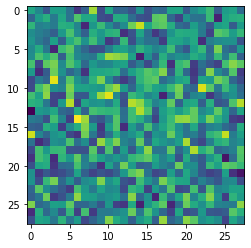

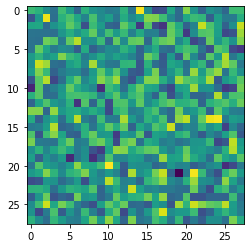

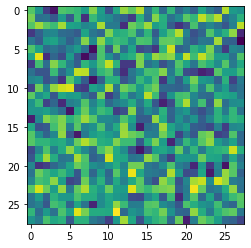

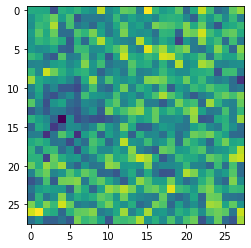

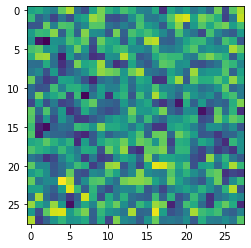

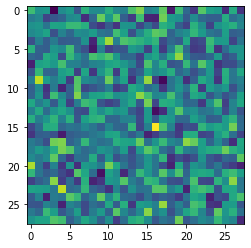

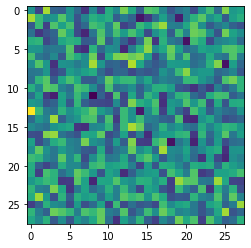

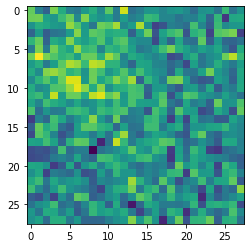

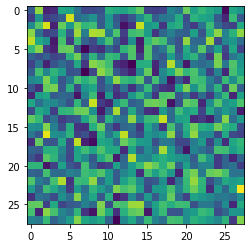

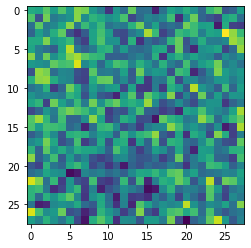

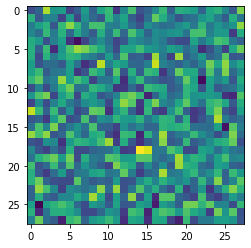

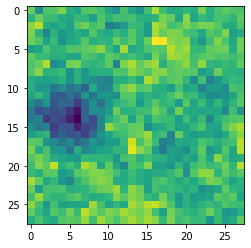

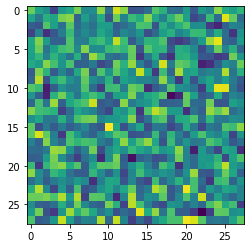

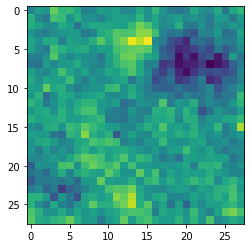

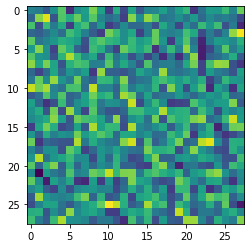

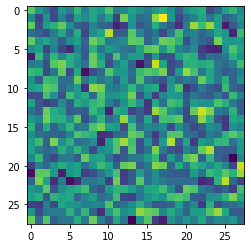

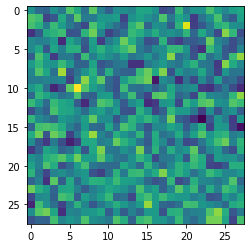

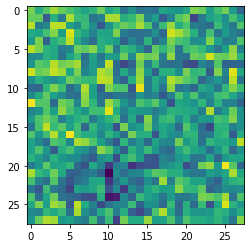

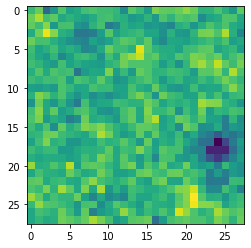

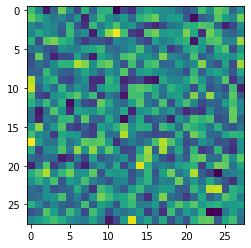

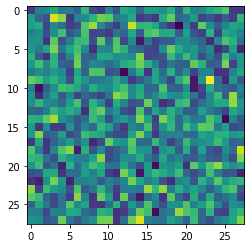

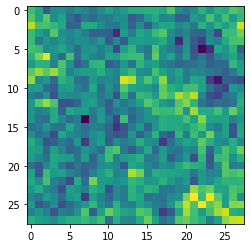

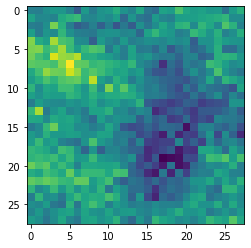

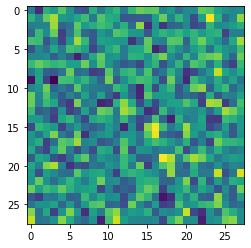

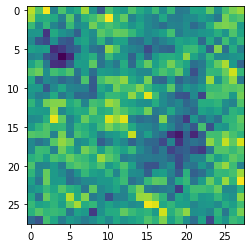

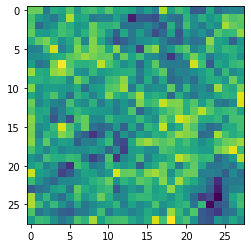

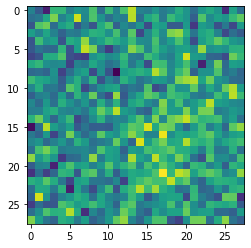

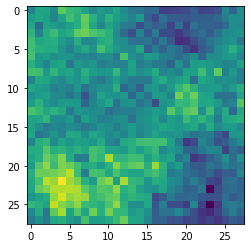

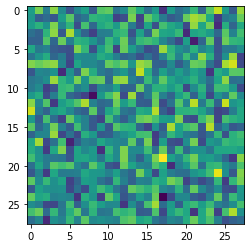

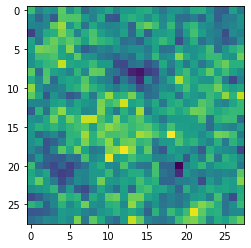

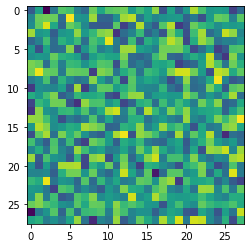

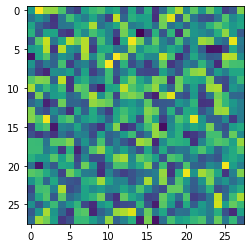

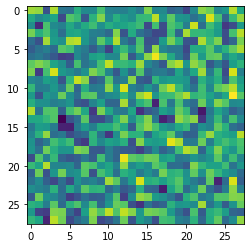

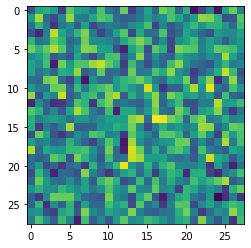

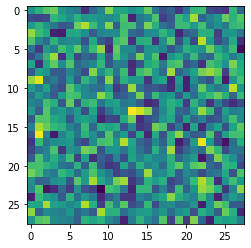

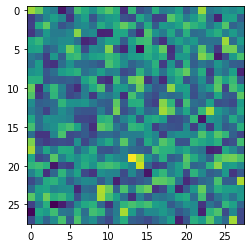

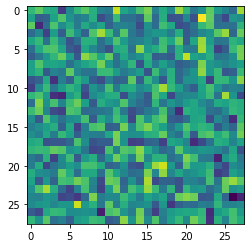

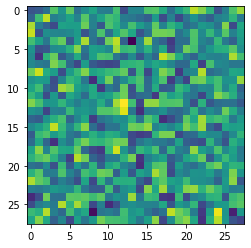

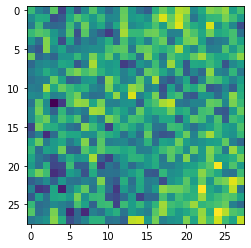

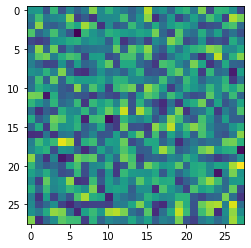

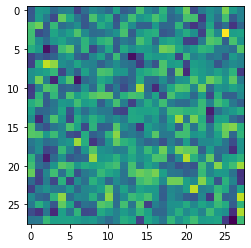

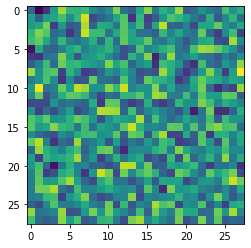

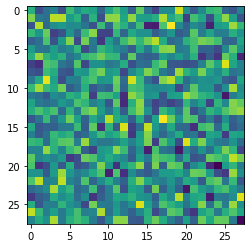

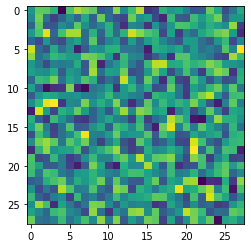

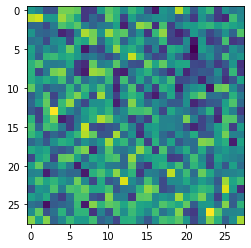

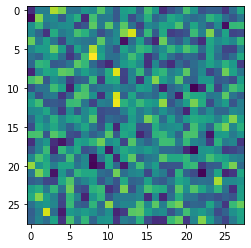

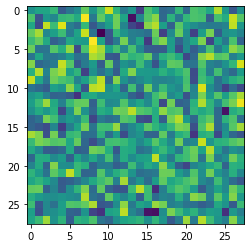

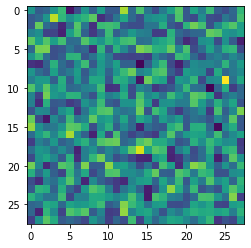

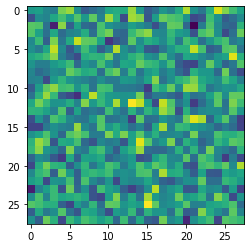

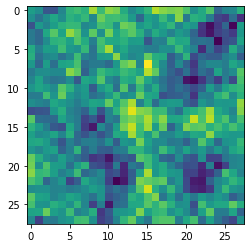

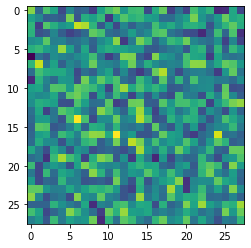

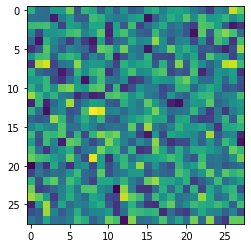

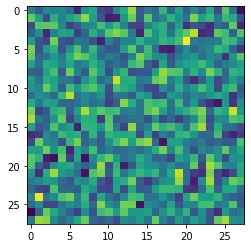

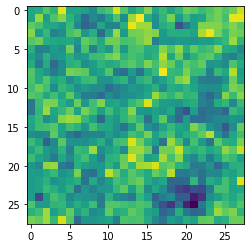

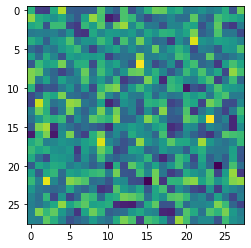

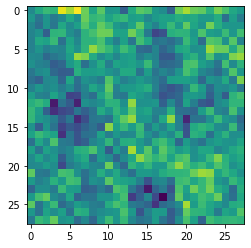

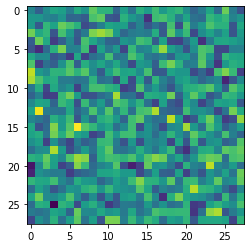

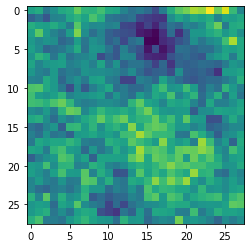

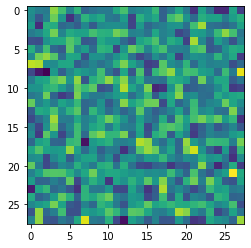

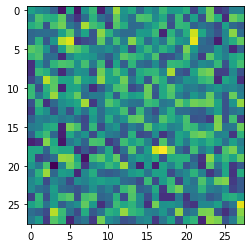

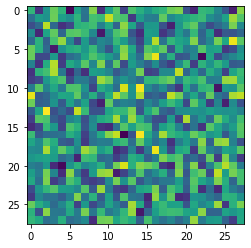

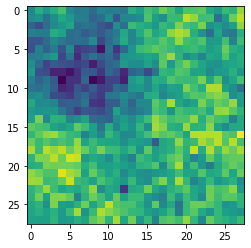

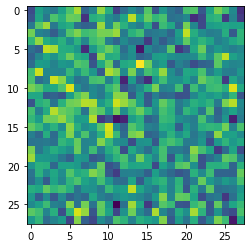

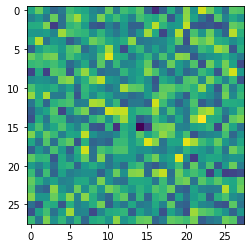

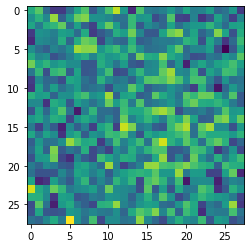

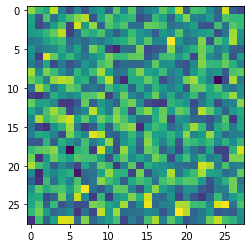

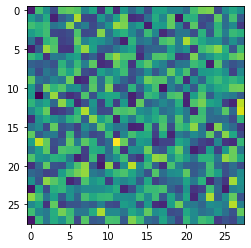

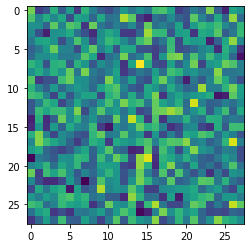

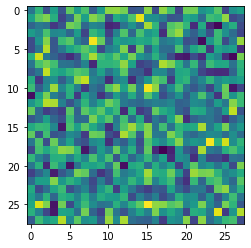

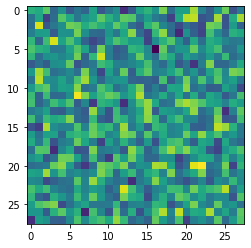

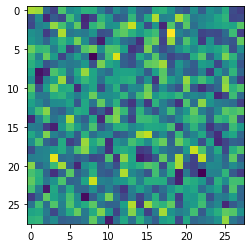

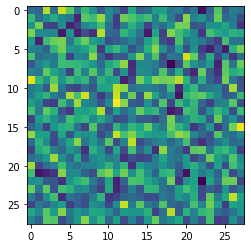

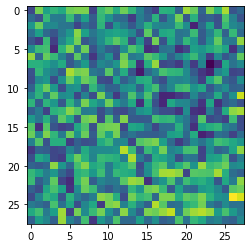

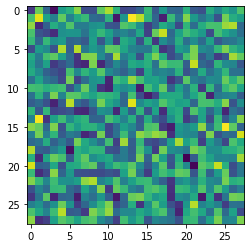

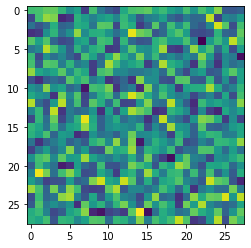

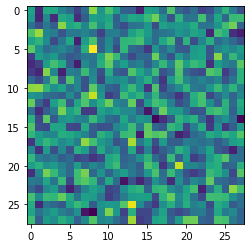

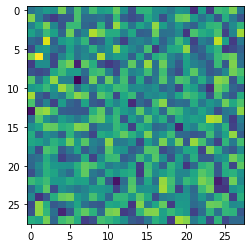

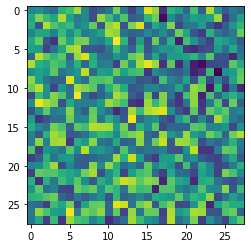

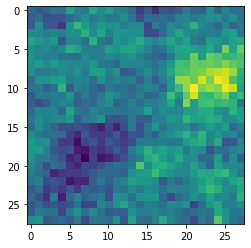

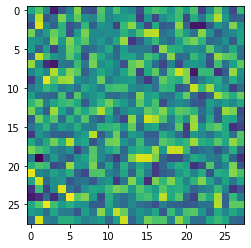

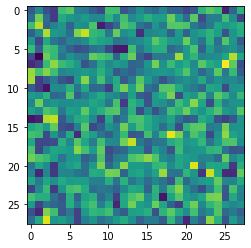

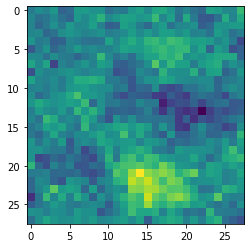

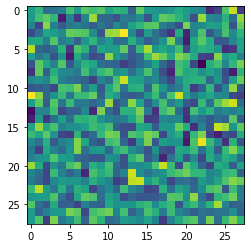

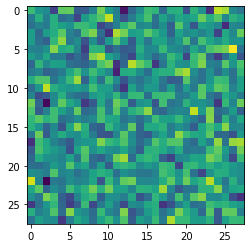

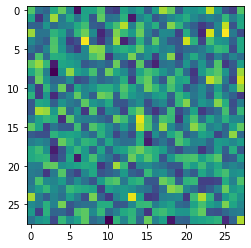

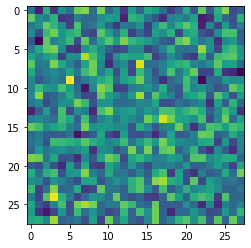

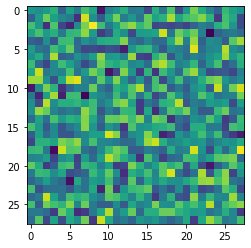

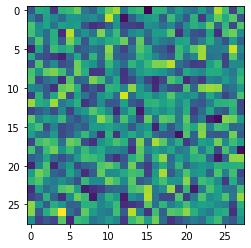

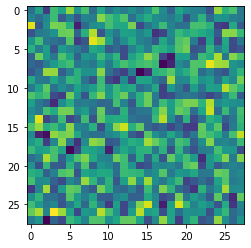

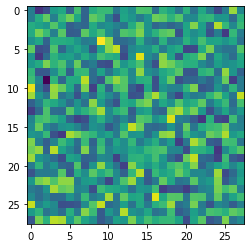

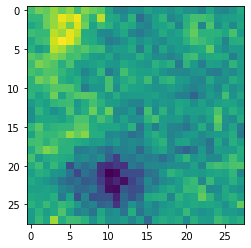

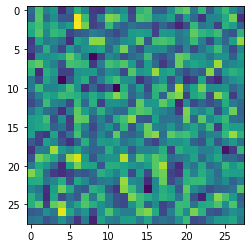

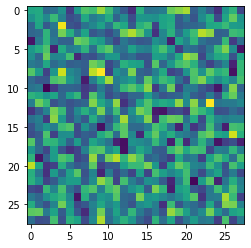

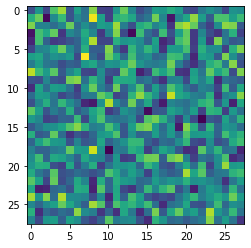

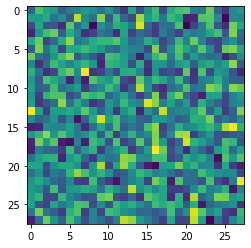

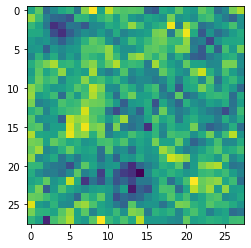

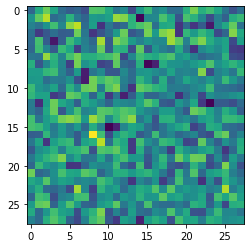

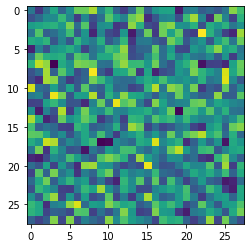

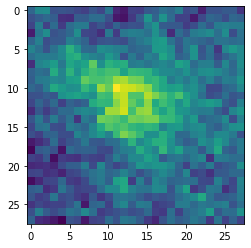

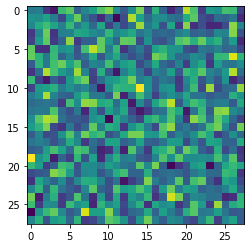

In [192]:
W=fc.lin1.weight.data
visualize_fields(W)